In [ ]:
#!pip install --upgrade pip
!pip install torch_geometric

In [ ]:
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import timeit


from tqdm import tqdm
from sklearn import preprocessing
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, torch.__version__)

/Users/rozaabol/opt/anaconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu 1.12.1


In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu102.html
!pip install torch-geometric
import torch_geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu102.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu102.html


In [ ]:
from torch_scatter import scatter_mean, scatter_add

# Defining the Attention Mechanism as a Separate Class of itself
class AttentionLayer(torch.nn.Module):
    def __init__(self, d = 16, activation=2, a = 0.1):
        """
        :param: d: Output Dimension of the Node Embeddings
        :param: activation: The Activation Function to be used for the Attention Layer
        :param: a: Slope of the -ve part if the activation is Leaky ReLU
        """
        super(AttentionLayer, self).__init__()
        self.d = d # Output dimension of the Convolution Vector for each Node
        self.activation = activation
        self.a = a # Slope of the negative part in Leaky-ReLU

        self.params()
        self.initialize()

    def params(self):
        self.W_att = torch.nn.Parameter(torch.Tensor(self.d, self.d))

    def initialize(self):
        """
        Initialization depends upon the activation function used.
        If ReLU/ Leaky ReLU : He (Kaiming) Initialization
        If tanh/ sigmoid : Xavier Initialization
        0-ReLU, 1-Leaky ReLU, 2-tanh, 3-sigmoid
        """
        non_lin = {0:"relu", 1:"leaky_relu", 2:"tanh", 3:"sigmoid"}

        if (self.activation==1) or (self.activation==0):
            torch.nn.init.kaiming_normal_(self.W_att, a=self.a, nonlinearity=non_lin[self.activation])
        elif (self.activation==2) or (self.activation==3):
            torch.nn.init.xavier_normal_(self.W_att)
        else:
            raise ValueError("Activation can only take values 0,1,2,3!")

    def forward(self, node_embeddings, batch, size = None):
        """
        :param: node_embeddings :(N_B x D) Tensor containing Node Embeddings
        :param: batch : Tensor containing the Graph to which Each Node in the Batch belongs
        :param: size : Check Documentation https://pytorch-scatter.readthedocs.io/en/1.3.0/functions/mean.html
        :return: global_graph_embedding for each graph in the batch
        """
        size = batch[-1].item()+1 if size is None else size # Gives Batch Size = B

        global_context = scatter_mean(node_embeddings,index = batch, dim=0, dim_size = size) # (N_B,D) -> (B,D) (mean)
        global_context = torch.matmul(global_context, self.W_att) # (B,D) x (D,D) -> (B,D)

        # Applying the Non-Linearity over W_att*mean(U_i), the default is tanh
        if self.activation==2:
            global_context = torch.tanh(global_context)
        elif self.activation==1:
            leaky_relu = torch.nn.LeakyReLU()
            global_context = leaky_relu(global_context)
        elif self.activation==0:
            global_context = global_context.relu()
        elif self.activation==3:
            global_context = torch.sigmoid(global_context)

        # Getting the attention value for each Node for a Given Graph
        e = torch.sum(node_embeddings*global_context[batch], dim=1) # (N_B,D) * (N_B,D) -> (N_B,1) (due to sum along dimension D)
        attn_weights = e.sigmoid() # (N_B, 1)

        # Calculating the Global Graph Embedding
        global_graph_embedding = scatter_add(node_embeddings*attn_weights.unsqueeze(-1),
                                             index=batch, dim=0, dim_size=size) # (N_B,D) x (N_B,1) -> (B,D)

        return global_graph_embedding

# **2) Neural Tensor Network Layer**

In [ ]:
# Defining the Neural Tensor Network Layer as a Separate Class of Itself
class NTNLayer(torch.nn.Module):
    def __init__(self, d=16, k=16, activation=0, a = 0.1):
        """
        :param: d: Input Dimension of the NTN - i.e Dimension of the Graph/ Node Embeddings
        :param: k: Output Dimension of the NTN - No. of Similarity Scores to output
        :param: activation: Activation Function to be used for the NTN - Default = ReLU
        :param: a: Slope of the negative part for a Leaky ReLU activation
        """
        super(NTNLayer, self).__init__()
        self.d = d # Input Dimension of the NTN
        self.k = k # Output dimension of the NTN
        self.a = a # Slope in case of Leaky ReLU initialization
        self.activation = activation
        self.params()
        self.initialize()

    def params(self):
        self.W = torch.nn.Parameter(torch.Tensor(self.d,self.d,self.k))
        self.V = torch.nn.Parameter(torch.Tensor(self.k, 2*self.d))
        self.b = torch.nn.Parameter(torch.Tensor(self.k,1))

    def initialize(self):
        """
        Initialization depends upon the activation function used.
        If ReLU/ Leaky ReLU : He Initialization
        If tanh/ sigmoid : Xavier Initialization
        0-ReLU, 1-Leaky ReLU, 2-tanh, 3-sigmoid
        """
        non_lin = {0:"relu", 1:"leaky_relu", 2:"tanh", 3:"sigmoid"}
        if (self.activation==1) or (self.activation==0):
            torch.nn.init.kaiming_normal_(self.W, a=self.a, nonlinearity=non_lin[self.activation])
            torch.nn.init.kaiming_normal_(self.V, a=self.a, nonlinearity=non_lin[self.activation])
            torch.nn.init.kaiming_normal_(self.b, a=self.a, nonlinearity=non_lin[self.activation])

        elif (self.activation==2) or (self.activation==3):
            torch.nn.init.xavier_normal_(self.W)
            torch.nn.init.xavier_normal_(self.V)
            torch.nn.init.xavier_normal_(self.b)

        else:
            raise ValueError("Activation can only take values 0,1,2,3!")

    def forward(self, h1, h2):
        """Returns 'K' Rough Similarity Scores between the Pair of Graphs
        The Neural Tensor Network (NTN) outputs 'K' similarity scores where 'K' is a hyperparameter
        :param: h1 : Graph Embedding of Graph 1 - (B,D)
        :param: h2 : Graph Embedding of Graph 2 - (B,D)
        """
        B,_ = h1.shape
        scores = torch.mm(h1, self.W.view(self.d, -1)) # (B,D) x (D, K+D) -> (B, K+D)
        scores = scores.view(B,self.d,self.k) # (B,K+D) -> (B,D,K)
        scores = (scores*h2.unsqueeze(-1)).sum(dim=1) # (B,D,K) * (B,D,1) -> (B,K)

        concatenated_rep = torch.cat((h1, h2), dim=1) # (B,2D)
        scores = scores + torch.mm(concatenated_rep, self.V.t()) # (B,2D) x (2D,K) -> (B,K)
        scores = scores + self.b.t() # (B,K) + (1,K) = (B,K)

        if self.activation==0:
            scores = scores.relu()
            return scores
        elif self.activation==1:
            leaky_relu = torch.nn.LeakyReLU()
            scores = leaky_relu(scores)
            return scores
        elif self.activation==2:
            scores = torch.tanh(scores)
            return scores
        elif self.activation==3:
            scores = torch.sigmoid(scores)
            return scores
        else:
            raise ValueError("Activation can only take values 0,1,2,3!")

# **3) SimGNN - Putting it Together**

In [ ]:
# Writing the Entire SimGNN Model
from torch_geometric.utils import to_dense_batch, to_dense_adj
from torch_geometric.nn import GCNConv
from torch.nn import Linear

class SimGNN(torch.nn.Module):
    def __init__(self, num_node_features, hist=True, ntn_layer=True, d=16, k=16, bins = 16):
        super(SimGNN, self).__init__()
        self.setupHyperParams(hist, ntn_layer, d, k, bins, num_node_features)
        self.setupLayers()

    def setupHyperParams(self, hist, ntn_layer, d, k, bins, num_node_features):
        self.num_node_features = num_node_features
        # Dimension of the Node/ Graph Embeddding
        self.d = d
        # Output Dimension of the NTN
        self.k = k
        # Do we want to include the NTN Layer in the pipeline
        self.ntn_layer = ntn_layer
        # Do we want to use the histogram strategy
        self.hist = hist
        # No. of Bins to be used for the Histogram
        self.bins = bins

    def fcnnInputDim(self):
        """Calculate The Input Dimension of the FCNN Layer"""
        if self.hist and self.ntn_layer:
            return self.bins+self.k
        elif self.hist:
            return self.bins + 1
        elif self.ntn_layer:
            return self.k
        else :
            # Instead of NTN ,we would just be using a simple rbf kernel
            # between the Graph Embeddings to Compute Similarities
            return 1

    def setupLayers(self):
        fcnn_input_dim = self.fcnnInputDim()

        # Layers of SimGNN
        # GCN Layers
        self.conv1 = GCNConv(self.num_node_features,64)
        self.conv2 = GCNConv(64,32)
        self.conv3 = GCNConv(32,self.d)

        # Attention Layer and Neural Tensor Network Layer
        self.attention_layer = AttentionLayer(self.d)
        self.NTN = NTNLayer(self.d, self.k)

        # Fully Connected Layer
        self.linear_1 = torch.nn.Linear(fcnn_input_dim,16)
        self.linear_2 = torch.nn.Linear(16,8)
        self.linear_3 = torch.nn.Linear(8,4)
        self.linear_4 = torch.nn.Linear(4,1)

    def GCN(self, x, edge_index):
        """
        Implementing the Graph Convolutional Network
        :param x : One Hot Encoded Feature Representation of the Nodes
        :param edge_index : Tensor Representation of Edges to calculate Adjacency Matrix
        :U : (N_B x D) matrix of Node Embeddings
        :N_B : Total No. of Nodes in the Batch (irrespective of parent graph)
        :D : dimensions of the Node Embeddings (decided by us)
        I haven't implemented Dropout/ BatchNorm but can also try to do that
        """
        U = self.conv1(x, edge_index)
        U = U.relu()
        U = self.conv2(U, edge_index)
        U = U.relu()
        U = self.conv3(U, edge_index)
        return U

    def kernel(self, graph_embedding_1, graph_embedding_2):
        pass

    def rbf_kernel_sim(self, graph_embedding_1, graph_embedding_2):
        """
        :param: graph_embedding_1 : (B,D) dimensional graph embedding
        :param: graph_embedding_2 : (B,D) dimensional graph embedding
        :return: rbf_sim : RBF Kernel Similarity the two graph embeddings
        """
        distance = graph_embedding_1-graph_embedding_2
        distance = torch.sum(distance*distance, dim = 1)
        # return (1/distance).view(-1,1)
        return torch.exp(-distance).view(-1,1)

    def histogram(self, U1, U2, batch1, batch2):
        """ B = Batch Size
        To calculate the Histogram Representation of the Pairwise Interaction Tensor
        :param: U1 : (N_B1 x D) matrix which encodes the node embeddings of Graph 1
        :param: U2 : (N_B2 x D) matrix which encodes the node embeddings of Graph 2
        :param: batch1 : Logs the Parent graph of the Nodes
        :param: batch2 : Logs the Parent Graph of the Nodes
        :return: norm_hist_scores : (B x self.bins) Normalized histogram for each batch
        """
        # Convert U1 and U2 into Dense Matrices
        U1, mask1 = to_dense_batch(U1, batch1) # (B, N_max1, D); (B, N_max1)
        U2, mask2 = to_dense_batch(U2, batch2) # (B, N_max2, D); (B, N_max2)
        B, N_max1, _ = U1.size()
        B, N_max2, _ = U2.size()

        # Max Number of Nodes for Each Graph Pair in the Batch
        max_total_nodes = torch.max(mask1.sum(dim=1), mask2.sum(dim=1)).view(-1) # (B,1)

        # Calculating Interaction Scores for the entire batch
        interaction_scores = torch.matmul(U1, U2.permute(0,2,1)).detach() # (B, N_max1, N_max2)
        interaction_scores = torch.sigmoid(interaction_scores)

        # Getting the Histogram for each Pair in the batch
        hist_score_list = []
        for i in range(B):
            interaction_matrix = interaction_scores[:,:max_total_nodes[i], :max_total_nodes[i]]
            hist_score = torch.histc(interaction_matrix, bins = self.bins).view(-1) # (self.bins,)
            hist_score = hist_score/hist_score.sum() # Normalizing the Histogram
            hist_score_list.append(hist_score)

        return torch.stack(hist_score_list).view(B, self.bins) # (B, self.bins)

    def FCNN(self, x):
        """:param: x: Rough Similarity Scores of 'B' Graph Pairs where B is Batch Size"""
        ged_sim = self.linear_1(x)
        ged_sim = ged_sim.relu()

        ged_sim = self.linear_2(ged_sim)
        ged_sim = ged_sim.relu()

        ged_sim = self.linear_3(ged_sim)
        ged_sim = ged_sim.relu()
        ged_sim = self.linear_4(ged_sim)

        return ged_sim.sigmoid()

    def forward(self, data):
        """
         Forward pass with graphs.
         :param data: A Batch Containing a Pair of Graphs.
         :return score: Similarity score.
         """
        edge_index_1 = data.edge_index_1
        edge_index_2 = data.edge_index_2
        x1, x2 = data.x1, data.x2
        x1_batch , x2_batch = data.x1_batch, data.x2_batch

        # Passed through GCN
        node_embeddings_1 = self.GCN(x1, edge_index_1)
        node_embeddings_2 = self.GCN(x2, edge_index_2)

        # Passed through Attention Layer to get Graph Embedding
        graph_embedding_1 = self.attention_layer(node_embeddings_1, x1_batch)
        graph_embedding_2 = self.attention_layer(node_embeddings_2, x2_batch)

        # Passed through Neural Tensor Network if allowed otherwise just take a simple Inner Product
        if self.ntn_layer:
            scores = self.NTN(graph_embedding_1, graph_embedding_2)
        else:
            scores = self.rbf_kernel_sim(graph_embedding_1, graph_embedding_2)

        # Computed Histogram from the Node Embeddings (Strategy 2)
        if self.hist:
            hist = self.histogram(node_embeddings_1, node_embeddings_2, x1_batch, x2_batch)
            scores = torch.cat((scores, hist), dim=1) # (B, K+self.bins)

        # Pass through the Fully Connected Neural Network Layer to get Graph Edit Distance Similarity
        sim_pred = self.FCNN(scores)

        return sim_pred.view(-1)

# **4) Loading Data & Feature Engineering**

In [ ]:
#name = "LINUX"
#from torch_geometric.datasets import GEDDataset
#train_graphs = GEDDataset(root="./data_/train", train = True, name=name)
#test_graphs = GEDDataset(root="./data_/test", train = False, name=name)

#print(f"Number of Graphs in Train Set : {len(train_graphs)}")
#print(f"Number of Graphs in Test Set : {len(test_graphs)}")

In [ ]:
#### ******* I added this part (to make smaller dataset)********
#name = "LINUX"
#from torch_geometric.datasets import GEDDataset
#train_graphs = GEDDataset(root="./data_/train", train = True, name=name)#[0:20]
#test_graphs = GEDDataset(root="./data_/test", train = False, name=name)#[0:5]

#print(f"Number of Graphs in Train Set : {len(train_graphs)}")
#print(f"Number of Graphs in Test Set : {len(test_graphs)}")

In [ ]:

#i = 1
#print(train_graphs[0].num_features)
#print(test_graphs[151])


## **a)Loading data**
## **b) Creating Data objects (Graphs)**

In [ ]:
##***
"""List of parameters:  https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#module-torch_geometric.data
x (Tensor, optional) – Node feature matrix with shape [num_nodes, num_node_features]. (default: None)
edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]. (default: None)
edge_attr (Tensor, optional) – Edge feature matrix with shape [num_edges, num_edge_features]. (default: None)
y (Tensor, optional) – Graph-level or node-level ground-truth labels with arbitrary shape. (default: None)
pos (Tensor, optional) – Node position matrix with shape [num_nodes, num_dimensions]. (default: None)
"""
from torch_geometric.data import Data
import random

num_items = 10
num_nodes = num_items
num_users = 60
pr_train = 80 #percentage of number of training data
train_graphs = []
test_graphs = []
DS_graphs = []

# INFO on CAR dataset: link to download: http://users.cecs.anu.edu.au/~u4940058/CarPreferences.html
# The preference questionnaire contains control questions that were randomly selected from the preferences with reversed order. These control questions were included to measure the consistency of the answers provided. In the dataset, we include all the information collected from the experiments. The reader may choose to exclude information based on the control questions which are indicators for random responses from that user.
# Data format:The data collected from two experiments is formatted in three csv files respectively representing user attributes, item attributes, and preferences of users over items. In the preference sets for the given user, the first item (indicated by its ID) is preferred to the second one. If the preference was collected as a control question it is indicated by 1 otherwise 0.

#Original data
Dataset_users = pd.read_csv("./CarDataset/users1.csv") ##Car Dataset_Pair items
Dataset_Edges = pd.read_csv("./CarDataset/prefs1.csv") ##Car Dataset_Pair items
Dataset_Node_features = pd.read_csv("./CarDataset/items1.csv") ##Car Dataset_item features

Dataset_Node_features.drop("Item_ID", axis=1, inplace=True) #removing the index of items from the features
Nodes_FeatureMatrix = Dataset_Node_features.values.tolist()
num_node_features = len(Nodes_FeatureMatrix[0])
x = torch.tensor(Nodes_FeatureMatrix, dtype=torch.float) #Node feature matrix with shape [num_nodes, num_node_features]
#
old_user = 0
idx_train = 0
idx_test = 0
for index, row in Dataset_Edges.iterrows():
    current_user = row.User_ID    #CarData.User_ID[index]
    if old_user != current_user:
        if current_user >1 and current_user <= num_users :
            # Saving graph of the user
            # Info:https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html
            edge_index = torch.tensor(Edges_matrix, dtype=torch.long) -1 #Graph connectivity in COO format with shape [2, num_edges]. (default: None)
            data = Data(edge_index=edge_index, x=x, num_nodes=num_nodes, num_features=num_node_features )

            if idx_train < num_users * (5/6): ##random.randint(0,100) < pr_train:
                train_graphs.append(data)
                DS_graphs.append(data)
                idx_train +=1
            else:
                test_graphs.append(data)
                DS_graphs.append(data)
        # starting a new user:
        num_edges = Dataset_Edges.User_ID.tolist().count(current_user)
        Edges_matrix = np.zeros((2, num_edges)) ##empty
        edg = 0 ## edge
    item1 = row.Item1_ID    #CarData.Item1_ID[index]
    item2 = row.Item2_ID    #CarData.Item2_ID[index]
    Edges_matrix [0][edg]= row.Item1_ID
    Edges_matrix [1][edg]= row.Item2_ID
    edg+=1
    old_user = current_user

# Saving last graph user
edge_index = torch.tensor(Edges_matrix, dtype=torch.long)-1 #Graph connectivity in COO format with shape [2, num_edges]. (default: None)
data = Data(edge_index=edge_index, x=x, num_nodes=num_nodes, num_features=num_node_features )

test_graphs.append(data)
DS_graphs.append(data)

In [ ]:
##***

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

Dataset_graphs = train_graphs+ test_graphs

In [ ]:

print(train_graphs[10])

print("Number of Training Graphs = {}".format(len(train_graphs)))
print("Number of Testing Graphss = {}".format(len(test_graphs)))
print("Number of whole Graphss = {}".format(len(Dataset_graphs)))
print (DS_graphs==Dataset_graphs)  ####You can remove DS_graphs later

Data(x=[10, 4], edge_index=[2, 50], num_nodes=10, num_features=4)
Number of Training Graphs = 50
Number of Testing Graphss = 10
Number of whole Graphss = 60
True


In [ ]:
print(train_graphs[0].edge_index)

tensor([[8, 6, 8, 8, 6, 7, 4, 6, 1, 8, 4, 7, 6, 6, 6, 9, 2, 1, 6, 5, 6, 7, 1, 5,
         8, 5, 7, 2, 5, 7, 0, 8, 7, 8, 5, 5, 6, 2, 2, 1, 1, 1, 7, 0, 1, 4, 5, 7,
         0, 0],
        [2, 8, 0, 9, 4, 3, 9, 5, 9, 9, 2, 1, 3, 2, 7, 3, 3, 4, 0, 9, 9, 0, 8, 3,
         3, 0, 9, 9, 9, 2, 4, 5, 5, 4, 3, 4, 1, 3, 0, 0, 5, 3, 4, 8, 2, 3, 2, 8,
         3, 9]])


## **c) Creating a Feature Matrix for the Graphs**

In [ ]:
from torch_geometric.transforms import OneHotDegree
from torch_geometric.utils import degree

# If the dataset does not have a feature matrix, we create one!
# Only the AIDS700nef Dataset has an inbuilt feature matrix
# We create a One Hot Encoded Degree Feature Matrix
if train_graphs[0].x is None:
            max_degree = 0
            for graph in train_graphs + test_graphs:
                # If this graph has edges then do
                if graph.edge_index.size(1) > 0:
                    max_degree = max(max_degree, int(degree(graph.edge_index[0]).max().item()))

            # Create the feature matrix for the Dataset
            one_hot_degree = OneHotDegree(max_degree, cat=False)
            train_graphs.transform = one_hot_degree
            test_graphs.transform = one_hot_degree

num_node_features = train_graphs[0].num_features ##**
num_edge_features = train_graphs[0].num_edge_features ##**
print(num_node_features, num_edge_features)

4 0


## **d) Similarity between the praphs**

In [ ]:
## **Similarity**  A function which takes two inputs and returns theis similarity as a number.
# In "Recommendation systems", one measure for similarity between two users is to find the distance between their top-k most prefered items

# Item_scores_matrix is a matrix which rows are users and columns are items. Entries indicte how much the user likes this item more than the other items.
Item_scores_matrix = np.zeros((num_users, num_items))
for index, row in Dataset_Edges.iterrows():
    user = row.User_ID    #CarData.User_ID[index]
    item1 = row.Item1_ID    #CarData.Item1_ID[index]
    item2 = row.Item2_ID    #CarData.Item2_ID[index]
    Item_scores_matrix[user-1][item1-1] += 1


# Normalizing the scores
Personalized_Item_scores_matrix = np.zeros((num_users, num_items))
for user in range(num_users):
    Personalized_Item_scores_matrix[user] = Item_scores_matrix[user]/ (num_items)




## **e) Making Pairs of Graphs**

In [ ]:
class makeGraphPairs(torch_geometric.data.Data):
    """
    :param: edge_index_1 : Edge Index of the First Graph
    :param: edge_index_2 : Edge Index of the Second Graph in the pair
    :param: x_1 : Feature Matrix of the First Graph in the Pair
    :param: x_2 : Feature Matrix of the Second Graph in the Pair

    :returns: torch_geometric.data.Data object which comprises two graphs
    """
    def __init__(self, edge_index_1, x1, edge_index_2, x2, graph_sim):#, ged, norm_ged):##**
        super(makeGraphPairs, self).__init__()
        self.edge_index_1 = edge_index_1
        self.x1 = x1
        self.edge_index_2 = edge_index_2
        self.x2 = x2
        #self.ged = ged ##*
        #self.norm_ged = norm_ged ##*
        self.graph_sim = graph_sim ##*


    def __inc__(self, key, value,*rest): ## I added *rest
        if key == "edge_index_1":
            return self.x1.size(0)
        elif key == "edge_index_2":
            return self.x2.size(0)
        else:
            return super().__inc__(key, value)## I added *rest

In [ ]:
 ## **Similarity**  A function which takes two inputs and returns their similarity as a number.
 # Here, similarity is the intersect of top ranled items for two users.

def sim_TopK (x, y):
    #Indices1 = (-Personalized_Item_scores_matrix[user1.idx]).argsort()[:3] # Index of 3-best items (Culd use this one as well.)
    Personalized_Item_scores1 = np.zeros((num_items))
    Personalized_Item_scores2 = np.zeros((num_items))
    for item in range(num_items):
        Personalized_Item_scores1[item] =  x[0].tolist().count(item)/num_items # Personalized item score: (How many times i item prefered / num_items)
        Personalized_Item_scores2[item] =  y[0].tolist().count(item)/num_items
    print(Personalized_Item_scores1)
    print(Personalized_Item_scores2)
    # number of items with score more than n:
    n = 0.2
    Indices1 = [i for i,v in enumerate(Personalized_Item_scores1) if v >= n]
    Indices2 = [j for j,h in enumerate(Personalized_Item_scores2) if h >= n]
    print(Indices1)
    print(Indices2)
    graph_sim = len(np.intersect1d(Indices1,Indices2))/((len(Indices1)+len(Indices2))/2) #Min-max normalization on number of intersection of the preferences
    return graph_sim


In [ ]:

x = train_graphs[2].edge_index
y = train_graphs[0].edge_index
print(x)
print(sim_TopK (x, y))

tensor([[8, 8, 8, 9, 4, 3, 9, 5, 9, 9, 4, 7, 3, 2, 7, 9, 3, 4, 0, 9, 9, 0, 8, 3,
         8, 0, 9, 9, 9, 2, 4, 8, 5, 4, 3, 4, 1, 3, 0, 0, 5, 3, 4, 0, 2, 4, 2, 8,
         0, 9],
        [2, 6, 0, 8, 6, 7, 4, 6, 1, 8, 2, 1, 6, 6, 6, 3, 2, 1, 6, 5, 6, 7, 1, 5,
         3, 5, 7, 2, 5, 7, 0, 5, 7, 8, 5, 5, 6, 2, 2, 1, 1, 1, 7, 8, 1, 3, 5, 7,
         3, 0]])
[0.7 0.1 0.4 0.7 0.8 0.3 0.  0.2 0.7 1.1]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0, 2, 3, 4, 5, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8]
0.75


In [ ]:
 ## **Similarity**  A function which takes two inputs and returns theis similarity as a number.
 # Here, similarity is the intersect of top ranled items for two users.

def sim_GED (x, y):
    # Number of similar edges
    x_pairs = list(zip(x[0],x[1]))
    y_pairs = list(zip(y[0],y[1]))


    graph_sim = len([l for l in x_pairs if l in y_pairs]) /(np.max([len(x_pairs), len(y_pairs)]))
    return graph_sim



In [ ]:

i = train_graphs[0].edge_index.tolist()[0]
j = train_graphs[0].edge_index.tolist()[1]
print(i)
print(j)
print("\n")
pairs = list(zip(i,j))
print(pairs)
print("\n")

ii = train_graphs[1].edge_index.tolist()[0]
jj = train_graphs[1].edge_index.tolist()[1]
print(ii)
print(jj)
print("\n")
pairs2 = list(zip(ii,jj))
print(pairs2)


print("\n")
print(np.intersect1d(pairs, pairs2, assume_unique=False,))
print(np.intersect1d(pairs[0], pairs2[0], assume_unique=False,))
pairs[0]==pairs2[0]

len([l for l in pairs if l in pairs2])

[8, 6, 8, 8, 6, 7, 4, 6, 1, 8, 4, 7, 6, 6, 6, 9, 2, 1, 6, 5, 6, 7, 1, 5, 8, 5, 7, 2, 5, 7, 0, 8, 7, 8, 5, 5, 6, 2, 2, 1, 1, 1, 7, 0, 1, 4, 5, 7, 0, 0]
[2, 8, 0, 9, 4, 3, 9, 5, 9, 9, 2, 1, 3, 2, 7, 3, 3, 4, 0, 9, 9, 0, 8, 3, 3, 0, 9, 9, 9, 2, 4, 5, 5, 4, 3, 4, 1, 3, 0, 0, 5, 3, 4, 8, 2, 3, 2, 8, 3, 9]


[(8, 2), (6, 8), (8, 0), (8, 9), (6, 4), (7, 3), (4, 9), (6, 5), (1, 9), (8, 9), (4, 2), (7, 1), (6, 3), (6, 2), (6, 7), (9, 3), (2, 3), (1, 4), (6, 0), (5, 9), (6, 9), (7, 0), (1, 8), (5, 3), (8, 3), (5, 0), (7, 9), (2, 9), (5, 9), (7, 2), (0, 4), (8, 5), (7, 5), (8, 4), (5, 3), (5, 4), (6, 1), (2, 3), (2, 0), (1, 0), (1, 5), (1, 3), (7, 4), (0, 8), (1, 2), (4, 3), (5, 2), (7, 8), (0, 3), (0, 9)]


[2, 6, 0, 9, 4, 3, 9, 5, 9, 9, 4, 1, 3, 2, 7, 9, 3, 4, 6, 5, 9, 7, 1, 5, 3, 5, 9, 9, 9, 7, 4, 5, 5, 4, 5, 5, 1, 3, 0, 0, 5, 1, 4, 0, 1, 4, 5, 7, 3, 9]
[8, 8, 8, 8, 6, 7, 4, 6, 1, 8, 2, 7, 6, 6, 6, 3, 2, 1, 0, 9, 6, 0, 8, 3, 8, 0, 7, 2, 5, 2, 0, 8, 7, 8, 3, 4, 6, 2, 2, 1, 1, 3, 7, 8, 2, 3, 2, 

19

In [ ]:
## Hazf kon.
x=train_graphs[30].edge_index
y=train_graphs[30].edge_index

print(sim_GED(x,y))

1.0


In [ ]:
# Choose the similarity function here:
## **Similarity**  A function which takes two inputs and returns theis similarity as a number.


#Simimilarity_Function = sim_TopK(edge_index_1, edge_index_2)
#Simimilarity_Function = sim_GED(edge_index_1, edge_index_2)

### **i. For Training**

In [ ]:
"""TRAINING SET PAIR"""
# Data List to pass into the Data Loader to get Batches
train_graph_pair_list = []


# Making the Pairs of Graphs
for graph1_num, graph1 in enumerate(train_graphs):
    for graph2 in train_graphs:
        # Initializing Data
        edge_index_1 = graph1.edge_index
        x1 = graph1.x
        edge_index_2 = graph2.edge_index
        x2 = graph2.x

        #ged = train_graphs.ged[graph1, graph2] ##**
        #norm_ged = train_graphs.norm_ged[graph1.i, graph2.i]##**
        #graph_sim = torch.exp(-norm_ged)##**
        #ged=128         ##**
        #norm_ged=128   ##**
        #graph_sim=128  ##**
        graph_sim =  sim_TopK (edge_index_1, edge_index_2)  ##**

        # Making Graph Pair
        graph_pair = makeGraphPairs(edge_index_1=edge_index_1, x1=x1,
                                    edge_index_2=edge_index_2, x2=x2, graph_sim = graph_sim)#,ged=ged ,norm_ged=norm_ged , graph_sim = graph_sim) ##*

        # Saving all the Graph Pairs to the List for Batching and Data Loading
        train_graph_pair_list.append(graph_pair)

[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0, 1, 2, 4, 5, 6, 7, 8]
[0, 1, 2, 4, 5, 6, 7, 8]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0.4 0.5 0.2 0.6 0.7 1.  0.2 0.4 0.  1. ]
[0, 1, 2, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0.7 0.1 0.4 0.7 0.8 0.3 0.  0.2 0.7 1.1]
[0, 1, 2, 4, 5, 6, 7, 8]
[0, 2, 3, 4, 5, 7, 8, 9]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0.2 0.5 0.2 0.  0.3 1.  0.7 0.9 0.5 0.7]
[0, 1, 2, 4, 5, 6, 7, 8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0.2 0.6 0.5 0.7 0.2 0.5 0.7 0.2 0.6 0.8]
[0, 1, 2, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0.2 0.8 0.3 0.2 0.3 0.7 0.9 0.7 0.6 0.3]
[0, 1, 2, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0, 1, 2, 4, 5, 6, 7, 8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]

[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.6 0.2 0.2 0.  0.6 1.1 0.4 0.8 0.3 0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.  0.9 0.2 0.4 0.1 0.9 0.8 0.6 0.7 0.4]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.3 0.4 0.9 1.  0.5 0.1 0.2 0.  0.7 0.9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 6, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.7 0.2 0.3 0.4 0.7 0.8 0.  0.4 0.1 1. ]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 7, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.  0.9 0.5 0.8 0.2 0.7 0.8 0.3 0.2 0.6]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.2 0.7 0.1 0.2 0.4 1.  0.5 0.8 0.3 0.6]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9

[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0.7 0.5 0.2 0.  0.4 1.  0.6 0.9 0.3 0.4]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0.3 0.6 0.2 0.  0.2 1.1 0.5 0.8 0.5 0.8]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0.  0.8 0.3 0.8 0.1 0.4 0.5 0.3 1.1 0.7]
[1, 2, 3, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0.4 0.3 0.8 0.7 0.5 0.1 0.2 0.  1.  1. ]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 6, 8, 9]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0.5 0.4 0.2 0.  0.5 0.9 0.7 0.9 0.5 0.4]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0.  0.7 0.6 0.7 0.1 0.3 0.8 0.2 1.1 0.5]
[1, 2, 3, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0.3 0.6 0.2 0.  0.2 0.9 0.6 0.9 0.5 0.8]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0.1 0.6

[0.3 0.6 0.2 0.  0.2 1.  0.7 0.9 0.7 0.4]
[0.7 0.2 0.2 0.6 0.8 0.7 0.  0.5 0.2 1.1]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 7, 8, 9]
[0.3 0.6 0.2 0.  0.2 1.  0.7 0.9 0.7 0.4]
[0.4 0.4 0.  0.4 0.1 0.8 0.3 0.7 0.6 1.1]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 3, 5, 6, 7, 8, 9]
[0.3 0.6 0.2 0.  0.2 1.  0.7 0.9 0.7 0.4]
[0.  0.8 0.2 0.4 0.1 0.5 0.6 0.3 1.1 0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.3 0.6 0.2 0.  0.2 1.  0.7 0.9 0.7 0.4]
[0.2 0.5 0.3 0.  0.2 1.1 0.7 0.8 0.5 0.7]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.6 0.2 0.  0.2 1.  0.7 0.9 0.7 0.4]
[0.4 0.2 0.8 0.9 0.6 0.3 0.  0.1 0.9 0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 8, 9]
[0.3 0.6 0.2 0.  0.2 1.  0.7 0.9 0.7 0.4]
[0.2 0.6 0.2 0.  0.3 1.1 0.7 0.8 0.5 0.6]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.6 0.2 0.  0.2 1.  0.7 0.9 0.7 0.4]
[0.2 0.7 0.  0.2 0.3 1.1 0.6 0.8 0.5 0.6]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0.3 0.6 0.2 0.  0.2 1.  0.7 

[0.5 0.4 0.2 0.  0.5 0.9 0.7 0.9 0.5 0.4]
[0.  0.9 0.5 0.8 0.2 0.7 0.8 0.3 0.2 0.6]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5 0.4 0.2 0.  0.5 0.9 0.7 0.9 0.5 0.4]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.5 0.4 0.2 0.  0.5 0.9 0.7 0.9 0.5 0.4]
[0.2 0.7 0.1 0.2 0.4 1.  0.5 0.8 0.3 0.6]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0.5 0.4 0.2 0.  0.5 0.9 0.7 0.9 0.5 0.4]
[0.6 0.5 0.9 1.  0.7 0.3 0.2 0.  0.2 0.6]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 8, 9]
[0.5 0.4 0.2 0.  0.5 0.9 0.7 0.9 0.5 0.4]
[0.3 0.4 0.1 0.  0.3 0.9 0.6 0.7 0.4 0.6]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 4, 5, 6, 7, 8, 9]
[0.  0.7 0.6 0.7 0.1 0.3 0.8 0.2 1.1 0.5]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8]
[0.  0.7 0.6 0.7 0.1 0.3 0.8 0.2 1.1 0.5]
[0.4 0.5 0.2 0.6 0.7 1.  0.2 0.4 0.  1. ]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0.  0.7 0.6 0.7 0.1 0.3 0.8 0.2 1.

[0.2 0.6 0.  0.2 0.3 1.  0.5 0.7 0.5 1. ]
[0.3 0.6 0.2 0.  0.2 1.1 0.5 0.8 0.5 0.8]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.2 0.6 0.  0.2 0.3 1.  0.5 0.7 0.5 1. ]
[0.  0.8 0.3 0.8 0.1 0.4 0.5 0.3 1.1 0.7]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.2 0.6 0.  0.2 0.3 1.  0.5 0.7 0.5 1. ]
[0.4 0.3 0.8 0.7 0.5 0.1 0.2 0.  1.  1. ]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 6, 8, 9]
[0.2 0.6 0.  0.2 0.3 1.  0.5 0.7 0.5 1. ]
[0.5 0.4 0.2 0.  0.5 0.9 0.7 0.9 0.5 0.4]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.2 0.6 0.  0.2 0.3 1.  0.5 0.7 0.5 1. ]
[0.  0.7 0.6 0.7 0.1 0.3 0.8 0.2 1.1 0.5]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.2 0.6 0.  0.2 0.3 1.  0.5 0.7 0.5 1. ]
[0.3 0.6 0.2 0.  0.2 0.9 0.6 0.9 0.5 0.8]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.2 0.6 0.  0.2 0.3 1.  0.5 0.7 0.5 1. ]
[0.1 0.6 0.3 0.  0.3 1.  0.7 0.7 0.6 0.7]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 4, 5, 6, 7, 8, 9]
[0.2 0.6 0.  0.2 0.3 1.  0.5 0.7

[0.1 0.9 0.2 0.6 0.2 0.9 0.7 0.4 0.5 0.5]
[0.6 0.5 0.9 1.  0.7 0.3 0.2 0.  0.2 0.6]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 8, 9]
[0.1 0.9 0.2 0.6 0.2 0.9 0.7 0.4 0.5 0.5]
[0.3 0.4 0.1 0.  0.3 0.9 0.6 0.7 0.4 0.6]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 4, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 0.9 0.7 0.9 0.8 0.4]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8]
[0.3 0.5 0.2 0.  0.2 0.9 0.7 0.9 0.8 0.4]
[0.4 0.5 0.2 0.6 0.7 1.  0.2 0.4 0.  1. ]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0.3 0.5 0.2 0.  0.2 0.9 0.7 0.9 0.8 0.4]
[0.7 0.1 0.4 0.7 0.8 0.3 0.  0.2 0.7 1.1]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 2, 3, 4, 5, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 0.9 0.7 0.9 0.8 0.4]
[0.2 0.5 0.2 0.  0.3 1.  0.7 0.9 0.5 0.7]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 0.9 0.7 0.9 0.8 0.4]
[0.2 0.6 0.5 0.7 0.2 0.5 0.7 0.2 0.6 0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 0.9 0

[0.4 0.4 0.  0.4 0.1 0.8 0.3 0.7 0.6 1.1]
[0.6 0.2 0.2 0.  0.6 1.1 0.4 0.8 0.3 0.8]
[0, 1, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.4 0.4 0.  0.4 0.1 0.8 0.3 0.7 0.6 1.1]
[0.  0.9 0.2 0.4 0.1 0.9 0.8 0.6 0.7 0.4]
[0, 1, 3, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.4 0.4 0.  0.4 0.1 0.8 0.3 0.7 0.6 1.1]
[0.3 0.4 0.9 1.  0.5 0.1 0.2 0.  0.7 0.9]
[0, 1, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 6, 8, 9]
[0.4 0.4 0.  0.4 0.1 0.8 0.3 0.7 0.6 1.1]
[0.7 0.2 0.3 0.4 0.7 0.8 0.  0.4 0.1 1. ]
[0, 1, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 7, 9]
[0.4 0.4 0.  0.4 0.1 0.8 0.3 0.7 0.6 1.1]
[0.  0.9 0.5 0.8 0.2 0.7 0.8 0.3 0.2 0.6]
[0, 1, 3, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.4 0.4 0.  0.4 0.1 0.8 0.3 0.7 0.6 1.1]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0, 1, 3, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.4 0.4 0.  0.4 0.1 0.8 0.3 0.7 0.6 1.1]
[0.2 0.7 0.1 0.2 0.4 1.  0.5 0.8 0.3 0.6]
[0, 1, 3, 5, 6, 7, 8, 9]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0.4 0.4 0.  0.4 0.1 0.8 0.3 0.7 0.6 1.1]
[0.6 0.5 0.

[0.2 0.7 0.  0.2 0.3 1.1 0.6 0.8 0.5 0.6]
[0.3 0.4 0.1 0.  0.3 0.9 0.6 0.7 0.4 0.6]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 4, 5, 6, 7, 8, 9]
[0.1 0.8 0.1 0.3 0.2 1.  0.7 0.7 0.5 0.6]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8]
[0.1 0.8 0.1 0.3 0.2 1.  0.7 0.7 0.5 0.6]
[0.4 0.5 0.2 0.6 0.7 1.  0.2 0.4 0.  1. ]
[1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0.1 0.8 0.1 0.3 0.2 1.  0.7 0.7 0.5 0.6]
[0.7 0.1 0.4 0.7 0.8 0.3 0.  0.2 0.7 1.1]
[1, 3, 4, 5, 6, 7, 8, 9]
[0, 2, 3, 4, 5, 7, 8, 9]
[0.1 0.8 0.1 0.3 0.2 1.  0.7 0.7 0.5 0.6]
[0.2 0.5 0.2 0.  0.3 1.  0.7 0.9 0.5 0.7]
[1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.1 0.8 0.1 0.3 0.2 1.  0.7 0.7 0.5 0.6]
[0.2 0.6 0.5 0.7 0.2 0.5 0.7 0.2 0.6 0.8]
[1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.1 0.8 0.1 0.3 0.2 1.  0.7 0.7 0.5 0.6]
[0.2 0.8 0.3 0.2 0.3 0.7 0.9 0.7 0.6 0.3]
[1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.1 0.8 0.1 0.3 0.2 1.  0.7 0.7 0.5 0.6]

[0.7 0.2 0.3 0.4 0.7 0.8 0.  0.4 0.1 1. ]
[0.6 0.6 0.4 0.6 0.3 0.6 0.4 0.3 0.4 0.7]
[0, 1, 2, 3, 4, 5, 7, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.7 0.2 0.3 0.4 0.7 0.8 0.  0.4 0.1 1. ]
[0.1 0.9 0.2 0.6 0.2 0.9 0.7 0.4 0.5 0.5]
[0, 1, 2, 3, 4, 5, 7, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.7 0.2 0.3 0.4 0.7 0.8 0.  0.4 0.1 1. ]
[0.3 0.5 0.2 0.  0.2 0.9 0.7 0.9 0.8 0.4]
[0, 1, 2, 3, 4, 5, 7, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.7 0.2 0.3 0.4 0.7 0.8 0.  0.4 0.1 1. ]
[0.7 0.2 0.2 0.6 0.8 0.7 0.  0.5 0.2 1.1]
[0, 1, 2, 3, 4, 5, 7, 9]
[0, 1, 2, 3, 4, 5, 7, 8, 9]
[0.7 0.2 0.3 0.4 0.7 0.8 0.  0.4 0.1 1. ]
[0.4 0.4 0.  0.4 0.1 0.8 0.3 0.7 0.6 1.1]
[0, 1, 2, 3, 4, 5, 7, 9]
[0, 1, 3, 5, 6, 7, 8, 9]
[0.7 0.2 0.3 0.4 0.7 0.8 0.  0.4 0.1 1. ]
[0.  0.8 0.2 0.4 0.1 0.5 0.6 0.3 1.1 0.8]
[0, 1, 2, 3, 4, 5, 7, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.7 0.2 0.3 0.4 0.7 0.8 0.  0.4 0.1 1. ]
[0.2 0.5 0.3 0.  0.2 1.1 0.7 0.8 0.5 0.7]
[0, 1, 2, 3, 4, 5, 7, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.7 0.2 0.3 0.4 0.7 0.8 0.  0.4 0.1 1. ]
[0

[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0.2 0.5 0.3 0.  0.2 1.1 0.7 0.8 0.5 0.7]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0.4 0.2 0.8 0.9 0.6 0.3 0.  0.1 0.9 0.8]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 8, 9]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0.2 0.6 0.2 0.  0.3 1.1 0.7 0.8 0.5 0.6]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0.2 0.7 0.  0.2 0.3 1.1 0.6 0.8 0.5 0.6]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0.1 0.8 0.1 0.3 0.2 1.  0.7 0.7 0.5 0.6]
[1, 2, 3, 5, 6, 7, 8, 9]
[1, 3, 4, 5, 6, 7, 8, 9]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0.2 0.3 0.3 0.  0.4 0.9 0.8 0.8 0.9 0.4]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0.6 0.2 0.2 0.  0.6 1.1 0.4 0.8 0.3 0.8]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0.  

### **ii. For Testing**

In [ ]:
"""TEST SET PAIR"""
# Data List to pass into the Data Loader to get batches
test_graph_pair_list = []

# Making the Pairs of Graphs

for graph1 in test_graphs:
    for graph2 in train_graphs:
        # Initializing Data
        edge_index_1 = graph1.edge_index
        x1 = graph1.x
        edge_index_2 = graph2.edge_index
        x2 = graph2.x
        #ged = train_graphs.ged[graph1.i, graph2.i] ##**
        #norm_ged = train_graphs.norm_ged[graph1.i, graph2.i]##**
        #graph_sim = torch.exp(-norm_ged)##**
        #ged=128         ##**
        #norm_ged=128   ##**
        #graph_sim=128  ##**
        graph_sim =  sim_TopK (edge_index_1, edge_index_2)  ##**

        # Making Graph Pair
        graph_pair = makeGraphPairs(edge_index_1=edge_index_1, x1=x1,
                                    edge_index_2=edge_index_2, x2=x2, graph_sim = graph_sim)#, ged=ged ,norm_ged=norm_ged)

        # Saving all the Graph Pairs to the List for Batching and Data Loading
        test_graph_pair_list.append(graph_pair)


[0.  0.9 0.1 1.  0.4 0.6 0.5 0.2 0.4 0.9]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8]
[0.  0.9 0.1 1.  0.4 0.6 0.5 0.2 0.4 0.9]
[0.4 0.5 0.2 0.6 0.7 1.  0.2 0.4 0.  1. ]
[1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0.  0.9 0.1 1.  0.4 0.6 0.5 0.2 0.4 0.9]
[0.7 0.1 0.4 0.7 0.8 0.3 0.  0.2 0.7 1.1]
[1, 3, 4, 5, 6, 7, 8, 9]
[0, 2, 3, 4, 5, 7, 8, 9]
[0.  0.9 0.1 1.  0.4 0.6 0.5 0.2 0.4 0.9]
[0.2 0.5 0.2 0.  0.3 1.  0.7 0.9 0.5 0.7]
[1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.  0.9 0.1 1.  0.4 0.6 0.5 0.2 0.4 0.9]
[0.2 0.6 0.5 0.7 0.2 0.5 0.7 0.2 0.6 0.8]
[1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.  0.9 0.1 1.  0.4 0.6 0.5 0.2 0.4 0.9]
[0.2 0.8 0.3 0.2 0.3 0.7 0.9 0.7 0.6 0.3]
[1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.  0.9 0.1 1.  0.4 0.6 0.5 0.2 0.4 0.9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.  0.9 0.1 1.  0.4 0.6 0.5 0.2 0.4 0.9]

[0.4 0.9 0.2 0.1 0.5 1.  0.7 0.6 0.1 0.5]
[0.3 0.4 0.1 0.  0.3 0.9 0.6 0.7 0.4 0.6]
[0, 1, 2, 4, 5, 6, 7, 9]
[0, 1, 4, 5, 6, 7, 8, 9]
[0.5 0.6 0.2 0.2 0.3 0.9 0.8 0.7 0.5 0.2]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8]
[0.5 0.6 0.2 0.2 0.3 0.9 0.8 0.7 0.5 0.2]
[0.4 0.5 0.2 0.6 0.7 1.  0.2 0.4 0.  1. ]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0.5 0.6 0.2 0.2 0.3 0.9 0.8 0.7 0.5 0.2]
[0.7 0.1 0.4 0.7 0.8 0.3 0.  0.2 0.7 1.1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 2, 3, 4, 5, 7, 8, 9]
[0.5 0.6 0.2 0.2 0.3 0.9 0.8 0.7 0.5 0.2]
[0.2 0.5 0.2 0.  0.3 1.  0.7 0.9 0.5 0.7]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.5 0.6 0.2 0.2 0.3 0.9 0.8 0.7 0.5 0.2]
[0.2 0.6 0.5 0.7 0.2 0.5 0.7 0.2 0.6 0.8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5 0.6 0.2 0.2 0.3 0.9 0.8 0.7 0.5 0.2]
[0.2 0.8 0.3 0.2 0.3 0.7 0.9 0.7 0.6 0.3]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5 0.6

[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.3 0.6 0.2 0.  0.2 1.1 0.5 0.8 0.5 0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.  0.8 0.3 0.8 0.1 0.4 0.5 0.3 1.1 0.7]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.4 0.3 0.8 0.7 0.5 0.1 0.2 0.  1.  1. ]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 6, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.5 0.4 0.2 0.  0.5 0.9 0.7 0.9 0.5 0.4]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.  0.7 0.6 0.7 0.1 0.3 0.8 0.2 1.1 0.5]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.3 0.6 0.2 0.  0.2 0.9 0.6 0.9 0.5 0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.1 0.6 0.3 0.  0.3 1.  0.7 0.7 0.6 0.7]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9

In [ ]:
"""Whole Data SET PAIR"""
# Data List to pass into the Data Loader to get Batches
Dataset_graph_pair_list = []


# Making the Pairs of Graphs
for graph1_num, graph1 in enumerate(DS_graphs):
    for graph2 in DS_graphs:
        # Initializing Data
        edge_index_1 = graph1.edge_index
        x1 = graph1.x
        edge_index_2 = graph2.edge_index
        x2 = graph2.x

        graph_sim =  sim_TopK (edge_index_1, edge_index_2)  ##**

        # Making Graph Pair
        graph_pair = makeGraphPairs(edge_index_1=edge_index_1, x1=x1,
                                    edge_index_2=edge_index_2, x2=x2, graph_sim = graph_sim)#,ged=ged ,norm_ged=norm_ged , graph_sim = graph_sim) ##*

        # Saving all the Graph Pairs to the List for Batching and Data Loading
        Dataset_graph_pair_list.append(graph_pair)





[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0, 1, 2, 4, 5, 6, 7, 8]
[0, 1, 2, 4, 5, 6, 7, 8]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0.4 0.5 0.2 0.6 0.7 1.  0.2 0.4 0.  1. ]
[0, 1, 2, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0.7 0.1 0.4 0.7 0.8 0.3 0.  0.2 0.7 1.1]
[0, 1, 2, 4, 5, 6, 7, 8]
[0, 2, 3, 4, 5, 7, 8, 9]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0.2 0.5 0.2 0.  0.3 1.  0.7 0.9 0.5 0.7]
[0, 1, 2, 4, 5, 6, 7, 8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0.2 0.6 0.5 0.7 0.2 0.5 0.7 0.2 0.6 0.8]
[0, 1, 2, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0.2 0.8 0.3 0.2 0.3 0.7 0.9 0.7 0.6 0.3]
[0, 1, 2, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0, 1, 2, 4, 5, 6, 7, 8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]

[0.4 0.5 0.2 0.6 0.7 1.  0.2 0.4 0.  1. ]
[0.3 0.4 0.6 0.9 0.5 0.1 0.2 0.  1.1 0.9]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0, 1, 2, 3, 4, 6, 8, 9]
[0.4 0.5 0.2 0.6 0.7 1.  0.2 0.4 0.  1. ]
[0.5 0.4 0.5 0.6 0.7 0.6 0.3 0.4 0.5 0.5]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.4 0.5 0.2 0.6 0.7 1.  0.2 0.4 0.  1. ]
[0.4 0.4 0.2 0.  0.3 1.  0.5 0.9 0.5 0.8]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.4 0.5 0.2 0.6 0.7 1.  0.2 0.4 0.  1. ]
[0.6 0.2 0.2 0.3 0.6 1.  0.3 0.8 0.  0.8]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0.4 0.5 0.2 0.6 0.7 1.  0.2 0.4 0.  1. ]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.4 0.5 0.2 0.6 0.7 1.  0.2 0.4 0.  1. ]
[0.1 0.6 0.4 0.3 0.1 0.6 0.6 0.4 1.1 0.8]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.4 0.5 0.2 0.6 0.7 1.  0.2 0.4 0.  1. ]
[0.3 0.6 0.2 0.  0.2 1.  0.7 0.9 0.7 0.4]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.4 0.5 0.2 0.6 0.7 1.  0

[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.1 0.8 0.1 0.3 0.2 1.  0.7 0.7 0.5 0.6]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 3, 4, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.2 0.3 0.3 0.  0.4 0.9 0.8 0.8 0.9 0.4]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.6 0.2 0.2 0.  0.6 1.1 0.4 0.8 0.3 0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.  0.9 0.2 0.4 0.1 0.9 0.8 0.6 0.7 0.4]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.3 0.4 0.9 1.  0.5 0.1 0.2 0.  0.7 0.9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 6, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.7 0.2 0.3 0.4 0.7 0.8 0.  0.4 0.1 1. ]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 7, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0.  0.9 0.5 0.8 0.2 0.7 0.8 0.3 0.2 0.6]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9

[0.1 0.8 0.7 0.6 0.1 0.4 0.7 0.2 1.1 0.3]
[0.5 0.6 0.2 0.2 0.3 0.9 0.8 0.7 0.5 0.2]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.1 0.8 0.7 0.6 0.1 0.4 0.7 0.2 1.1 0.3]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.1 0.8 0.7 0.6 0.1 0.4 0.7 0.2 1.1 0.3]
[0.7 0.6 0.2 0.  0.4 0.9 0.7 0.9 0.2 0.4]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.1 0.8 0.7 0.6 0.1 0.4 0.7 0.2 1.1 0.3]
[0.8 0.1 0.5 0.7 0.9 0.2 0.  0.2 0.5 1. ]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 2, 3, 4, 5, 7, 8, 9]
[0.1 0.8 0.7 0.6 0.1 0.4 0.7 0.2 1.1 0.3]
[0.3 0.3 0.6 0.4 0.1 0.4 0.7 0.4 0.7 1. ]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 5, 6, 7, 8, 9]
[0.1 0.8 0.7 0.6 0.1 0.4 0.7 0.2 1.1 0.3]
[0.2 0.7 0.6 1.1 0.3 0.4 0.4 0.  0.3 0.9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 8, 9]
[0.1 0.8 0.7 0.6 0.1 0.4 0.7 0.2 1.1 0.3]
[0.8 0.3 0.1 0.5 0.8 0.9 0.1 0.6 0.  0.8]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 3, 4, 5, 7, 9]
[0.6 0.6 0.4 0.3 0.5 0.6 0.7 0.9 0.1 0.2]
[0.4 

[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0.4 0.5 0.2 0.6 0.7 1.  0.2 0.4 0.  1. ]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0.7 0.1 0.4 0.7 0.8 0.3 0.  0.2 0.7 1.1]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 2, 3, 4, 5, 7, 8, 9]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0.2 0.5 0.2 0.  0.3 1.  0.7 0.9 0.5 0.7]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0.2 0.6 0.5 0.7 0.2 0.5 0.7 0.2 0.6 0.8]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0.2 0.8 0.3 0.2 0.3 0.7 0.9 0.7 0.6 0.3]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0.1 0.8 0.7 0.6 0.1 0.4 0.7 0.2 1.1 0.3]
[1, 2, 3, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]

[0.3 0.6 0.2 0.  0.2 1.  0.7 0.9 0.7 0.4]
[0.4 0.4 0.2 0.  0.3 1.  0.5 0.9 0.5 0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.6 0.2 0.  0.2 1.  0.7 0.9 0.7 0.4]
[0.6 0.2 0.2 0.3 0.6 1.  0.3 0.8 0.  0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0.3 0.6 0.2 0.  0.2 1.  0.7 0.9 0.7 0.4]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.3 0.6 0.2 0.  0.2 1.  0.7 0.9 0.7 0.4]
[0.1 0.6 0.4 0.3 0.1 0.6 0.6 0.4 1.1 0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.3 0.6 0.2 0.  0.2 1.  0.7 0.9 0.7 0.4]
[0.3 0.6 0.2 0.  0.2 1.  0.7 0.9 0.7 0.4]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.6 0.2 0.  0.2 1.  0.7 0.9 0.7 0.4]
[0.7 0.5 0.2 0.  0.4 1.  0.6 0.9 0.3 0.4]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.6 0.2 0.  0.2 1.  0.7 0.9 0.7 0.4]
[0.3 0.6 0.2 0.  0.2 1.1 0.5 0.8 0.5 0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.6 0.2 0.  0.2 1.  0

[0.4 0.3 0.8 0.7 0.5 0.1 0.2 0.  1.  1. ]
[0.  0.9 0.2 0.4 0.1 0.9 0.8 0.6 0.7 0.4]
[0, 1, 2, 3, 4, 6, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.4 0.3 0.8 0.7 0.5 0.1 0.2 0.  1.  1. ]
[0.3 0.4 0.9 1.  0.5 0.1 0.2 0.  0.7 0.9]
[0, 1, 2, 3, 4, 6, 8, 9]
[0, 1, 2, 3, 4, 6, 8, 9]
[0.4 0.3 0.8 0.7 0.5 0.1 0.2 0.  1.  1. ]
[0.7 0.2 0.3 0.4 0.7 0.8 0.  0.4 0.1 1. ]
[0, 1, 2, 3, 4, 6, 8, 9]
[0, 1, 2, 3, 4, 5, 7, 9]
[0.4 0.3 0.8 0.7 0.5 0.1 0.2 0.  1.  1. ]
[0.  0.9 0.5 0.8 0.2 0.7 0.8 0.3 0.2 0.6]
[0, 1, 2, 3, 4, 6, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.4 0.3 0.8 0.7 0.5 0.1 0.2 0.  1.  1. ]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0, 1, 2, 3, 4, 6, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.4 0.3 0.8 0.7 0.5 0.1 0.2 0.  1.  1. ]
[0.2 0.7 0.1 0.2 0.4 1.  0.5 0.8 0.3 0.6]
[0, 1, 2, 3, 4, 6, 8, 9]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0.4 0.3 0.8 0.7 0.5 0.1 0.2 0.  1.  1. ]
[0.6 0.5 0.9 1.  0.7 0.3 0.2 0.  0.2 0.6]
[0, 1, 2, 3, 4, 6, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 8, 9]
[0.4 0.3 0.8 0.7 0.5 0.1 0.2 0.  1.  1. ]
[0.3 0.4 0.

[0.3 0.6 0.2 0.  0.2 0.9 0.6 0.9 0.5 0.8]
[0.7 0.2 0.7 1.1 0.6 0.2 0.3 0.  0.7 0.5]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 8, 9]
[0.3 0.6 0.2 0.  0.2 0.9 0.6 0.9 0.5 0.8]
[0.3 0.4 0.6 0.9 0.5 0.1 0.2 0.  1.1 0.9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 6, 8, 9]
[0.3 0.6 0.2 0.  0.2 0.9 0.6 0.9 0.5 0.8]
[0.5 0.4 0.5 0.6 0.7 0.6 0.3 0.4 0.5 0.5]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.3 0.6 0.2 0.  0.2 0.9 0.6 0.9 0.5 0.8]
[0.4 0.4 0.2 0.  0.3 1.  0.5 0.9 0.5 0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.6 0.2 0.  0.2 0.9 0.6 0.9 0.5 0.8]
[0.6 0.2 0.2 0.3 0.6 1.  0.3 0.8 0.  0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0.3 0.6 0.2 0.  0.2 0.9 0.6 0.9 0.5 0.8]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.3 0.6 0.2 0.  0.2 0.9 0.6 0.9 0.5 0.8]
[0.1 0.6 0.4 0.3 0.1 0.6 0.6 0.4 1.1 0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.3 0.6 0.2 0.  0.2 0.9 0

[0.2 0.6 0.  0.2 0.3 1.  0.5 0.7 0.5 1. ]
[0.3 0.4 0.1 0.  0.3 0.9 0.6 0.7 0.4 0.6]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 4, 5, 6, 7, 8, 9]
[0.2 0.6 0.  0.2 0.3 1.  0.5 0.7 0.5 1. ]
[0.  0.9 0.1 1.  0.4 0.6 0.5 0.2 0.4 0.9]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[1, 3, 4, 5, 6, 7, 8, 9]
[0.2 0.6 0.  0.2 0.3 1.  0.5 0.7 0.5 1. ]
[0.  0.8 0.2 0.4 0.1 0.6 0.7 0.4 1.1 0.7]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.2 0.6 0.  0.2 0.3 1.  0.5 0.7 0.5 1. ]
[0.4 0.9 0.2 0.1 0.5 1.  0.7 0.6 0.1 0.5]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 9]
[0.2 0.6 0.  0.2 0.3 1.  0.5 0.7 0.5 1. ]
[0.5 0.6 0.2 0.2 0.3 0.9 0.8 0.7 0.5 0.2]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.2 0.6 0.  0.2 0.3 1.  0.5 0.7 0.5 1. ]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.2 0.6 0.  0.2 0.3 1.  0.5 0.7 0.5 1. ]
[0.7 0.6 0.2 0.  0.4 0.9 0.7 0.9 0.2 0.4]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.2 0.6 0.  0.2 0.3 1.  0.5 

[0.6 0.6 0.4 0.6 0.3 0.6 0.4 0.3 0.4 0.7]
[0.2 0.7 0.1 0.2 0.4 1.  0.5 0.8 0.3 0.6]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0.6 0.6 0.4 0.6 0.3 0.6 0.4 0.3 0.4 0.7]
[0.6 0.5 0.9 1.  0.7 0.3 0.2 0.  0.2 0.6]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 8, 9]
[0.6 0.6 0.4 0.6 0.3 0.6 0.4 0.3 0.4 0.7]
[0.3 0.4 0.1 0.  0.3 0.9 0.6 0.7 0.4 0.6]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 4, 5, 6, 7, 8, 9]
[0.6 0.6 0.4 0.6 0.3 0.6 0.4 0.3 0.4 0.7]
[0.  0.9 0.1 1.  0.4 0.6 0.5 0.2 0.4 0.9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 3, 4, 5, 6, 7, 8, 9]
[0.6 0.6 0.4 0.6 0.3 0.6 0.4 0.3 0.4 0.7]
[0.  0.8 0.2 0.4 0.1 0.6 0.7 0.4 1.1 0.7]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.6 0.6 0.4 0.6 0.3 0.6 0.4 0.3 0.4 0.7]
[0.4 0.9 0.2 0.1 0.5 1.  0.7 0.6 0.1 0.5]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 9]
[0.6 0.6 0.4 0.6 0.3 0.6 0.4 0.3 0.4 0.7]
[0.5 0.6 0.2 0.2 0.3 0.9 0.8 0.7 0.5 0.2]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.6 0.6

[0.7 0.2 0.2 0.6 0.8 0.7 0.  0.5 0.2 1.1]
[0.  0.8 0.2 0.4 0.1 0.6 0.7 0.4 1.1 0.7]
[0, 1, 2, 3, 4, 5, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.7 0.2 0.2 0.6 0.8 0.7 0.  0.5 0.2 1.1]
[0.4 0.9 0.2 0.1 0.5 1.  0.7 0.6 0.1 0.5]
[0, 1, 2, 3, 4, 5, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 9]
[0.7 0.2 0.2 0.6 0.8 0.7 0.  0.5 0.2 1.1]
[0.5 0.6 0.2 0.2 0.3 0.9 0.8 0.7 0.5 0.2]
[0, 1, 2, 3, 4, 5, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.7 0.2 0.2 0.6 0.8 0.7 0.  0.5 0.2 1.1]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0, 1, 2, 3, 4, 5, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.7 0.2 0.2 0.6 0.8 0.7 0.  0.5 0.2 1.1]
[0.7 0.6 0.2 0.  0.4 0.9 0.7 0.9 0.2 0.4]
[0, 1, 2, 3, 4, 5, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.7 0.2 0.2 0.6 0.8 0.7 0.  0.5 0.2 1.1]
[0.8 0.1 0.5 0.7 0.9 0.2 0.  0.2 0.5 1. ]
[0, 1, 2, 3, 4, 5, 7, 8, 9]
[0, 2, 3, 4, 5, 7, 8, 9]
[0.7 0.2 0.2 0.6 0.8 0.7 0.  0.5 0.2 1.1]
[0.3 0.3 0.6 0.4 0.1 0.4 0.7 0.4 0.7 1. ]
[0, 1, 2, 3, 4, 5, 7, 8, 9]
[0, 1, 2, 3, 5, 6, 7, 8, 9]
[0.7 0.2 0.2 0.6 0.8 0.7 0

[0.2 0.5 0.3 0.  0.2 1.1 0.7 0.8 0.5 0.7]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.2 0.5 0.3 0.  0.2 1.1 0.7 0.8 0.5 0.7]
[0.7 0.6 0.2 0.  0.4 0.9 0.7 0.9 0.2 0.4]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.2 0.5 0.3 0.  0.2 1.1 0.7 0.8 0.5 0.7]
[0.8 0.1 0.5 0.7 0.9 0.2 0.  0.2 0.5 1. ]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 2, 3, 4, 5, 7, 8, 9]
[0.2 0.5 0.3 0.  0.2 1.1 0.7 0.8 0.5 0.7]
[0.3 0.3 0.6 0.4 0.1 0.4 0.7 0.4 0.7 1. ]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 5, 6, 7, 8, 9]
[0.2 0.5 0.3 0.  0.2 1.1 0.7 0.8 0.5 0.7]
[0.2 0.7 0.6 1.1 0.3 0.4 0.4 0.  0.3 0.9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 8, 9]
[0.2 0.5 0.3 0.  0.2 1.1 0.7 0.8 0.5 0.7]
[0.8 0.3 0.1 0.5 0.8 0.9 0.1 0.6 0.  0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 3, 4, 5, 7, 9]
[0.4 0.2 0.8 0.9 0.6 0.3 0.  0.1 0.9 0.8]
[0.4 0.7 0.4 0.  0.3 0.7 0.9 0.8 0.7 0.1]
[0, 1, 2, 3, 4, 5, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8]
[0.4 0.2 0.8 0.9 0.6 0.3 0.  0.1 0.

[0.2 0.6 0.2 0.  0.3 1.1 0.7 0.8 0.5 0.6]
[0.3 0.4 0.1 0.  0.3 0.9 0.6 0.7 0.4 0.6]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 4, 5, 6, 7, 8, 9]
[0.2 0.6 0.2 0.  0.3 1.1 0.7 0.8 0.5 0.6]
[0.  0.9 0.1 1.  0.4 0.6 0.5 0.2 0.4 0.9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 3, 4, 5, 6, 7, 8, 9]
[0.2 0.6 0.2 0.  0.3 1.1 0.7 0.8 0.5 0.6]
[0.  0.8 0.2 0.4 0.1 0.6 0.7 0.4 1.1 0.7]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.2 0.6 0.2 0.  0.3 1.1 0.7 0.8 0.5 0.6]
[0.4 0.9 0.2 0.1 0.5 1.  0.7 0.6 0.1 0.5]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 9]
[0.2 0.6 0.2 0.  0.3 1.1 0.7 0.8 0.5 0.6]
[0.5 0.6 0.2 0.2 0.3 0.9 0.8 0.7 0.5 0.2]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.2 0.6 0.2 0.  0.3 1.1 0.7 0.8 0.5 0.6]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.2 0.6 0.2 0.  0.3 1.1 0.7 0.8 0.5 0.6]
[0.7 0.6 0.2 0.  0.4 0.9 0.7 0.9 0.2 0.4]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.2 0.6 0.2 0.  0.3 1.1 0.7 

[0.2 0.3 0.3 0.  0.4 0.9 0.8 0.8 0.9 0.4]
[0.6 0.2 0.2 0.  0.6 1.1 0.4 0.8 0.3 0.8]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.2 0.3 0.3 0.  0.4 0.9 0.8 0.8 0.9 0.4]
[0.  0.9 0.2 0.4 0.1 0.9 0.8 0.6 0.7 0.4]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.2 0.3 0.3 0.  0.4 0.9 0.8 0.8 0.9 0.4]
[0.3 0.4 0.9 1.  0.5 0.1 0.2 0.  0.7 0.9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 6, 8, 9]
[0.2 0.3 0.3 0.  0.4 0.9 0.8 0.8 0.9 0.4]
[0.7 0.2 0.3 0.4 0.7 0.8 0.  0.4 0.1 1. ]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 7, 9]
[0.2 0.3 0.3 0.  0.4 0.9 0.8 0.8 0.9 0.4]
[0.  0.9 0.5 0.8 0.2 0.7 0.8 0.3 0.2 0.6]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.2 0.3 0.3 0.  0.4 0.9 0.8 0.8 0.9 0.4]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.2 0.3 0.3 0.  0.4 0.9 0.8 0.8 0.9 0.4]
[0.2 0.7 0.1 0.2 0.4 1.  0.5 0.8 0.3 0.6]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0.2 0.3 0.3 0.  0.4 0.9 0.8 0.8

[0.3 0.4 0.9 1.  0.5 0.1 0.2 0.  0.7 0.9]
[0.  0.9 0.2 0.4 0.1 0.9 0.8 0.6 0.7 0.4]
[0, 1, 2, 3, 4, 6, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.3 0.4 0.9 1.  0.5 0.1 0.2 0.  0.7 0.9]
[0.3 0.4 0.9 1.  0.5 0.1 0.2 0.  0.7 0.9]
[0, 1, 2, 3, 4, 6, 8, 9]
[0, 1, 2, 3, 4, 6, 8, 9]
[0.3 0.4 0.9 1.  0.5 0.1 0.2 0.  0.7 0.9]
[0.7 0.2 0.3 0.4 0.7 0.8 0.  0.4 0.1 1. ]
[0, 1, 2, 3, 4, 6, 8, 9]
[0, 1, 2, 3, 4, 5, 7, 9]
[0.3 0.4 0.9 1.  0.5 0.1 0.2 0.  0.7 0.9]
[0.  0.9 0.5 0.8 0.2 0.7 0.8 0.3 0.2 0.6]
[0, 1, 2, 3, 4, 6, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.3 0.4 0.9 1.  0.5 0.1 0.2 0.  0.7 0.9]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0, 1, 2, 3, 4, 6, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.3 0.4 0.9 1.  0.5 0.1 0.2 0.  0.7 0.9]
[0.2 0.7 0.1 0.2 0.4 1.  0.5 0.8 0.3 0.6]
[0, 1, 2, 3, 4, 6, 8, 9]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0.3 0.4 0.9 1.  0.5 0.1 0.2 0.  0.7 0.9]
[0.6 0.5 0.9 1.  0.7 0.3 0.2 0.  0.2 0.6]
[0, 1, 2, 3, 4, 6, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 8, 9]
[0.3 0.4 0.9 1.  0.5 0.1 0.2 0.  0.7 0.9]
[0.3 0.4 0.

[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0.6 0.6 0.4 0.6 0.3 0.6 0.4 0.3 0.4 0.7]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0.1 0.9 0.2 0.6 0.2 0.9 0.7 0.4 0.5 0.5]
[1, 2, 3, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0.3 0.5 0.2 0.  0.2 0.9 0.7 0.9 0.8 0.4]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0.7 0.2 0.2 0.6 0.8 0.7 0.  0.5 0.2 1.1]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 7, 8, 9]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0.4 0.4 0.  0.4 0.1 0.8 0.3 0.7 0.6 1.1]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 3, 5, 6, 7, 8, 9]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0.  0.8 0.2 0.4 0.1 0.5 0.6 0.3 1.1 0.8]
[1, 2, 3, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0.2 0.5 0.3 0.  0.2 1.1 0.7 0.8 0.5 0.7]
[1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0

[0.3 0.4 0.1 0.  0.3 0.9 0.6 0.7 0.4 0.6]
[0.  0.9 0.1 1.  0.4 0.6 0.5 0.2 0.4 0.9]
[0, 1, 4, 5, 6, 7, 8, 9]
[1, 3, 4, 5, 6, 7, 8, 9]
[0.3 0.4 0.1 0.  0.3 0.9 0.6 0.7 0.4 0.6]
[0.  0.8 0.2 0.4 0.1 0.6 0.7 0.4 1.1 0.7]
[0, 1, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.3 0.4 0.1 0.  0.3 0.9 0.6 0.7 0.4 0.6]
[0.4 0.9 0.2 0.1 0.5 1.  0.7 0.6 0.1 0.5]
[0, 1, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 9]
[0.3 0.4 0.1 0.  0.3 0.9 0.6 0.7 0.4 0.6]
[0.5 0.6 0.2 0.2 0.3 0.9 0.8 0.7 0.5 0.2]
[0, 1, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.3 0.4 0.1 0.  0.3 0.9 0.6 0.7 0.4 0.6]
[0.3 0.5 0.2 0.  0.2 1.  0.6 0.9 0.5 0.8]
[0, 1, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.4 0.1 0.  0.3 0.9 0.6 0.7 0.4 0.6]
[0.7 0.6 0.2 0.  0.4 0.9 0.7 0.9 0.2 0.4]
[0, 1, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.4 0.1 0.  0.3 0.9 0.6 0.7 0.4 0.6]
[0.8 0.1 0.5 0.7 0.9 0.2 0.  0.2 0.5 1. ]
[0, 1, 4, 5, 6, 7, 8, 9]
[0, 2, 3, 4, 5, 7, 8, 9]
[0.3 0.4 0.1 0.  0.3 0.9 0.6 0.7 0.4 0.6]
[0.3 0.3

[0.4 0.9 0.2 0.1 0.5 1.  0.7 0.6 0.1 0.5]
[0.7 0.2 0.7 1.1 0.6 0.2 0.3 0.  0.7 0.5]
[0, 1, 2, 4, 5, 6, 7, 9]
[0, 1, 2, 3, 4, 5, 6, 8, 9]
[0.4 0.9 0.2 0.1 0.5 1.  0.7 0.6 0.1 0.5]
[0.3 0.4 0.6 0.9 0.5 0.1 0.2 0.  1.1 0.9]
[0, 1, 2, 4, 5, 6, 7, 9]
[0, 1, 2, 3, 4, 6, 8, 9]
[0.4 0.9 0.2 0.1 0.5 1.  0.7 0.6 0.1 0.5]
[0.5 0.4 0.5 0.6 0.7 0.6 0.3 0.4 0.5 0.5]
[0, 1, 2, 4, 5, 6, 7, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.4 0.9 0.2 0.1 0.5 1.  0.7 0.6 0.1 0.5]
[0.4 0.4 0.2 0.  0.3 1.  0.5 0.9 0.5 0.8]
[0, 1, 2, 4, 5, 6, 7, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.4 0.9 0.2 0.1 0.5 1.  0.7 0.6 0.1 0.5]
[0.6 0.2 0.2 0.3 0.6 1.  0.3 0.8 0.  0.8]
[0, 1, 2, 4, 5, 6, 7, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 9]
[0.4 0.9 0.2 0.1 0.5 1.  0.7 0.6 0.1 0.5]
[0.  0.9 0.4 0.2 0.1 0.8 0.8 0.5 0.9 0.4]
[0, 1, 2, 4, 5, 6, 7, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.4 0.9 0.2 0.1 0.5 1.  0.7 0.6 0.1 0.5]
[0.1 0.6 0.4 0.3 0.1 0.6 0.6 0.4 1.1 0.8]
[0, 1, 2, 4, 5, 6, 7, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.4 0.9 0.2 0.1 0.5 1.  0.7 0.6 0.1 0.5]
[0.3 

[0.7 0.6 0.2 0.  0.4 0.9 0.7 0.9 0.2 0.4]
[0.  0.9 0.2 0.4 0.1 0.9 0.8 0.6 0.7 0.4]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.7 0.6 0.2 0.  0.4 0.9 0.7 0.9 0.2 0.4]
[0.3 0.4 0.9 1.  0.5 0.1 0.2 0.  0.7 0.9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 6, 8, 9]
[0.7 0.6 0.2 0.  0.4 0.9 0.7 0.9 0.2 0.4]
[0.7 0.2 0.3 0.4 0.7 0.8 0.  0.4 0.1 1. ]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 7, 9]
[0.7 0.6 0.2 0.  0.4 0.9 0.7 0.9 0.2 0.4]
[0.  0.9 0.5 0.8 0.2 0.7 0.8 0.3 0.2 0.6]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.7 0.6 0.2 0.  0.4 0.9 0.7 0.9 0.2 0.4]
[0.  0.8 0.6 0.5 0.1 0.7 0.8 0.3 0.9 0.3]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.7 0.6 0.2 0.  0.4 0.9 0.7 0.9 0.2 0.4]
[0.2 0.7 0.1 0.2 0.4 1.  0.5 0.8 0.3 0.6]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0.7 0.6 0.2 0.  0.4 0.9 0.7 0.9 0.2 0.4]
[0.6 0.5 0.9 1.  0.7 0.3 0.2 0.  0.2 0.6]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 8, 9]
[0.7 0.6 0.2 0.  0.4 0.9 0.7 0.9

[0.3 0.3 0.6 0.4 0.1 0.4 0.7 0.4 0.7 1. ]
[0.4 0.4 0.  0.4 0.1 0.8 0.3 0.7 0.6 1.1]
[0, 1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 3, 5, 6, 7, 8, 9]
[0.3 0.3 0.6 0.4 0.1 0.4 0.7 0.4 0.7 1. ]
[0.  0.8 0.2 0.4 0.1 0.5 0.6 0.3 1.1 0.8]
[0, 1, 2, 3, 5, 6, 7, 8, 9]
[1, 2, 3, 5, 6, 7, 8, 9]
[0.3 0.3 0.6 0.4 0.1 0.4 0.7 0.4 0.7 1. ]
[0.2 0.5 0.3 0.  0.2 1.1 0.7 0.8 0.5 0.7]
[0, 1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.3 0.6 0.4 0.1 0.4 0.7 0.4 0.7 1. ]
[0.4 0.2 0.8 0.9 0.6 0.3 0.  0.1 0.9 0.8]
[0, 1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 8, 9]
[0.3 0.3 0.6 0.4 0.1 0.4 0.7 0.4 0.7 1. ]
[0.2 0.6 0.2 0.  0.3 1.1 0.7 0.8 0.5 0.6]
[0, 1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 5, 6, 7, 8, 9]
[0.3 0.3 0.6 0.4 0.1 0.4 0.7 0.4 0.7 1. ]
[0.2 0.7 0.  0.2 0.3 1.1 0.6 0.8 0.5 0.6]
[0, 1, 2, 3, 5, 6, 7, 8, 9]
[0, 1, 3, 4, 5, 6, 7, 8, 9]
[0.3 0.3 0.6 0.4 0.1 0.4 0.7 0.4 0.7 1. ]
[0.1 0.8 0.1 0.3 0.2 1.  0.7 0.7 0.5 0.6]
[0, 1, 2, 3, 5, 6, 7, 8, 9]
[1, 3, 4, 5, 6, 7, 8, 9]
[0.3 0.3 0.6 0.4 0.1 0.4 0.7 0.4

# **5) Training Begins**

In [ ]:
import random

# Creating Validation Data
val_graph_pair_list = random.sample(train_graph_pair_list, len(test_graph_pair_list))
# Removing the Validation examples from Train Set
#train_graph_pair_list = list(set(train_graph_pair_list)-set(val_graph_pair_list))
train_graph_pair_list = [x for x in train_graph_pair_list if x not in val_graph_pair_list] ##

print("Number of Training Graph Pairs = {}".format(len(train_graph_pair_list)))
print("Number of Validation Graph Pairs = {}".format(len(val_graph_pair_list)))
print("Number of Test Graph Pairs = {}".format(len(test_graph_pair_list)))
print("Number of Dataset Graph Pairs = {}".format(len(Dataset_graph_pair_list)))


Number of Training Graph Pairs = 2000
Number of Validation Graph Pairs = 500
Number of Test Graph Pairs = 500
Number of Dataset Graph Pairs = 3600


In [ ]:

batch_size = 128
bs =  128

train_loader = DataLoader(train_graph_pair_list, batch_size = batch_size, follow_batch = ["x1", "x2"], shuffle = True)
val_loader = DataLoader(val_graph_pair_list, batch_size = batch_size, follow_batch= ["x1", "x2"], shuffle = True)
test_loader = DataLoader(test_graph_pair_list, batch_size = bs, follow_batch = ["x1", "x2"], shuffle = True)
Dataset_loader = DataLoader(Dataset_graph_pair_list, batch_size = 1, follow_batch = ["x1", "x2"], shuffle = True)


##*** my changes:
#train_loader = DataLoader(train_graph_pair_list, batch_size = batch_size, shuffle = True)
#val_loader = DataLoader(val_graph_pair_list, batch_size = batch_size, shuffle = True)
#test_loader = DataLoader(test_graph_pair_list, batch_size = bs, shuffle = True)


In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))
print(len(val_loader))
print(len(Dataset_loader))

16
4
4
4
3600


In [ ]:
def evaluate(dataloader, model, loss_criterion):
    total_loss = 0
    num_ex = 0
    model.eval()
    predicted_sim = [] ##** predicted similarity
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            sim_pred = model(data)
            predicted_sim.append(sim_pred.tolist())   ##**
            batch_loss = loss_criterion(sim_pred , data.graph_sim)
            total_loss = total_loss + batch_loss # *len(data.ged) ##**
            num_ex += 1#len(data.ged)  ##**

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    return total_loss.item()/num_ex ,predicted_sim ##**

In [ ]:
print ("Training in process...")

model = SimGNN(num_node_features, ntn_layer=True, hist=True).to(device)
loss_criterion = torch.nn.MSELoss()
lr = 0.0001
opt = torch.optim.AdamW(model.parameters(), lr = lr, weight_decay = 5e-6)

epochs = 500
min_val_loss = 1000
min_train_loss = 0
num_batches = len(train_loader)


import time
import copy
from itertools import cycle
train_loss_arr = []
val_loss_arr = []
tik = time.time()

for epoch in tqdm(range(epochs), desc="Epochs"):
    print (epoch, "/",epochs)
    model.train()
    for i,(train_batch, val_batch) in enumerate(zip(train_loader, cycle(val_loader))):
        # Training the Model
        opt.zero_grad()
        train_batch = train_batch.to(device)
        y_pred = model(train_batch)
        label = torch.tensor(train_batch.graph_sim, dtype=torch.float)
        loss = loss_criterion(y_pred.view(-1), label)
        loss.backward()
        opt.step()
        train_loss_arr.append(loss.item())

        #Cross Validation Begins
        model.eval()
        with torch.no_grad():
            val_batch = val_batch.to(device)
            y_val_pred = model(val_batch)
            val_loss = loss_criterion(y_val_pred.view(-1), val_batch.graph_sim)
            val_loss_arr.append(val_loss.item())
        model.train()

        # Model Checkpointing
        if (min_val_loss>loss.item()) and (min_val_loss>val_loss.item()):
            min_val_loss = val_loss.item()
            min_train_loss = loss.item() # Just saving this for reference
            best_model = copy.deepcopy(model.state_dict())

        # Printing Loss Values
        if i%200 == 0:
            print(f"Epoch{epoch+1}/{epochs} | Batch: {i}/{num_batches} | Train Loss: {loss} | Validation Loss: {val_loss}")

        if torch.cuda.is_available():
            torch.cuda.empty_cache()



    # Printing Epoch Summary
    print(f"Epoch: {epoch+1}/{epochs} | Train MSE: {loss} | Validation MSE: {val_loss}")



tok = time.time()

Training in process...


Epochs:   0%|                                           | 0/500 [00:00<?, ?it/s]

0 / 500
Epoch1/500 | Batch: 0/16 | Train Loss: 0.03467157855629921 | Validation Loss: 0.03272999823093414


/var/folders/3n/n3f4n2gn3hg1xvkglkjfg8wh0000gq/T/ipykernel_57051/2472937941.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(train_batch.graph_sim, dtype=torch.float)
Epochs:   0%|                                   | 1/500 [00:01<08:47,  1.06s/it]

Epoch: 1/500 | Train MSE: 0.010039207525551319 | Validation MSE: 0.012086700648069382
1 / 500
Epoch2/500 | Batch: 0/16 | Train Loss: 0.010575173422694206 | Validation Loss: 0.013001945801079273


Epochs:   0%|▏                                  | 2/500 [00:01<07:59,  1.04it/s]

Epoch: 2/500 | Train MSE: 0.009313876740634441 | Validation MSE: 0.009954952634871006
2 / 500
Epoch3/500 | Batch: 0/16 | Train Loss: 0.011605817824602127 | Validation Loss: 0.011431760154664516


Epochs:   1%|▏                                  | 3/500 [00:02<07:21,  1.13it/s]

Epoch: 3/500 | Train MSE: 0.0063706981018185616 | Validation MSE: 0.010731103830039501
3 / 500
Epoch4/500 | Batch: 0/16 | Train Loss: 0.009891525842249393 | Validation Loss: 0.010212596505880356


Epochs:   1%|▎                                  | 4/500 [00:03<07:08,  1.16it/s]

Epoch: 4/500 | Train MSE: 0.007840224541723728 | Validation MSE: 0.011115718632936478
4 / 500
Epoch5/500 | Batch: 0/16 | Train Loss: 0.008140974678099155 | Validation Loss: 0.011061699129641056


Epochs:   1%|▎                                  | 5/500 [00:04<06:58,  1.18it/s]

Epoch: 5/500 | Train MSE: 0.008510515093803406 | Validation MSE: 0.008278315886855125
5 / 500
Epoch6/500 | Batch: 0/16 | Train Loss: 0.010676717385649681 | Validation Loss: 0.01052501704543829


Epochs:   1%|▍                                  | 6/500 [00:05<06:52,  1.20it/s]

Epoch: 6/500 | Train MSE: 0.009526762180030346 | Validation MSE: 0.011002867482602596
6 / 500
Epoch7/500 | Batch: 0/16 | Train Loss: 0.009587997570633888 | Validation Loss: 0.008546041324734688


Epochs:   1%|▍                                  | 7/500 [00:06<06:46,  1.21it/s]

Epoch: 7/500 | Train MSE: 0.009146977216005325 | Validation MSE: 0.010705061256885529
7 / 500
Epoch8/500 | Batch: 0/16 | Train Loss: 0.009328922256827354 | Validation Loss: 0.008835011161863804


Epochs:   2%|▌                                  | 8/500 [00:06<07:04,  1.16it/s]

Epoch: 8/500 | Train MSE: 0.007685503456741571 | Validation MSE: 0.008753779344260693
8 / 500
Epoch9/500 | Batch: 0/16 | Train Loss: 0.00988975539803505 | Validation Loss: 0.008240735158324242


Epochs:   2%|▋                                  | 9/500 [00:07<06:53,  1.19it/s]

Epoch: 9/500 | Train MSE: 0.007485596928745508 | Validation MSE: 0.009517590515315533
9 / 500
Epoch10/500 | Batch: 0/16 | Train Loss: 0.009316849522292614 | Validation Loss: 0.009296830743551254


Epochs:   2%|▋                                 | 10/500 [00:08<06:48,  1.20it/s]

Epoch: 10/500 | Train MSE: 0.007824031636118889 | Validation MSE: 0.008487462066113949
10 / 500
Epoch11/500 | Batch: 0/16 | Train Loss: 0.009775420650839806 | Validation Loss: 0.009967506863176823


Epochs:   2%|▋                                 | 11/500 [00:09<06:45,  1.21it/s]

Epoch: 11/500 | Train MSE: 0.007362093776464462 | Validation MSE: 0.00843772478401661
11 / 500
Epoch12/500 | Batch: 0/16 | Train Loss: 0.006331766024231911 | Validation Loss: 0.007300279568880796


Epochs:   2%|▊                                 | 12/500 [00:10<06:44,  1.21it/s]

Epoch: 12/500 | Train MSE: 0.005957675166428089 | Validation MSE: 0.009652863256633282
12 / 500
Epoch13/500 | Batch: 0/16 | Train Loss: 0.005908652674406767 | Validation Loss: 0.008154508657753468


Epochs:   3%|▉                                 | 13/500 [00:11<06:40,  1.22it/s]

Epoch: 13/500 | Train MSE: 0.007895869202911854 | Validation MSE: 0.008255698718130589
13 / 500
Epoch14/500 | Batch: 0/16 | Train Loss: 0.006635797675698996 | Validation Loss: 0.006117904093116522


Epochs:   3%|▉                                 | 14/500 [00:11<06:35,  1.23it/s]

Epoch: 14/500 | Train MSE: 0.00705086812376976 | Validation MSE: 0.007393713109195232
14 / 500
Epoch15/500 | Batch: 0/16 | Train Loss: 0.0075860777869820595 | Validation Loss: 0.006964665837585926


Epochs:   3%|█                                 | 15/500 [00:12<06:33,  1.23it/s]

Epoch: 15/500 | Train MSE: 0.005668614991009235 | Validation MSE: 0.006764478050172329
15 / 500
Epoch16/500 | Batch: 0/16 | Train Loss: 0.006243227981030941 | Validation Loss: 0.006579484790563583


Epochs:   3%|█                                 | 16/500 [00:13<06:35,  1.22it/s]

Epoch: 16/500 | Train MSE: 0.004704632796347141 | Validation MSE: 0.005527027882635593
16 / 500
Epoch17/500 | Batch: 0/16 | Train Loss: 0.005911813583225012 | Validation Loss: 0.006434728391468525


Epochs:   3%|█▏                                | 17/500 [00:14<06:34,  1.22it/s]

Epoch: 17/500 | Train MSE: 0.00656104227527976 | Validation MSE: 0.005418088287115097
17 / 500
Epoch18/500 | Batch: 0/16 | Train Loss: 0.005811253096908331 | Validation Loss: 0.005054775159806013


Epochs:   4%|█▏                                | 18/500 [00:15<06:33,  1.23it/s]

Epoch: 18/500 | Train MSE: 0.005015137605369091 | Validation MSE: 0.005660167429596186
18 / 500
Epoch19/500 | Batch: 0/16 | Train Loss: 0.004990356974303722 | Validation Loss: 0.0055908081121742725


Epochs:   4%|█▎                                | 19/500 [00:15<06:33,  1.22it/s]

Epoch: 19/500 | Train MSE: 0.0049995919689536095 | Validation MSE: 0.0046409438364207745
19 / 500
Epoch20/500 | Batch: 0/16 | Train Loss: 0.0054357582703232765 | Validation Loss: 0.004939404781907797


Epochs:   4%|█▎                                | 20/500 [00:16<06:30,  1.23it/s]

Epoch: 20/500 | Train MSE: 0.005347179714590311 | Validation MSE: 0.0048712873831391335
20 / 500
Epoch21/500 | Batch: 0/16 | Train Loss: 0.005803856998682022 | Validation Loss: 0.004358383361250162


Epochs:   4%|█▍                                | 21/500 [00:17<06:28,  1.23it/s]

Epoch: 21/500 | Train MSE: 0.005334946792572737 | Validation MSE: 0.005109560210257769
21 / 500
Epoch22/500 | Batch: 0/16 | Train Loss: 0.005566130392253399 | Validation Loss: 0.004618802573531866


Epochs:   4%|█▍                                | 22/500 [00:18<06:25,  1.24it/s]

Epoch: 22/500 | Train MSE: 0.0045671621337533 | Validation MSE: 0.0056777517311275005
22 / 500
Epoch23/500 | Batch: 0/16 | Train Loss: 0.004418729338794947 | Validation Loss: 0.005313114263117313


Epochs:   5%|█▌                                | 23/500 [00:19<06:25,  1.24it/s]

Epoch: 23/500 | Train MSE: 0.0053319470025599 | Validation MSE: 0.005165317561477423
23 / 500
Epoch24/500 | Batch: 0/16 | Train Loss: 0.0054044038988649845 | Validation Loss: 0.0057612257078289986


Epochs:   5%|█▋                                | 24/500 [00:19<06:24,  1.24it/s]

Epoch: 24/500 | Train MSE: 0.0035253383684903383 | Validation MSE: 0.0036990130320191383
24 / 500
Epoch25/500 | Batch: 0/16 | Train Loss: 0.0040383110754191875 | Validation Loss: 0.00395458098500967


Epochs:   5%|█▋                                | 25/500 [00:20<06:27,  1.23it/s]

Epoch: 25/500 | Train MSE: 0.005175658036023378 | Validation MSE: 0.005080461967736483
25 / 500
Epoch26/500 | Batch: 0/16 | Train Loss: 0.004777860827744007 | Validation Loss: 0.004399301018565893


Epochs:   5%|█▊                                | 26/500 [00:21<06:26,  1.23it/s]

Epoch: 26/500 | Train MSE: 0.005467274691909552 | Validation MSE: 0.005685538984835148
26 / 500
Epoch27/500 | Batch: 0/16 | Train Loss: 0.005477449856698513 | Validation Loss: 0.004698057658970356


Epochs:   5%|█▊                                | 27/500 [00:22<06:24,  1.23it/s]

Epoch: 27/500 | Train MSE: 0.005239165388047695 | Validation MSE: 0.004230962134897709
27 / 500
Epoch28/500 | Batch: 0/16 | Train Loss: 0.004673363640904427 | Validation Loss: 0.005061660893261433


Epochs:   6%|█▉                                | 28/500 [00:23<06:21,  1.24it/s]

Epoch: 28/500 | Train MSE: 0.004385197069495916 | Validation MSE: 0.003705971874296665
28 / 500
Epoch29/500 | Batch: 0/16 | Train Loss: 0.004200258292257786 | Validation Loss: 0.004780929535627365


Epochs:   6%|█▉                                | 29/500 [00:24<06:24,  1.23it/s]

Epoch: 29/500 | Train MSE: 0.004391424357891083 | Validation MSE: 0.003901861375197768
29 / 500
Epoch30/500 | Batch: 0/16 | Train Loss: 0.0035589532926678658 | Validation Loss: 0.0039414092898368835


Epochs:   6%|██                                | 30/500 [00:24<06:21,  1.23it/s]

Epoch: 30/500 | Train MSE: 0.004090480040758848 | Validation MSE: 0.005224401131272316
30 / 500
Epoch31/500 | Batch: 0/16 | Train Loss: 0.0034378787968307734 | Validation Loss: 0.003990050870925188


Epochs:   6%|██                                | 31/500 [00:25<06:19,  1.24it/s]

Epoch: 31/500 | Train MSE: 0.005135536193847656 | Validation MSE: 0.004250244237482548
31 / 500
Epoch32/500 | Batch: 0/16 | Train Loss: 0.005365166813135147 | Validation Loss: 0.004104251507669687


Epochs:   6%|██▏                               | 32/500 [00:26<06:17,  1.24it/s]

Epoch: 32/500 | Train MSE: 0.005362500436604023 | Validation MSE: 0.004370237700641155
32 / 500
Epoch33/500 | Batch: 0/16 | Train Loss: 0.004234389401972294 | Validation Loss: 0.005390210077166557


Epochs:   7%|██▏                               | 33/500 [00:27<06:17,  1.24it/s]

Epoch: 33/500 | Train MSE: 0.003867450635880232 | Validation MSE: 0.003983806818723679
33 / 500
Epoch34/500 | Batch: 0/16 | Train Loss: 0.00461961142718792 | Validation Loss: 0.0037442543543875217


Epochs:   7%|██▎                               | 34/500 [00:28<06:16,  1.24it/s]

Epoch: 34/500 | Train MSE: 0.0037415921688079834 | Validation MSE: 0.005160952918231487
34 / 500
Epoch35/500 | Batch: 0/16 | Train Loss: 0.004367226734757423 | Validation Loss: 0.003530114656314254


Epochs:   7%|██▍                               | 35/500 [00:28<06:14,  1.24it/s]

Epoch: 35/500 | Train MSE: 0.0040931482799351215 | Validation MSE: 0.004113874863833189
35 / 500
Epoch36/500 | Batch: 0/16 | Train Loss: 0.004238351713865995 | Validation Loss: 0.004306841641664505


Epochs:   7%|██▍                               | 36/500 [00:29<06:15,  1.24it/s]

Epoch: 36/500 | Train MSE: 0.004105669911950827 | Validation MSE: 0.0031679868698120117
36 / 500
Epoch37/500 | Batch: 0/16 | Train Loss: 0.0034243708942085505 | Validation Loss: 0.003943725023418665


Epochs:   7%|██▌                               | 37/500 [00:30<06:17,  1.23it/s]

Epoch: 37/500 | Train MSE: 0.0040949005633592606 | Validation MSE: 0.004587376955896616
37 / 500
Epoch38/500 | Batch: 0/16 | Train Loss: 0.004018764942884445 | Validation Loss: 0.004393863026052713


Epochs:   8%|██▌                               | 38/500 [00:31<06:15,  1.23it/s]

Epoch: 38/500 | Train MSE: 0.004332833923399448 | Validation MSE: 0.003953068051487207
38 / 500
Epoch39/500 | Batch: 0/16 | Train Loss: 0.004365953151136637 | Validation Loss: 0.003818211844190955


Epochs:   8%|██▋                               | 39/500 [00:32<06:12,  1.24it/s]

Epoch: 39/500 | Train MSE: 0.00423353910446167 | Validation MSE: 0.003890340682119131
39 / 500
Epoch40/500 | Batch: 0/16 | Train Loss: 0.0033118836581707 | Validation Loss: 0.003923675045371056


Epochs:   8%|██▋                               | 40/500 [00:32<06:11,  1.24it/s]

Epoch: 40/500 | Train MSE: 0.004740399308502674 | Validation MSE: 0.0035361540503799915
40 / 500
Epoch41/500 | Batch: 0/16 | Train Loss: 0.004631332121789455 | Validation Loss: 0.00395639892667532


Epochs:   8%|██▊                               | 41/500 [00:33<06:10,  1.24it/s]

Epoch: 41/500 | Train MSE: 0.004630353767424822 | Validation MSE: 0.0034649751614779234
41 / 500
Epoch42/500 | Batch: 0/16 | Train Loss: 0.0040653240866959095 | Validation Loss: 0.0038873180747032166


Epochs:   8%|██▊                               | 42/500 [00:34<06:13,  1.23it/s]

Epoch: 42/500 | Train MSE: 0.004650666378438473 | Validation MSE: 0.003338384674862027
42 / 500
Epoch43/500 | Batch: 0/16 | Train Loss: 0.0042594731785357 | Validation Loss: 0.004645289853215218


Epochs:   9%|██▉                               | 43/500 [00:35<06:14,  1.22it/s]

Epoch: 43/500 | Train MSE: 0.004846798721700907 | Validation MSE: 0.0037949976976960897
43 / 500
Epoch44/500 | Batch: 0/16 | Train Loss: 0.0038123277481645346 | Validation Loss: 0.0037125786766409874


Epochs:   9%|██▉                               | 44/500 [00:36<06:11,  1.23it/s]

Epoch: 44/500 | Train MSE: 0.004202181473374367 | Validation MSE: 0.004037739709019661
44 / 500
Epoch45/500 | Batch: 0/16 | Train Loss: 0.004732958041131496 | Validation Loss: 0.004179767798632383


Epochs:   9%|███                               | 45/500 [00:36<06:11,  1.23it/s]

Epoch: 45/500 | Train MSE: 0.0031673882622271776 | Validation MSE: 0.003242329228669405
45 / 500
Epoch46/500 | Batch: 0/16 | Train Loss: 0.003991667181253433 | Validation Loss: 0.004249244462698698


Epochs:   9%|███▏                              | 46/500 [00:37<06:09,  1.23it/s]

Epoch: 46/500 | Train MSE: 0.005082985386252403 | Validation MSE: 0.0033308761194348335
46 / 500
Epoch47/500 | Batch: 0/16 | Train Loss: 0.0038652599323540926 | Validation Loss: 0.0041585881263017654


Epochs:   9%|███▏                              | 47/500 [00:38<06:07,  1.23it/s]

Epoch: 47/500 | Train MSE: 0.005109430756419897 | Validation MSE: 0.004078337457031012
47 / 500
Epoch48/500 | Batch: 0/16 | Train Loss: 0.00486189778894186 | Validation Loss: 0.00416939239948988


Epochs:  10%|███▎                              | 48/500 [00:39<06:13,  1.21it/s]

Epoch: 48/500 | Train MSE: 0.004392458591610193 | Validation MSE: 0.003130469238385558
48 / 500
Epoch49/500 | Batch: 0/16 | Train Loss: 0.003924000542610884 | Validation Loss: 0.004468776285648346


Epochs:  10%|███▎                              | 49/500 [00:40<06:18,  1.19it/s]

Epoch: 49/500 | Train MSE: 0.0037277736701071262 | Validation MSE: 0.0037090713158249855
49 / 500
Epoch50/500 | Batch: 0/16 | Train Loss: 0.003152154153212905 | Validation Loss: 0.0030045851599425077


Epochs:  10%|███▍                              | 50/500 [00:41<06:14,  1.20it/s]

Epoch: 50/500 | Train MSE: 0.003249623579904437 | Validation MSE: 0.003527900204062462
50 / 500
Epoch51/500 | Batch: 0/16 | Train Loss: 0.00406512338668108 | Validation Loss: 0.0038450430147349834


Epochs:  10%|███▍                              | 51/500 [00:42<06:18,  1.18it/s]

Epoch: 51/500 | Train MSE: 0.004337266553193331 | Validation MSE: 0.004092552233487368
51 / 500
Epoch52/500 | Batch: 0/16 | Train Loss: 0.004213342908769846 | Validation Loss: 0.003924903925508261


Epochs:  10%|███▌                              | 52/500 [00:43<06:49,  1.09it/s]

Epoch: 52/500 | Train MSE: 0.003426696639508009 | Validation MSE: 0.0034398140851408243
52 / 500
Epoch53/500 | Batch: 0/16 | Train Loss: 0.004326419904828072 | Validation Loss: 0.003708171658217907


Epochs:  11%|███▌                              | 53/500 [00:44<06:48,  1.09it/s]

Epoch: 53/500 | Train MSE: 0.002980800112709403 | Validation MSE: 0.0042917984537780285
53 / 500
Epoch54/500 | Batch: 0/16 | Train Loss: 0.0036010611802339554 | Validation Loss: 0.004497667774558067


Epochs:  11%|███▋                              | 54/500 [00:45<07:06,  1.05it/s]

Epoch: 54/500 | Train MSE: 0.004399522207677364 | Validation MSE: 0.0036310458090156317
54 / 500
Epoch55/500 | Batch: 0/16 | Train Loss: 0.004424471873790026 | Validation Loss: 0.00330910412594676


Epochs:  11%|███▋                              | 55/500 [00:45<06:54,  1.07it/s]

Epoch: 55/500 | Train MSE: 0.004156267736107111 | Validation MSE: 0.004078221507370472
55 / 500
Epoch56/500 | Batch: 0/16 | Train Loss: 0.004556275904178619 | Validation Loss: 0.003590153530240059


Epochs:  11%|███▊                              | 56/500 [00:46<06:39,  1.11it/s]

Epoch: 56/500 | Train MSE: 0.003499552607536316 | Validation MSE: 0.0040124207735061646
56 / 500
Epoch57/500 | Batch: 0/16 | Train Loss: 0.003913023043423891 | Validation Loss: 0.0029523619450628757


Epochs:  11%|███▉                              | 57/500 [00:47<06:25,  1.15it/s]

Epoch: 57/500 | Train MSE: 0.004551501013338566 | Validation MSE: 0.004157190211117268
57 / 500
Epoch58/500 | Batch: 0/16 | Train Loss: 0.003554705996066332 | Validation Loss: 0.0038386937230825424


Epochs:  12%|███▉                              | 58/500 [00:48<06:17,  1.17it/s]

Epoch: 58/500 | Train MSE: 0.003009972395375371 | Validation MSE: 0.0033252763096243143
58 / 500
Epoch59/500 | Batch: 0/16 | Train Loss: 0.004521800670772791 | Validation Loss: 0.003154513891786337


Epochs:  12%|████                              | 59/500 [00:49<06:12,  1.18it/s]

Epoch: 59/500 | Train MSE: 0.004375415854156017 | Validation MSE: 0.0033534816466271877
59 / 500
Epoch60/500 | Batch: 0/16 | Train Loss: 0.003924819175153971 | Validation Loss: 0.0034638706129044294


Epochs:  12%|████                              | 60/500 [00:50<06:07,  1.20it/s]

Epoch: 60/500 | Train MSE: 0.0038217969704419374 | Validation MSE: 0.003528399858623743
60 / 500
Epoch61/500 | Batch: 0/16 | Train Loss: 0.004695067647844553 | Validation Loss: 0.0036871647462248802


Epochs:  12%|████▏                             | 61/500 [00:50<06:06,  1.20it/s]

Epoch: 61/500 | Train MSE: 0.0038664434105157852 | Validation MSE: 0.0036363890394568443
61 / 500
Epoch62/500 | Batch: 0/16 | Train Loss: 0.004320590756833553 | Validation Loss: 0.00320578645914793


Epochs:  12%|████▏                             | 62/500 [00:51<06:02,  1.21it/s]

Epoch: 62/500 | Train MSE: 0.003878601361066103 | Validation MSE: 0.0033275873865932226
62 / 500
Epoch63/500 | Batch: 0/16 | Train Loss: 0.003921979572623968 | Validation Loss: 0.003774667624384165


Epochs:  13%|████▎                             | 63/500 [00:52<05:57,  1.22it/s]

Epoch: 63/500 | Train MSE: 0.0036260895431041718 | Validation MSE: 0.004285585600882769
63 / 500
Epoch64/500 | Batch: 0/16 | Train Loss: 0.003590206615626812 | Validation Loss: 0.0036609936505556107


Epochs:  13%|████▎                             | 64/500 [00:53<05:54,  1.23it/s]

Epoch: 64/500 | Train MSE: 0.00440975371748209 | Validation MSE: 0.0036182235926389694
64 / 500
Epoch65/500 | Batch: 0/16 | Train Loss: 0.0037376920226961374 | Validation Loss: 0.004925741348415613


Epochs:  13%|████▍                             | 65/500 [00:56<10:32,  1.45s/it]

Epoch: 65/500 | Train MSE: 0.004332918673753738 | Validation MSE: 0.003055102191865444
65 / 500
Epoch66/500 | Batch: 0/16 | Train Loss: 0.004003151319921017 | Validation Loss: 0.004090507514774799


Epochs:  13%|████▍                             | 66/500 [00:57<09:13,  1.28s/it]

Epoch: 66/500 | Train MSE: 0.004504199139773846 | Validation MSE: 0.003322998061776161
66 / 500
Epoch67/500 | Batch: 0/16 | Train Loss: 0.003708356525748968 | Validation Loss: 0.0035390867851674557


Epochs:  13%|████▌                             | 67/500 [00:58<08:27,  1.17s/it]

Epoch: 67/500 | Train MSE: 0.003902845084667206 | Validation MSE: 0.004226419143378735
67 / 500
Epoch68/500 | Batch: 0/16 | Train Loss: 0.0039029489271342754 | Validation Loss: 0.003114368300884962


Epochs:  14%|████▌                             | 68/500 [00:58<07:39,  1.06s/it]

Epoch: 68/500 | Train MSE: 0.0041351611725986 | Validation MSE: 0.0048780301585793495
68 / 500
Epoch69/500 | Batch: 0/16 | Train Loss: 0.003739211242645979 | Validation Loss: 0.004521936643868685


Epochs:  14%|████▋                             | 69/500 [00:59<07:10,  1.00it/s]

Epoch: 69/500 | Train MSE: 0.003318172413855791 | Validation MSE: 0.0032405215315520763
69 / 500
Epoch70/500 | Batch: 0/16 | Train Loss: 0.003300689160823822 | Validation Loss: 0.004464352037757635


Epochs:  14%|████▊                             | 70/500 [01:00<06:46,  1.06it/s]

Epoch: 70/500 | Train MSE: 0.0031956941820681095 | Validation MSE: 0.003543564584106207
70 / 500
Epoch71/500 | Batch: 0/16 | Train Loss: 0.004590232856571674 | Validation Loss: 0.0037145689129829407


Epochs:  14%|████▊                             | 71/500 [01:01<06:30,  1.10it/s]

Epoch: 71/500 | Train MSE: 0.0037665851414203644 | Validation MSE: 0.0036550117656588554
71 / 500
Epoch72/500 | Batch: 0/16 | Train Loss: 0.004383126739412546 | Validation Loss: 0.00391755998134613


Epochs:  14%|████▉                             | 72/500 [01:02<06:15,  1.14it/s]

Epoch: 72/500 | Train MSE: 0.00391590129584074 | Validation MSE: 0.003446655347943306
72 / 500
Epoch73/500 | Batch: 0/16 | Train Loss: 0.00356309930793941 | Validation Loss: 0.0037506308872252703


Epochs:  15%|████▉                             | 73/500 [01:02<06:04,  1.17it/s]

Epoch: 73/500 | Train MSE: 0.004444426391273737 | Validation MSE: 0.003911400213837624
73 / 500
Epoch74/500 | Batch: 0/16 | Train Loss: 0.003597960574552417 | Validation Loss: 0.004370505455881357


Epochs:  15%|█████                             | 74/500 [01:03<05:56,  1.19it/s]

Epoch: 74/500 | Train MSE: 0.004406289663165808 | Validation MSE: 0.003767577698454261
74 / 500
Epoch75/500 | Batch: 0/16 | Train Loss: 0.004491503816097975 | Validation Loss: 0.0037672363687306643


Epochs:  15%|█████                             | 75/500 [01:04<05:52,  1.20it/s]

Epoch: 75/500 | Train MSE: 0.003395668463781476 | Validation MSE: 0.003758148057386279
75 / 500
Epoch76/500 | Batch: 0/16 | Train Loss: 0.00355966086499393 | Validation Loss: 0.0043114363215863705


Epochs:  15%|█████▏                            | 76/500 [01:05<05:49,  1.21it/s]

Epoch: 76/500 | Train MSE: 0.0034571532160043716 | Validation MSE: 0.0033755269832909107
76 / 500
Epoch77/500 | Batch: 0/16 | Train Loss: 0.0041190097108483315 | Validation Loss: 0.004123206250369549


Epochs:  15%|█████▏                            | 77/500 [01:06<06:05,  1.16it/s]

Epoch: 77/500 | Train MSE: 0.0035656981635838747 | Validation MSE: 0.0034068324603140354
77 / 500
Epoch78/500 | Batch: 0/16 | Train Loss: 0.003947343211621046 | Validation Loss: 0.0035248915664851665


Epochs:  16%|█████▎                            | 78/500 [01:07<06:02,  1.16it/s]

Epoch: 78/500 | Train MSE: 0.004836925305426121 | Validation MSE: 0.003970274701714516
78 / 500
Epoch79/500 | Batch: 0/16 | Train Loss: 0.0033402014523744583 | Validation Loss: 0.003886953927576542


Epochs:  16%|█████▎                            | 79/500 [01:08<06:01,  1.17it/s]

Epoch: 79/500 | Train MSE: 0.003552359761670232 | Validation MSE: 0.004081942606717348
79 / 500
Epoch80/500 | Batch: 0/16 | Train Loss: 0.003430309472605586 | Validation Loss: 0.0033874106593430042


Epochs:  16%|█████▍                            | 80/500 [01:08<06:00,  1.16it/s]

Epoch: 80/500 | Train MSE: 0.003803617088124156 | Validation MSE: 0.00394032197073102
80 / 500
Epoch81/500 | Batch: 0/16 | Train Loss: 0.0035794079303741455 | Validation Loss: 0.0037269704043865204


Epochs:  16%|█████▌                            | 81/500 [01:09<05:57,  1.17it/s]

Epoch: 81/500 | Train MSE: 0.0038675819523632526 | Validation MSE: 0.0031407875940203667
81 / 500
Epoch82/500 | Batch: 0/16 | Train Loss: 0.0032885675318539143 | Validation Loss: 0.00335468421690166


Epochs:  16%|█████▌                            | 82/500 [01:10<05:52,  1.18it/s]

Epoch: 82/500 | Train MSE: 0.004033118020743132 | Validation MSE: 0.0035464861430227757
82 / 500
Epoch83/500 | Batch: 0/16 | Train Loss: 0.003745082998648286 | Validation Loss: 0.0031902932096272707


Epochs:  17%|█████▋                            | 83/500 [01:11<06:05,  1.14it/s]

Epoch: 83/500 | Train MSE: 0.003226667642593384 | Validation MSE: 0.0035762391053140163
83 / 500
Epoch84/500 | Batch: 0/16 | Train Loss: 0.004247602075338364 | Validation Loss: 0.0041305990889668465


Epochs:  17%|█████▋                            | 84/500 [01:12<06:11,  1.12it/s]

Epoch: 84/500 | Train MSE: 0.0030644189100712538 | Validation MSE: 0.0036315713077783585
84 / 500
Epoch85/500 | Batch: 0/16 | Train Loss: 0.003926270641386509 | Validation Loss: 0.003224792657420039


Epochs:  17%|█████▊                            | 85/500 [01:13<06:05,  1.13it/s]

Epoch: 85/500 | Train MSE: 0.0038075640331953764 | Validation MSE: 0.0034884163178503513
85 / 500
Epoch86/500 | Batch: 0/16 | Train Loss: 0.0030783230904489756 | Validation Loss: 0.004058619495481253


Epochs:  17%|█████▊                            | 86/500 [01:14<05:55,  1.17it/s]

Epoch: 86/500 | Train MSE: 0.004332518205046654 | Validation MSE: 0.0032387205865234137
86 / 500
Epoch87/500 | Batch: 0/16 | Train Loss: 0.0038106245920062065 | Validation Loss: 0.0036500520072877407


Epochs:  17%|█████▉                            | 87/500 [01:14<05:52,  1.17it/s]

Epoch: 87/500 | Train MSE: 0.004455513320863247 | Validation MSE: 0.0037671453319489956
87 / 500
Epoch88/500 | Batch: 0/16 | Train Loss: 0.004305616021156311 | Validation Loss: 0.003501293947920203


Epochs:  18%|█████▉                            | 88/500 [01:15<05:45,  1.19it/s]

Epoch: 88/500 | Train MSE: 0.003728120354935527 | Validation MSE: 0.003168069291859865
88 / 500
Epoch89/500 | Batch: 0/16 | Train Loss: 0.003907379694283009 | Validation Loss: 0.004015535116195679


Epochs:  18%|██████                            | 89/500 [01:16<05:45,  1.19it/s]

Epoch: 89/500 | Train MSE: 0.0032009717542678118 | Validation MSE: 0.004287221003323793
89 / 500
Epoch90/500 | Batch: 0/16 | Train Loss: 0.0033362105023115873 | Validation Loss: 0.0041832346469163895


Epochs:  18%|██████                            | 90/500 [01:17<05:43,  1.19it/s]

Epoch: 90/500 | Train MSE: 0.00410666037350893 | Validation MSE: 0.0036598502192646265
90 / 500
Epoch91/500 | Batch: 0/16 | Train Loss: 0.0028503539506345987 | Validation Loss: 0.00420904578641057


Epochs:  18%|██████▏                           | 91/500 [01:18<05:58,  1.14it/s]

Epoch: 91/500 | Train MSE: 0.003256454598158598 | Validation MSE: 0.003862678771838546
91 / 500
Epoch92/500 | Batch: 0/16 | Train Loss: 0.0035934315528720617 | Validation Loss: 0.0036973194219172


Epochs:  18%|██████▎                           | 92/500 [01:19<06:09,  1.10it/s]

Epoch: 92/500 | Train MSE: 0.005643397569656372 | Validation MSE: 0.0036795521154999733
92 / 500
Epoch93/500 | Batch: 0/16 | Train Loss: 0.003691048128530383 | Validation Loss: 0.004240244161337614


Epochs:  19%|██████▎                           | 93/500 [01:20<06:05,  1.11it/s]

Epoch: 93/500 | Train MSE: 0.003600786905735731 | Validation MSE: 0.00397431431338191
93 / 500
Epoch94/500 | Batch: 0/16 | Train Loss: 0.0034452686086297035 | Validation Loss: 0.00441952096298337


Epochs:  19%|██████▍                           | 94/500 [01:21<06:03,  1.12it/s]

Epoch: 94/500 | Train MSE: 0.003586928127333522 | Validation MSE: 0.0036888981703668833
94 / 500
Epoch95/500 | Batch: 0/16 | Train Loss: 0.0031220882665365934 | Validation Loss: 0.003107777563855052


Epochs:  19%|██████▍                           | 95/500 [01:21<05:56,  1.14it/s]

Epoch: 95/500 | Train MSE: 0.004367830231785774 | Validation MSE: 0.0037329543847590685
95 / 500
Epoch96/500 | Batch: 0/16 | Train Loss: 0.004155672155320644 | Validation Loss: 0.0035260648000985384


Epochs:  19%|██████▌                           | 96/500 [01:22<05:47,  1.16it/s]

Epoch: 96/500 | Train MSE: 0.002877716440707445 | Validation MSE: 0.0032847074326127768
96 / 500
Epoch97/500 | Batch: 0/16 | Train Loss: 0.003399444976821542 | Validation Loss: 0.00434552226215601


Epochs:  19%|██████▌                           | 97/500 [01:23<05:40,  1.18it/s]

Epoch: 97/500 | Train MSE: 0.003247597487643361 | Validation MSE: 0.003043825039640069
97 / 500
Epoch98/500 | Batch: 0/16 | Train Loss: 0.0038147883024066687 | Validation Loss: 0.003211521776393056


Epochs:  20%|██████▋                           | 98/500 [01:24<05:36,  1.20it/s]

Epoch: 98/500 | Train MSE: 0.003416660474613309 | Validation MSE: 0.0035609304904937744
98 / 500
Epoch99/500 | Batch: 0/16 | Train Loss: 0.0033495291136205196 | Validation Loss: 0.003433970734477043


Epochs:  20%|██████▋                           | 99/500 [01:25<05:35,  1.20it/s]

Epoch: 99/500 | Train MSE: 0.003531667171046138 | Validation MSE: 0.004106030333787203
99 / 500
Epoch100/500 | Batch: 0/16 | Train Loss: 0.00410101655870676 | Validation Loss: 0.0033994289115071297


Epochs:  20%|██████▌                          | 100/500 [01:26<05:32,  1.20it/s]

Epoch: 100/500 | Train MSE: 0.0025537852197885513 | Validation MSE: 0.003710585180670023
100 / 500
Epoch101/500 | Batch: 0/16 | Train Loss: 0.003338298061862588 | Validation Loss: 0.003366735763847828


Epochs:  20%|██████▋                          | 101/500 [01:26<05:30,  1.21it/s]

Epoch: 101/500 | Train MSE: 0.0037030272651463747 | Validation MSE: 0.004144615028053522
101 / 500
Epoch102/500 | Batch: 0/16 | Train Loss: 0.00349775911308825 | Validation Loss: 0.004014919046312571


Epochs:  20%|██████▋                          | 102/500 [01:27<05:31,  1.20it/s]

Epoch: 102/500 | Train MSE: 0.004145863465964794 | Validation MSE: 0.0037939120084047318
102 / 500
Epoch103/500 | Batch: 0/16 | Train Loss: 0.0028066271916031837 | Validation Loss: 0.0029388158582150936


Epochs:  21%|██████▊                          | 103/500 [01:28<05:31,  1.20it/s]

Epoch: 103/500 | Train MSE: 0.0034795801620930433 | Validation MSE: 0.004333583638072014
103 / 500
Epoch104/500 | Batch: 0/16 | Train Loss: 0.0039056625682860613 | Validation Loss: 0.003352327737957239


Epochs:  21%|██████▊                          | 104/500 [01:29<05:27,  1.21it/s]

Epoch: 104/500 | Train MSE: 0.0038602170534431934 | Validation MSE: 0.003358837915584445
104 / 500
Epoch105/500 | Batch: 0/16 | Train Loss: 0.0034702508710324764 | Validation Loss: 0.004290374927222729


Epochs:  21%|██████▉                          | 105/500 [01:30<05:22,  1.22it/s]

Epoch: 105/500 | Train MSE: 0.003961063921451569 | Validation MSE: 0.0036617990117520094
105 / 500
Epoch106/500 | Batch: 0/16 | Train Loss: 0.00313761574216187 | Validation Loss: 0.0033996026031672955


Epochs:  21%|██████▉                          | 106/500 [01:30<05:22,  1.22it/s]

Epoch: 106/500 | Train MSE: 0.0036769877187907696 | Validation MSE: 0.00324770319275558
106 / 500
Epoch107/500 | Batch: 0/16 | Train Loss: 0.003548599313944578 | Validation Loss: 0.003365528304129839


Epochs:  21%|███████                          | 107/500 [01:31<05:19,  1.23it/s]

Epoch: 107/500 | Train MSE: 0.003263952909037471 | Validation MSE: 0.0035937244538217783
107 / 500
Epoch108/500 | Batch: 0/16 | Train Loss: 0.0033301913645118475 | Validation Loss: 0.0036658644676208496


Epochs:  22%|███████▏                         | 108/500 [01:32<05:17,  1.23it/s]

Epoch: 108/500 | Train MSE: 0.0034931772388517857 | Validation MSE: 0.003540155477821827
108 / 500
Epoch109/500 | Batch: 0/16 | Train Loss: 0.0035922201350331306 | Validation Loss: 0.0037932507693767548


Epochs:  22%|███████▏                         | 109/500 [01:33<05:15,  1.24it/s]

Epoch: 109/500 | Train MSE: 0.0038283870089799166 | Validation MSE: 0.003881963435560465
109 / 500
Epoch110/500 | Batch: 0/16 | Train Loss: 0.003290922846645117 | Validation Loss: 0.0029613454826176167


Epochs:  22%|███████▎                         | 110/500 [01:34<05:14,  1.24it/s]

Epoch: 110/500 | Train MSE: 0.0036566448397934437 | Validation MSE: 0.003939768299460411
110 / 500
Epoch111/500 | Batch: 0/16 | Train Loss: 0.004015585407614708 | Validation Loss: 0.0036725394893437624


Epochs:  22%|███████▎                         | 111/500 [01:34<05:12,  1.24it/s]

Epoch: 111/500 | Train MSE: 0.0026400992646813393 | Validation MSE: 0.0030736371409147978
111 / 500
Epoch112/500 | Batch: 0/16 | Train Loss: 0.0029734126292169094 | Validation Loss: 0.003232161747291684


Epochs:  22%|███████▍                         | 112/500 [01:35<05:11,  1.25it/s]

Epoch: 112/500 | Train MSE: 0.004051272291690111 | Validation MSE: 0.004539393354207277
112 / 500
Epoch113/500 | Batch: 0/16 | Train Loss: 0.0031216172501444817 | Validation Loss: 0.0028648599982261658


Epochs:  23%|███████▍                         | 113/500 [01:36<05:11,  1.24it/s]

Epoch: 113/500 | Train MSE: 0.0039005682338029146 | Validation MSE: 0.0029622474685311317
113 / 500
Epoch114/500 | Batch: 0/16 | Train Loss: 0.003641539253294468 | Validation Loss: 0.0034662499092519283


Epochs:  23%|███████▌                         | 114/500 [01:37<05:13,  1.23it/s]

Epoch: 114/500 | Train MSE: 0.002617212012410164 | Validation MSE: 0.0036154924891889095
114 / 500
Epoch115/500 | Batch: 0/16 | Train Loss: 0.0028888455126434565 | Validation Loss: 0.003301203716546297


Epochs:  23%|███████▌                         | 115/500 [01:38<05:12,  1.23it/s]

Epoch: 115/500 | Train MSE: 0.004657472018152475 | Validation MSE: 0.002417490119114518
115 / 500
Epoch116/500 | Batch: 0/16 | Train Loss: 0.0026067434810101986 | Validation Loss: 0.003848232328891754


Epochs:  23%|███████▋                         | 116/500 [01:39<05:13,  1.23it/s]

Epoch: 116/500 | Train MSE: 0.003599630668759346 | Validation MSE: 0.003537234617397189
116 / 500
Epoch117/500 | Batch: 0/16 | Train Loss: 0.004430917091667652 | Validation Loss: 0.004245540127158165


Epochs:  23%|███████▋                         | 117/500 [01:39<05:13,  1.22it/s]

Epoch: 117/500 | Train MSE: 0.0029946621507406235 | Validation MSE: 0.0033582192845642567
117 / 500
Epoch118/500 | Batch: 0/16 | Train Loss: 0.00286907353438437 | Validation Loss: 0.00413461122661829


Epochs:  24%|███████▊                         | 118/500 [01:40<05:13,  1.22it/s]

Epoch: 118/500 | Train MSE: 0.0035811159759759903 | Validation MSE: 0.0030672955326735973
118 / 500
Epoch119/500 | Batch: 0/16 | Train Loss: 0.0035893735475838184 | Validation Loss: 0.0034668301232159138


Epochs:  24%|███████▊                         | 119/500 [01:41<05:17,  1.20it/s]

Epoch: 119/500 | Train MSE: 0.0025995993055403233 | Validation MSE: 0.003072362160310149
119 / 500
Epoch120/500 | Batch: 0/16 | Train Loss: 0.0031918422318995 | Validation Loss: 0.00401333998888731


Epochs:  24%|███████▉                         | 120/500 [01:42<05:14,  1.21it/s]

Epoch: 120/500 | Train MSE: 0.004115700721740723 | Validation MSE: 0.0028526836540549994
120 / 500
Epoch121/500 | Batch: 0/16 | Train Loss: 0.003951496910303831 | Validation Loss: 0.003570093074813485


Epochs:  24%|███████▉                         | 121/500 [01:43<05:09,  1.22it/s]

Epoch: 121/500 | Train MSE: 0.0027081856969743967 | Validation MSE: 0.0034665504936128855
121 / 500
Epoch122/500 | Batch: 0/16 | Train Loss: 0.003462675027549267 | Validation Loss: 0.003407863900065422


Epochs:  24%|████████                         | 122/500 [01:43<05:07,  1.23it/s]

Epoch: 122/500 | Train MSE: 0.0036715236492455006 | Validation MSE: 0.003162098815664649
122 / 500
Epoch123/500 | Batch: 0/16 | Train Loss: 0.003628257429227233 | Validation Loss: 0.0030910151544958353


Epochs:  25%|████████                         | 123/500 [01:44<05:05,  1.24it/s]

Epoch: 123/500 | Train MSE: 0.0043430752120912075 | Validation MSE: 0.0040727523155510426
123 / 500
Epoch124/500 | Batch: 0/16 | Train Loss: 0.0035431752912700176 | Validation Loss: 0.003418857930228114


Epochs:  25%|████████▏                        | 124/500 [01:45<05:04,  1.23it/s]

Epoch: 124/500 | Train MSE: 0.0031048126984387636 | Validation MSE: 0.0033184068743139505
124 / 500
Epoch125/500 | Batch: 0/16 | Train Loss: 0.0038543548434972763 | Validation Loss: 0.0036117336712777615


Epochs:  25%|████████▎                        | 125/500 [01:46<05:04,  1.23it/s]

Epoch: 125/500 | Train MSE: 0.00365118938498199 | Validation MSE: 0.004255715757608414
125 / 500
Epoch126/500 | Batch: 0/16 | Train Loss: 0.0038934098556637764 | Validation Loss: 0.004114391282200813


Epochs:  25%|████████▎                        | 126/500 [01:47<05:05,  1.22it/s]

Epoch: 126/500 | Train MSE: 0.0028942525386810303 | Validation MSE: 0.003040919778868556
126 / 500
Epoch127/500 | Batch: 0/16 | Train Loss: 0.003400247311219573 | Validation Loss: 0.003388866549357772


Epochs:  25%|████████▍                        | 127/500 [01:48<05:03,  1.23it/s]

Epoch: 127/500 | Train MSE: 0.0033896237146109343 | Validation MSE: 0.003029664047062397
127 / 500
Epoch128/500 | Batch: 0/16 | Train Loss: 0.003262824844568968 | Validation Loss: 0.0037996582686901093


Epochs:  26%|████████▍                        | 128/500 [01:48<05:02,  1.23it/s]

Epoch: 128/500 | Train MSE: 0.0031270384788513184 | Validation MSE: 0.003541305661201477
128 / 500
Epoch129/500 | Batch: 0/16 | Train Loss: 0.003176227444782853 | Validation Loss: 0.0030002756975591183


Epochs:  26%|████████▌                        | 129/500 [01:49<05:00,  1.24it/s]

Epoch: 129/500 | Train MSE: 0.0034870337694883347 | Validation MSE: 0.004185315687209368
129 / 500
Epoch130/500 | Batch: 0/16 | Train Loss: 0.0031151289585977793 | Validation Loss: 0.0035086660645902157


Epochs:  26%|████████▌                        | 130/500 [01:50<04:58,  1.24it/s]

Epoch: 130/500 | Train MSE: 0.0027191611006855965 | Validation MSE: 0.0035165948793292046
130 / 500
Epoch131/500 | Batch: 0/16 | Train Loss: 0.0030867229215800762 | Validation Loss: 0.00349026988260448


Epochs:  26%|████████▋                        | 131/500 [01:51<05:00,  1.23it/s]

Epoch: 131/500 | Train MSE: 0.0035361740738153458 | Validation MSE: 0.0041294340044260025
131 / 500
Epoch132/500 | Batch: 0/16 | Train Loss: 0.0036489905323833227 | Validation Loss: 0.003933889325708151


Epochs:  26%|████████▋                        | 132/500 [01:52<04:58,  1.23it/s]

Epoch: 132/500 | Train MSE: 0.003244647290557623 | Validation MSE: 0.003781324252486229
132 / 500
Epoch133/500 | Batch: 0/16 | Train Loss: 0.003714376362040639 | Validation Loss: 0.003321342635899782


Epochs:  27%|████████▊                        | 133/500 [01:52<04:56,  1.24it/s]

Epoch: 133/500 | Train MSE: 0.0034598365891724825 | Validation MSE: 0.0033384766429662704
133 / 500
Epoch134/500 | Batch: 0/16 | Train Loss: 0.004007570445537567 | Validation Loss: 0.0037361455615609884


Epochs:  27%|████████▊                        | 134/500 [01:53<04:54,  1.24it/s]

Epoch: 134/500 | Train MSE: 0.0023619881831109524 | Validation MSE: 0.0028737394604831934
134 / 500
Epoch135/500 | Batch: 0/16 | Train Loss: 0.0031677866354584694 | Validation Loss: 0.003712386591359973


Epochs:  27%|████████▉                        | 135/500 [01:54<04:54,  1.24it/s]

Epoch: 135/500 | Train MSE: 0.003618867602199316 | Validation MSE: 0.003750136122107506
135 / 500
Epoch136/500 | Batch: 0/16 | Train Loss: 0.0038236298132687807 | Validation Loss: 0.003264630911871791


Epochs:  27%|████████▉                        | 136/500 [01:55<04:52,  1.24it/s]

Epoch: 136/500 | Train MSE: 0.0032787832897156477 | Validation MSE: 0.0033148610964417458
136 / 500
Epoch137/500 | Batch: 0/16 | Train Loss: 0.0026968740858137608 | Validation Loss: 0.003562488593161106


Epochs:  27%|█████████                        | 137/500 [01:56<04:52,  1.24it/s]

Epoch: 137/500 | Train MSE: 0.0032483849208801985 | Validation MSE: 0.003102867165580392
137 / 500
Epoch138/500 | Batch: 0/16 | Train Loss: 0.0036623927298933268 | Validation Loss: 0.004052606411278248


Epochs:  28%|█████████                        | 138/500 [01:56<04:50,  1.25it/s]

Epoch: 138/500 | Train MSE: 0.0037455223500728607 | Validation MSE: 0.0036679215263575315
138 / 500
Epoch139/500 | Batch: 0/16 | Train Loss: 0.003362268442288041 | Validation Loss: 0.003565586404874921


Epochs:  28%|█████████▏                       | 139/500 [01:57<04:57,  1.21it/s]

Epoch: 139/500 | Train MSE: 0.0028253900818526745 | Validation MSE: 0.0029893028549849987
139 / 500
Epoch140/500 | Batch: 0/16 | Train Loss: 0.003179139457643032 | Validation Loss: 0.0027185988146811724


Epochs:  28%|█████████▏                       | 140/500 [01:58<05:14,  1.15it/s]

Epoch: 140/500 | Train MSE: 0.0023915821220725775 | Validation MSE: 0.003448712406679988
140 / 500
Epoch141/500 | Batch: 0/16 | Train Loss: 0.003622140735387802 | Validation Loss: 0.0035603540018200874


Epochs:  28%|█████████▎                       | 141/500 [01:59<05:16,  1.13it/s]

Epoch: 141/500 | Train MSE: 0.003668577177450061 | Validation MSE: 0.0034134157467633486
141 / 500
Epoch142/500 | Batch: 0/16 | Train Loss: 0.003280613338574767 | Validation Loss: 0.003096391912549734


Epochs:  28%|█████████▎                       | 142/500 [02:00<05:23,  1.11it/s]

Epoch: 142/500 | Train MSE: 0.0033336016349494457 | Validation MSE: 0.0036317629273980856
142 / 500
Epoch143/500 | Batch: 0/16 | Train Loss: 0.0031520004849880934 | Validation Loss: 0.0036905102897435427


Epochs:  29%|█████████▍                       | 143/500 [02:01<05:27,  1.09it/s]

Epoch: 143/500 | Train MSE: 0.0023251520469784737 | Validation MSE: 0.0031454814597964287
143 / 500
Epoch144/500 | Batch: 0/16 | Train Loss: 0.002858539344742894 | Validation Loss: 0.0038574254140257835


Epochs:  29%|█████████▌                       | 144/500 [02:02<05:19,  1.11it/s]

Epoch: 144/500 | Train MSE: 0.003453471465036273 | Validation MSE: 0.003318785922601819
144 / 500
Epoch145/500 | Batch: 0/16 | Train Loss: 0.002771917264908552 | Validation Loss: 0.0025677653029561043


Epochs:  29%|█████████▌                       | 145/500 [02:03<05:09,  1.15it/s]

Epoch: 145/500 | Train MSE: 0.004838302731513977 | Validation MSE: 0.003733316669240594
145 / 500
Epoch146/500 | Batch: 0/16 | Train Loss: 0.0033297124318778515 | Validation Loss: 0.003390183672308922


Epochs:  29%|█████████▋                       | 146/500 [02:04<05:02,  1.17it/s]

Epoch: 146/500 | Train MSE: 0.0028559670317918062 | Validation MSE: 0.0033147300127893686
146 / 500
Epoch147/500 | Batch: 0/16 | Train Loss: 0.0032836112659424543 | Validation Loss: 0.002643158659338951


Epochs:  29%|█████████▋                       | 147/500 [02:04<04:58,  1.18it/s]

Epoch: 147/500 | Train MSE: 0.003531716763973236 | Validation MSE: 0.004532837774604559
147 / 500
Epoch148/500 | Batch: 0/16 | Train Loss: 0.0030202949419617653 | Validation Loss: 0.00311023136600852


Epochs:  30%|█████████▊                       | 148/500 [02:05<04:56,  1.19it/s]

Epoch: 148/500 | Train MSE: 0.0028174181934446096 | Validation MSE: 0.0035048110876232386
148 / 500
Epoch149/500 | Batch: 0/16 | Train Loss: 0.0035267851781100035 | Validation Loss: 0.003467720001935959


Epochs:  30%|█████████▊                       | 149/500 [02:06<04:52,  1.20it/s]

Epoch: 149/500 | Train MSE: 0.0030058862175792456 | Validation MSE: 0.0034100592602044344
149 / 500
Epoch150/500 | Batch: 0/16 | Train Loss: 0.0031729675829410553 | Validation Loss: 0.0027229476254433393


Epochs:  30%|█████████▉                       | 150/500 [02:07<05:01,  1.16it/s]

Epoch: 150/500 | Train MSE: 0.002580916043370962 | Validation MSE: 0.0031656587962061167
150 / 500
Epoch151/500 | Batch: 0/16 | Train Loss: 0.003294350579380989 | Validation Loss: 0.003358907299116254


Epochs:  30%|█████████▉                       | 151/500 [02:08<04:58,  1.17it/s]

Epoch: 151/500 | Train MSE: 0.0035532363690435886 | Validation MSE: 0.0034039735328406096
151 / 500
Epoch152/500 | Batch: 0/16 | Train Loss: 0.0024374944623559713 | Validation Loss: 0.0035390756092965603


Epochs:  30%|██████████                       | 152/500 [02:09<05:05,  1.14it/s]

Epoch: 152/500 | Train MSE: 0.0029561384581029415 | Validation MSE: 0.0029739351011812687
152 / 500
Epoch153/500 | Batch: 0/16 | Train Loss: 0.0030990985687822104 | Validation Loss: 0.004054535645991564


Epochs:  31%|██████████                       | 153/500 [02:11<07:10,  1.24s/it]

Epoch: 153/500 | Train MSE: 0.002248671604320407 | Validation MSE: 0.002772608306258917
153 / 500
Epoch154/500 | Batch: 0/16 | Train Loss: 0.0028697315137833357 | Validation Loss: 0.0031891788821667433


Epochs:  31%|██████████▏                      | 154/500 [02:12<06:35,  1.14s/it]

Epoch: 154/500 | Train MSE: 0.0037226856220513582 | Validation MSE: 0.0029400901403278112
154 / 500
Epoch155/500 | Batch: 0/16 | Train Loss: 0.003460425417870283 | Validation Loss: 0.0031364259775727987


Epochs:  31%|██████████▏                      | 155/500 [02:13<06:02,  1.05s/it]

Epoch: 155/500 | Train MSE: 0.003124506212770939 | Validation MSE: 0.0027883448638021946
155 / 500
Epoch156/500 | Batch: 0/16 | Train Loss: 0.0035696616396307945 | Validation Loss: 0.0035865455865859985


Epochs:  31%|██████████▎                      | 156/500 [02:13<05:43,  1.00it/s]

Epoch: 156/500 | Train MSE: 0.002445787191390991 | Validation MSE: 0.0029877261258661747
156 / 500
Epoch157/500 | Batch: 0/16 | Train Loss: 0.0033681513741612434 | Validation Loss: 0.0035743676126003265


Epochs:  31%|██████████▎                      | 157/500 [02:14<05:40,  1.01it/s]

Epoch: 157/500 | Train MSE: 0.0028629477601498365 | Validation MSE: 0.0030282915104180574
157 / 500
Epoch158/500 | Batch: 0/16 | Train Loss: 0.0029512576293200254 | Validation Loss: 0.003377835499122739


Epochs:  32%|██████████▍                      | 158/500 [02:15<05:26,  1.05it/s]

Epoch: 158/500 | Train MSE: 0.003282786114141345 | Validation MSE: 0.003727224888280034
158 / 500
Epoch159/500 | Batch: 0/16 | Train Loss: 0.003224016632884741 | Validation Loss: 0.004499609582126141


Epochs:  32%|██████████▍                      | 159/500 [02:16<05:10,  1.10it/s]

Epoch: 159/500 | Train MSE: 0.0038094590418040752 | Validation MSE: 0.0031347768381237984
159 / 500
Epoch160/500 | Batch: 0/16 | Train Loss: 0.0038696941919624805 | Validation Loss: 0.003178470768034458


Epochs:  32%|██████████▌                      | 160/500 [02:17<05:00,  1.13it/s]

Epoch: 160/500 | Train MSE: 0.00287404702976346 | Validation MSE: 0.003667751792818308
160 / 500
Epoch161/500 | Batch: 0/16 | Train Loss: 0.003324971068650484 | Validation Loss: 0.0035491466987878084


Epochs:  32%|██████████▋                      | 161/500 [02:18<04:58,  1.14it/s]

Epoch: 161/500 | Train MSE: 0.003357699839398265 | Validation MSE: 0.0026148806791752577
161 / 500
Epoch162/500 | Batch: 0/16 | Train Loss: 0.0032378335017710924 | Validation Loss: 0.003077264642342925


Epochs:  32%|██████████▋                      | 162/500 [02:19<05:05,  1.11it/s]

Epoch: 162/500 | Train MSE: 0.0033392428886145353 | Validation MSE: 0.0034666238352656364
162 / 500
Epoch163/500 | Batch: 0/16 | Train Loss: 0.0029124536085873842 | Validation Loss: 0.0033403225243091583


Epochs:  33%|██████████▊                      | 163/500 [02:20<05:09,  1.09it/s]

Epoch: 163/500 | Train MSE: 0.0033826581202447414 | Validation MSE: 0.003496167715638876
163 / 500
Epoch164/500 | Batch: 0/16 | Train Loss: 0.003046210389584303 | Validation Loss: 0.003055932465940714


Epochs:  33%|██████████▊                      | 164/500 [02:20<04:57,  1.13it/s]

Epoch: 164/500 | Train MSE: 0.0036040160339325666 | Validation MSE: 0.0032370826229453087
164 / 500
Epoch165/500 | Batch: 0/16 | Train Loss: 0.0035580284893512726 | Validation Loss: 0.004106136970221996


Epochs:  33%|██████████▉                      | 165/500 [02:21<04:49,  1.16it/s]

Epoch: 165/500 | Train MSE: 0.0045489161275327206 | Validation MSE: 0.003256269497796893
165 / 500
Epoch166/500 | Batch: 0/16 | Train Loss: 0.002794093219563365 | Validation Loss: 0.003998239524662495


Epochs:  33%|██████████▉                      | 166/500 [02:22<04:42,  1.18it/s]

Epoch: 166/500 | Train MSE: 0.004018598236143589 | Validation MSE: 0.0025063753128051758
166 / 500
Epoch167/500 | Batch: 0/16 | Train Loss: 0.0035455022007226944 | Validation Loss: 0.002999324817210436


Epochs:  33%|███████████                      | 167/500 [02:23<04:37,  1.20it/s]

Epoch: 167/500 | Train MSE: 0.0031780004501342773 | Validation MSE: 0.004023375920951366
167 / 500
Epoch168/500 | Batch: 0/16 | Train Loss: 0.003273195121437311 | Validation Loss: 0.0038820032496005297


Epochs:  34%|███████████                      | 168/500 [02:24<04:34,  1.21it/s]

Epoch: 168/500 | Train MSE: 0.0027031181380152702 | Validation MSE: 0.0037425169721245766
168 / 500
Epoch169/500 | Batch: 0/16 | Train Loss: 0.0030636421870440245 | Validation Loss: 0.0032487325370311737


Epochs:  34%|███████████▏                     | 169/500 [02:25<04:45,  1.16it/s]

Epoch: 169/500 | Train MSE: 0.0022067781537771225 | Validation MSE: 0.003167892573401332
169 / 500
Epoch170/500 | Batch: 0/16 | Train Loss: 0.0032589752227067947 | Validation Loss: 0.002902866341173649


Epochs:  34%|███████████▏                     | 170/500 [02:25<04:39,  1.18it/s]

Epoch: 170/500 | Train MSE: 0.004160414449870586 | Validation MSE: 0.003886593971401453
170 / 500
Epoch171/500 | Batch: 0/16 | Train Loss: 0.003864096477627754 | Validation Loss: 0.003982013091444969


Epochs:  34%|███████████▎                     | 171/500 [02:26<04:34,  1.20it/s]

Epoch: 171/500 | Train MSE: 0.003697538748383522 | Validation MSE: 0.0033237249590456486
171 / 500
Epoch172/500 | Batch: 0/16 | Train Loss: 0.0030070124194025993 | Validation Loss: 0.0025123492814600468


Epochs:  34%|███████████▎                     | 172/500 [02:27<04:30,  1.21it/s]

Epoch: 172/500 | Train MSE: 0.004603174049407244 | Validation MSE: 0.0037632742896676064
172 / 500
Epoch173/500 | Batch: 0/16 | Train Loss: 0.002757996553555131 | Validation Loss: 0.0028964916709810495


Epochs:  35%|███████████▍                     | 173/500 [02:28<04:27,  1.22it/s]

Epoch: 173/500 | Train MSE: 0.0034919013269245625 | Validation MSE: 0.00296771596185863
173 / 500
Epoch174/500 | Batch: 0/16 | Train Loss: 0.0034056880977004766 | Validation Loss: 0.0027646843809634447


Epochs:  35%|███████████▍                     | 174/500 [02:29<04:27,  1.22it/s]

Epoch: 174/500 | Train MSE: 0.003627857193350792 | Validation MSE: 0.004140831995755434
174 / 500
Epoch175/500 | Batch: 0/16 | Train Loss: 0.002905971137806773 | Validation Loss: 0.0029778159223496914


Epochs:  35%|███████████▌                     | 175/500 [02:30<04:24,  1.23it/s]

Epoch: 175/500 | Train MSE: 0.002171799074858427 | Validation MSE: 0.003746492089703679
175 / 500
Epoch176/500 | Batch: 0/16 | Train Loss: 0.00277759600430727 | Validation Loss: 0.003417497966438532


Epochs:  35%|███████████▌                     | 176/500 [02:30<04:23,  1.23it/s]

Epoch: 176/500 | Train MSE: 0.003237989265471697 | Validation MSE: 0.0036018756218254566
176 / 500
Epoch177/500 | Batch: 0/16 | Train Loss: 0.002954095136374235 | Validation Loss: 0.003424405585974455


Epochs:  35%|███████████▋                     | 177/500 [02:31<04:28,  1.20it/s]

Epoch: 177/500 | Train MSE: 0.0026924714911729097 | Validation MSE: 0.0032732379622757435
177 / 500
Epoch178/500 | Batch: 0/16 | Train Loss: 0.003230094211176038 | Validation Loss: 0.0029305131174623966


Epochs:  36%|███████████▋                     | 178/500 [02:32<04:45,  1.13it/s]

Epoch: 178/500 | Train MSE: 0.002901071449741721 | Validation MSE: 0.003384560812264681
178 / 500
Epoch179/500 | Batch: 0/16 | Train Loss: 0.0030146189965307713 | Validation Loss: 0.003558074589818716


Epochs:  36%|███████████▊                     | 179/500 [02:33<04:37,  1.16it/s]

Epoch: 179/500 | Train MSE: 0.002983222482725978 | Validation MSE: 0.003343789139762521
179 / 500
Epoch180/500 | Batch: 0/16 | Train Loss: 0.002855570986866951 | Validation Loss: 0.0026689532678574324


Epochs:  36%|███████████▉                     | 180/500 [02:34<04:30,  1.18it/s]

Epoch: 180/500 | Train MSE: 0.003203789936378598 | Validation MSE: 0.0035769997630268335
180 / 500
Epoch181/500 | Batch: 0/16 | Train Loss: 0.0038148765452206135 | Validation Loss: 0.0037131807766854763


Epochs:  36%|███████████▉                     | 181/500 [02:35<04:25,  1.20it/s]

Epoch: 181/500 | Train MSE: 0.004232790786772966 | Validation MSE: 0.0032987932208925486
181 / 500
Epoch182/500 | Batch: 0/16 | Train Loss: 0.003584355814382434 | Validation Loss: 0.0030960426665842533


Epochs:  36%|████████████                     | 182/500 [02:35<04:21,  1.22it/s]

Epoch: 182/500 | Train MSE: 0.002773788757622242 | Validation MSE: 0.0037641499657183886
182 / 500
Epoch183/500 | Batch: 0/16 | Train Loss: 0.0035236510448157787 | Validation Loss: 0.0034691060427576303


Epochs:  37%|████████████                     | 183/500 [02:36<04:18,  1.23it/s]

Epoch: 183/500 | Train MSE: 0.003473940072581172 | Validation MSE: 0.0026296363212168217
183 / 500
Epoch184/500 | Batch: 0/16 | Train Loss: 0.003545209998264909 | Validation Loss: 0.0040736012160778046


Epochs:  37%|████████████▏                    | 184/500 [02:37<04:19,  1.22it/s]

Epoch: 184/500 | Train MSE: 0.002582504879683256 | Validation MSE: 0.0033076477702707052
184 / 500
Epoch185/500 | Batch: 0/16 | Train Loss: 0.0029772045090794563 | Validation Loss: 0.0029579452238976955


Epochs:  37%|████████████▏                    | 185/500 [02:38<04:17,  1.22it/s]

Epoch: 185/500 | Train MSE: 0.003093490842729807 | Validation MSE: 0.003055204637348652
185 / 500
Epoch186/500 | Batch: 0/16 | Train Loss: 0.0035057778004556894 | Validation Loss: 0.003208210924640298


Epochs:  37%|████████████▎                    | 186/500 [02:39<04:21,  1.20it/s]

Epoch: 186/500 | Train MSE: 0.0020611542277038097 | Validation MSE: 0.003159632906317711
186 / 500
Epoch187/500 | Batch: 0/16 | Train Loss: 0.0036894390359520912 | Validation Loss: 0.0033617864828556776


Epochs:  37%|████████████▎                    | 187/500 [02:40<04:20,  1.20it/s]

Epoch: 187/500 | Train MSE: 0.0023461722303181887 | Validation MSE: 0.003299171570688486
187 / 500
Epoch188/500 | Batch: 0/16 | Train Loss: 0.0030119665898382664 | Validation Loss: 0.002857870887964964


Epochs:  38%|████████████▍                    | 188/500 [02:40<04:21,  1.19it/s]

Epoch: 188/500 | Train MSE: 0.003967461176216602 | Validation MSE: 0.0034988834522664547
188 / 500
Epoch189/500 | Batch: 0/16 | Train Loss: 0.003356140572577715 | Validation Loss: 0.0031415000557899475


Epochs:  38%|████████████▍                    | 189/500 [02:41<04:24,  1.18it/s]

Epoch: 189/500 | Train MSE: 0.0029985210858285427 | Validation MSE: 0.0029409152921289206
189 / 500
Epoch190/500 | Batch: 0/16 | Train Loss: 0.0025968500413000584 | Validation Loss: 0.0033947015181183815


Epochs:  38%|████████████▌                    | 190/500 [02:42<04:22,  1.18it/s]

Epoch: 190/500 | Train MSE: 0.004411641508340836 | Validation MSE: 0.0030655416194349527
190 / 500
Epoch191/500 | Batch: 0/16 | Train Loss: 0.0030278039630502462 | Validation Loss: 0.0029952586628496647


Epochs:  38%|████████████▌                    | 191/500 [02:43<04:20,  1.19it/s]

Epoch: 191/500 | Train MSE: 0.002607602160423994 | Validation MSE: 0.002772960579022765
191 / 500
Epoch192/500 | Batch: 0/16 | Train Loss: 0.0031539134215563536 | Validation Loss: 0.0035857446491718292


Epochs:  38%|████████████▋                    | 192/500 [02:44<04:15,  1.20it/s]

Epoch: 192/500 | Train MSE: 0.0025380614679306746 | Validation MSE: 0.0026819303166121244
192 / 500
Epoch193/500 | Batch: 0/16 | Train Loss: 0.002937057986855507 | Validation Loss: 0.0032425711397081614


Epochs:  39%|████████████▋                    | 193/500 [02:45<04:11,  1.22it/s]

Epoch: 193/500 | Train MSE: 0.0015910215443000197 | Validation MSE: 0.0025760771241039038
193 / 500
Epoch194/500 | Batch: 0/16 | Train Loss: 0.0032393154688179493 | Validation Loss: 0.0029281950555741787


Epochs:  39%|████████████▊                    | 194/500 [02:45<04:09,  1.23it/s]

Epoch: 194/500 | Train MSE: 0.003021471668034792 | Validation MSE: 0.0033173372503370047
194 / 500
Epoch195/500 | Batch: 0/16 | Train Loss: 0.0027194672729820013 | Validation Loss: 0.0029773395508527756


Epochs:  39%|████████████▊                    | 195/500 [02:46<04:25,  1.15it/s]

Epoch: 195/500 | Train MSE: 0.003476036712527275 | Validation MSE: 0.003540060017257929
195 / 500
Epoch196/500 | Batch: 0/16 | Train Loss: 0.0034371826332062483 | Validation Loss: 0.002785243559628725


Epochs:  39%|████████████▉                    | 196/500 [02:47<04:32,  1.11it/s]

Epoch: 196/500 | Train MSE: 0.0022205831483006477 | Validation MSE: 0.0032643056474626064
196 / 500
Epoch197/500 | Batch: 0/16 | Train Loss: 0.0029201004654169083 | Validation Loss: 0.00340470508672297


Epochs:  39%|█████████████                    | 197/500 [02:48<04:31,  1.12it/s]

Epoch: 197/500 | Train MSE: 0.0027321469970047474 | Validation MSE: 0.0032951543107628822
197 / 500
Epoch198/500 | Batch: 0/16 | Train Loss: 0.003448359202593565 | Validation Loss: 0.003198857419192791


Epochs:  40%|█████████████                    | 198/500 [02:49<04:29,  1.12it/s]

Epoch: 198/500 | Train MSE: 0.0033953008241951466 | Validation MSE: 0.002839248161762953
198 / 500
Epoch199/500 | Batch: 0/16 | Train Loss: 0.002666097367182374 | Validation Loss: 0.0035519846715033054


Epochs:  40%|█████████████▏                   | 199/500 [02:50<04:22,  1.15it/s]

Epoch: 199/500 | Train MSE: 0.004108747001737356 | Validation MSE: 0.0027354091871529818
199 / 500
Epoch200/500 | Batch: 0/16 | Train Loss: 0.002851917641237378 | Validation Loss: 0.003217483637854457


Epochs:  40%|█████████████▏                   | 200/500 [02:51<04:24,  1.13it/s]

Epoch: 200/500 | Train MSE: 0.0023439726792275906 | Validation MSE: 0.002955058589577675
200 / 500
Epoch201/500 | Batch: 0/16 | Train Loss: 0.0025797877460718155 | Validation Loss: 0.0038493580650538206


Epochs:  40%|█████████████▎                   | 201/500 [02:52<04:24,  1.13it/s]

Epoch: 201/500 | Train MSE: 0.0032170298509299755 | Validation MSE: 0.002901603002101183
201 / 500
Epoch202/500 | Batch: 0/16 | Train Loss: 0.0025459083262830973 | Validation Loss: 0.0036665028892457485


Epochs:  40%|█████████████▎                   | 202/500 [02:53<04:22,  1.14it/s]

Epoch: 202/500 | Train MSE: 0.003160486463457346 | Validation MSE: 0.003005470847710967
202 / 500
Epoch203/500 | Batch: 0/16 | Train Loss: 0.0035702420864254236 | Validation Loss: 0.002997987437993288


Epochs:  41%|█████████████▍                   | 203/500 [02:53<04:17,  1.15it/s]

Epoch: 203/500 | Train MSE: 0.003823730628937483 | Validation MSE: 0.0036074144300073385
203 / 500
Epoch204/500 | Batch: 0/16 | Train Loss: 0.003568985965102911 | Validation Loss: 0.0025785104371607304


Epochs:  41%|█████████████▍                   | 204/500 [02:54<04:23,  1.12it/s]

Epoch: 204/500 | Train MSE: 0.0036507819313555956 | Validation MSE: 0.0040840087458491325
204 / 500
Epoch205/500 | Batch: 0/16 | Train Loss: 0.0026470262091606855 | Validation Loss: 0.0028597682248800993


Epochs:  41%|█████████████▌                   | 205/500 [02:55<04:20,  1.13it/s]

Epoch: 205/500 | Train MSE: 0.002696027746424079 | Validation MSE: 0.0033662384375929832
205 / 500
Epoch206/500 | Batch: 0/16 | Train Loss: 0.002510168356820941 | Validation Loss: 0.002745984820649028


Epochs:  41%|█████████████▌                   | 206/500 [02:56<04:17,  1.14it/s]

Epoch: 206/500 | Train MSE: 0.003512851195409894 | Validation MSE: 0.0037020063027739525
206 / 500
Epoch207/500 | Batch: 0/16 | Train Loss: 0.0026520800311118364 | Validation Loss: 0.003499002428725362


Epochs:  41%|█████████████▋                   | 207/500 [02:57<04:18,  1.13it/s]

Epoch: 207/500 | Train MSE: 0.0025931515265256166 | Validation MSE: 0.0021767960861325264
207 / 500
Epoch208/500 | Batch: 0/16 | Train Loss: 0.0029690146911889315 | Validation Loss: 0.0036501879803836346


Epochs:  42%|█████████████▋                   | 208/500 [02:58<04:16,  1.14it/s]

Epoch: 208/500 | Train MSE: 0.0029407739639282227 | Validation MSE: 0.0026897985953837633
208 / 500
Epoch209/500 | Batch: 0/16 | Train Loss: 0.0030783587135374546 | Validation Loss: 0.003101498819887638


Epochs:  42%|█████████████▊                   | 209/500 [02:59<04:12,  1.15it/s]

Epoch: 209/500 | Train MSE: 0.0023292922414839268 | Validation MSE: 0.0030217261519283056
209 / 500
Epoch210/500 | Batch: 0/16 | Train Loss: 0.003583834506571293 | Validation Loss: 0.0031765964813530445


Epochs:  42%|█████████████▊                   | 210/500 [03:00<04:08,  1.17it/s]

Epoch: 210/500 | Train MSE: 0.0025600057560950518 | Validation MSE: 0.0031405198387801647
210 / 500
Epoch211/500 | Batch: 0/16 | Train Loss: 0.0028509176336228848 | Validation Loss: 0.0029181684367358685


Epochs:  42%|█████████████▉                   | 211/500 [03:00<04:03,  1.19it/s]

Epoch: 211/500 | Train MSE: 0.0024726749397814274 | Validation MSE: 0.0032800440676510334
211 / 500
Epoch212/500 | Batch: 0/16 | Train Loss: 0.003637113142758608 | Validation Loss: 0.0033517563715577126


Epochs:  42%|█████████████▉                   | 212/500 [03:01<03:59,  1.20it/s]

Epoch: 212/500 | Train MSE: 0.003049443941563368 | Validation MSE: 0.002822515554726124
212 / 500
Epoch213/500 | Batch: 0/16 | Train Loss: 0.003502930048853159 | Validation Loss: 0.002637186786159873


Epochs:  43%|██████████████                   | 213/500 [03:02<03:59,  1.20it/s]

Epoch: 213/500 | Train MSE: 0.002422118792310357 | Validation MSE: 0.003048091195523739
213 / 500
Epoch214/500 | Batch: 0/16 | Train Loss: 0.002894761273637414 | Validation Loss: 0.0034456911962479353


Epochs:  43%|██████████████                   | 214/500 [03:03<03:56,  1.21it/s]

Epoch: 214/500 | Train MSE: 0.0025175786577165127 | Validation MSE: 0.0033674438018351793
214 / 500
Epoch215/500 | Batch: 0/16 | Train Loss: 0.0037219570949673653 | Validation Loss: 0.0035883989185094833


Epochs:  43%|██████████████▏                  | 215/500 [03:04<03:53,  1.22it/s]

Epoch: 215/500 | Train MSE: 0.0026637897826731205 | Validation MSE: 0.002719117561355233
215 / 500
Epoch216/500 | Batch: 0/16 | Train Loss: 0.0037575725000351667 | Validation Loss: 0.0031785264145582914


Epochs:  43%|██████████████▎                  | 216/500 [03:04<03:53,  1.22it/s]

Epoch: 216/500 | Train MSE: 0.0032420135103166103 | Validation MSE: 0.003012467874214053
216 / 500
Epoch217/500 | Batch: 0/16 | Train Loss: 0.002732540713623166 | Validation Loss: 0.002770166378468275


Epochs:  43%|██████████████▎                  | 217/500 [03:05<03:50,  1.23it/s]

Epoch: 217/500 | Train MSE: 0.004164940677583218 | Validation MSE: 0.003683881601318717
217 / 500
Epoch218/500 | Batch: 0/16 | Train Loss: 0.0028941661585122347 | Validation Loss: 0.0028207723516970873


Epochs:  44%|██████████████▍                  | 218/500 [03:06<03:48,  1.24it/s]

Epoch: 218/500 | Train MSE: 0.0028779918793588877 | Validation MSE: 0.0036517539992928505
218 / 500
Epoch219/500 | Batch: 0/16 | Train Loss: 0.002556517953053117 | Validation Loss: 0.003471939591690898


Epochs:  44%|██████████████▍                  | 219/500 [03:07<03:47,  1.23it/s]

Epoch: 219/500 | Train MSE: 0.0024962846655398607 | Validation MSE: 0.0029334453865885735
219 / 500
Epoch220/500 | Batch: 0/16 | Train Loss: 0.003016568021848798 | Validation Loss: 0.0027699104975908995


Epochs:  44%|██████████████▌                  | 220/500 [03:08<03:46,  1.23it/s]

Epoch: 220/500 | Train MSE: 0.004218813963234425 | Validation MSE: 0.003361352253705263
220 / 500
Epoch221/500 | Batch: 0/16 | Train Loss: 0.0028197690844535828 | Validation Loss: 0.003040979616343975


Epochs:  44%|██████████████▌                  | 221/500 [03:08<03:47,  1.23it/s]

Epoch: 221/500 | Train MSE: 0.0037632626481354237 | Validation MSE: 0.003100042464211583
221 / 500
Epoch222/500 | Batch: 0/16 | Train Loss: 0.0029510047752410173 | Validation Loss: 0.003036325331777334


Epochs:  44%|██████████████▋                  | 222/500 [03:09<03:46,  1.23it/s]

Epoch: 222/500 | Train MSE: 0.0028909523971378803 | Validation MSE: 0.002706335624679923
222 / 500
Epoch223/500 | Batch: 0/16 | Train Loss: 0.002922213636338711 | Validation Loss: 0.0032679294236004353


Epochs:  45%|██████████████▋                  | 223/500 [03:10<03:46,  1.22it/s]

Epoch: 223/500 | Train MSE: 0.00337482918985188 | Validation MSE: 0.0028484517242759466
223 / 500
Epoch224/500 | Batch: 0/16 | Train Loss: 0.003062124829739332 | Validation Loss: 0.002594646066427231


Epochs:  45%|██████████████▊                  | 224/500 [03:11<03:44,  1.23it/s]

Epoch: 224/500 | Train MSE: 0.0036093960516154766 | Validation MSE: 0.002989722415804863
224 / 500
Epoch225/500 | Batch: 0/16 | Train Loss: 0.0033498925622552633 | Validation Loss: 0.0029284353367984295


Epochs:  45%|██████████████▊                  | 225/500 [03:12<03:44,  1.22it/s]

Epoch: 225/500 | Train MSE: 0.0024679035414010286 | Validation MSE: 0.002986139850690961
225 / 500
Epoch226/500 | Batch: 0/16 | Train Loss: 0.0023442574311047792 | Validation Loss: 0.0035703503526747227


Epochs:  45%|██████████████▉                  | 226/500 [03:13<03:44,  1.22it/s]

Epoch: 226/500 | Train MSE: 0.002578087616711855 | Validation MSE: 0.0026836723554879427
226 / 500
Epoch227/500 | Batch: 0/16 | Train Loss: 0.003130055731162429 | Validation Loss: 0.002678853925317526


Epochs:  45%|██████████████▉                  | 227/500 [03:13<03:42,  1.23it/s]

Epoch: 227/500 | Train MSE: 0.0026247184723615646 | Validation MSE: 0.003181813284754753
227 / 500
Epoch228/500 | Batch: 0/16 | Train Loss: 0.0033075406681746244 | Validation Loss: 0.003058574628084898


Epochs:  46%|███████████████                  | 228/500 [03:14<03:40,  1.24it/s]

Epoch: 228/500 | Train MSE: 0.0026899282820522785 | Validation MSE: 0.0030377039220184088
228 / 500
Epoch229/500 | Batch: 0/16 | Train Loss: 0.0026698275469243526 | Validation Loss: 0.0027558444999158382


Epochs:  46%|███████████████                  | 229/500 [03:15<03:39,  1.23it/s]

Epoch: 229/500 | Train MSE: 0.0020918832160532475 | Validation MSE: 0.003491034498438239
229 / 500
Epoch230/500 | Batch: 0/16 | Train Loss: 0.0030793386977165937 | Validation Loss: 0.00276262778788805


Epochs:  46%|███████████████▏                 | 230/500 [03:16<03:38,  1.23it/s]

Epoch: 230/500 | Train MSE: 0.0029380708001554012 | Validation MSE: 0.00358684454113245
230 / 500
Epoch231/500 | Batch: 0/16 | Train Loss: 0.003175606019794941 | Validation Loss: 0.0031771657522767782


Epochs:  46%|███████████████▏                 | 231/500 [03:17<03:38,  1.23it/s]

Epoch: 231/500 | Train MSE: 0.0031349598430097103 | Validation MSE: 0.0029479411896318197
231 / 500
Epoch232/500 | Batch: 0/16 | Train Loss: 0.003515160409733653 | Validation Loss: 0.0028755038511008024


Epochs:  46%|███████████████▎                 | 232/500 [03:17<03:38,  1.23it/s]

Epoch: 232/500 | Train MSE: 0.0024991880636662245 | Validation MSE: 0.0025762596633285284
232 / 500
Epoch233/500 | Batch: 0/16 | Train Loss: 0.002316115889698267 | Validation Loss: 0.00242395862005651


Epochs:  47%|███████████████▍                 | 233/500 [03:18<03:53,  1.15it/s]

Epoch: 233/500 | Train MSE: 0.003113781800493598 | Validation MSE: 0.003481772495433688
233 / 500
Epoch234/500 | Batch: 0/16 | Train Loss: 0.002703142585232854 | Validation Loss: 0.0028332837391644716


Epochs:  47%|███████████████▍                 | 234/500 [03:19<04:03,  1.09it/s]

Epoch: 234/500 | Train MSE: 0.0033667832612991333 | Validation MSE: 0.0029559689573943615
234 / 500
Epoch235/500 | Batch: 0/16 | Train Loss: 0.003340683877468109 | Validation Loss: 0.0032694407273083925


Epochs:  47%|███████████████▌                 | 235/500 [03:20<04:02,  1.09it/s]

Epoch: 235/500 | Train MSE: 0.002711361274123192 | Validation MSE: 0.002653363160789013
235 / 500
Epoch236/500 | Batch: 0/16 | Train Loss: 0.002353009069338441 | Validation Loss: 0.0026796935126185417


Epochs:  47%|███████████████▌                 | 236/500 [03:21<03:56,  1.12it/s]

Epoch: 236/500 | Train MSE: 0.002869284711778164 | Validation MSE: 0.002999468008056283
236 / 500
Epoch237/500 | Batch: 0/16 | Train Loss: 0.0034930789843201637 | Validation Loss: 0.0027860815171152353


Epochs:  47%|███████████████▋                 | 237/500 [03:22<04:00,  1.09it/s]

Epoch: 237/500 | Train MSE: 0.002839786699041724 | Validation MSE: 0.0033571836538612843
237 / 500
Epoch238/500 | Batch: 0/16 | Train Loss: 0.0031667312141507864 | Validation Loss: 0.0032877924386411905


Epochs:  48%|███████████████▋                 | 238/500 [03:23<04:01,  1.09it/s]

Epoch: 238/500 | Train MSE: 0.003149430500343442 | Validation MSE: 0.003365081734955311
238 / 500
Epoch239/500 | Batch: 0/16 | Train Loss: 0.0027319390792399645 | Validation Loss: 0.0027425421867519617


Epochs:  48%|███████████████▊                 | 239/500 [03:24<04:00,  1.08it/s]

Epoch: 239/500 | Train MSE: 0.0025646393187344074 | Validation MSE: 0.0028562010265886784
239 / 500
Epoch240/500 | Batch: 0/16 | Train Loss: 0.003627695608884096 | Validation Loss: 0.002850849414244294


Epochs:  48%|███████████████▊                 | 240/500 [03:25<03:59,  1.09it/s]

Epoch: 240/500 | Train MSE: 0.0032600120175629854 | Validation MSE: 0.002512172795832157
240 / 500
Epoch241/500 | Batch: 0/16 | Train Loss: 0.003571841400116682 | Validation Loss: 0.0033884444274008274


Epochs:  48%|███████████████▉                 | 241/500 [03:26<03:58,  1.09it/s]

Epoch: 241/500 | Train MSE: 0.0020357673056423664 | Validation MSE: 0.002854434307664633
241 / 500
Epoch242/500 | Batch: 0/16 | Train Loss: 0.0029524776618927717 | Validation Loss: 0.002583105582743883


Epochs:  48%|███████████████▉                 | 242/500 [03:27<03:51,  1.12it/s]

Epoch: 242/500 | Train MSE: 0.002873735036700964 | Validation MSE: 0.0031922331545501947
242 / 500
Epoch243/500 | Batch: 0/16 | Train Loss: 0.002272256650030613 | Validation Loss: 0.002810343401506543


Epochs:  49%|████████████████                 | 243/500 [03:28<03:43,  1.15it/s]

Epoch: 243/500 | Train MSE: 0.0023978606332093477 | Validation MSE: 0.00310700130648911
243 / 500
Epoch244/500 | Batch: 0/16 | Train Loss: 0.0030147014185786247 | Validation Loss: 0.0027100262232124805


Epochs:  49%|████████████████                 | 244/500 [03:28<03:38,  1.17it/s]

Epoch: 244/500 | Train MSE: 0.003684012219309807 | Validation MSE: 0.0026582181453704834
244 / 500
Epoch245/500 | Batch: 0/16 | Train Loss: 0.0035042548552155495 | Validation Loss: 0.003059969050809741


Epochs:  49%|████████████████▏                | 245/500 [03:29<03:36,  1.18it/s]

Epoch: 245/500 | Train MSE: 0.002817959524691105 | Validation MSE: 0.002774610184133053
245 / 500
Epoch246/500 | Batch: 0/16 | Train Loss: 0.002436761511489749 | Validation Loss: 0.0031825669575482607


Epochs:  49%|████████████████▏                | 246/500 [03:30<03:32,  1.20it/s]

Epoch: 246/500 | Train MSE: 0.002686861902475357 | Validation MSE: 0.002627796959131956
246 / 500
Epoch247/500 | Batch: 0/16 | Train Loss: 0.0032029510475695133 | Validation Loss: 0.0028224296402186155


Epochs:  49%|████████████████▎                | 247/500 [03:31<03:31,  1.20it/s]

Epoch: 247/500 | Train MSE: 0.0032151886261999607 | Validation MSE: 0.003144920337945223
247 / 500
Epoch248/500 | Batch: 0/16 | Train Loss: 0.0029327631928026676 | Validation Loss: 0.0031538563780486584


Epochs:  50%|████████████████▎                | 248/500 [03:32<03:28,  1.21it/s]

Epoch: 248/500 | Train MSE: 0.0022416128776967525 | Validation MSE: 0.003704313887283206
248 / 500
Epoch249/500 | Batch: 0/16 | Train Loss: 0.002746033249422908 | Validation Loss: 0.003299575997516513


Epochs:  50%|████████████████▍                | 249/500 [03:32<03:27,  1.21it/s]

Epoch: 249/500 | Train MSE: 0.0026006666012108326 | Validation MSE: 0.0025069471448659897
249 / 500
Epoch250/500 | Batch: 0/16 | Train Loss: 0.002325226552784443 | Validation Loss: 0.002886242466047406


Epochs:  50%|████████████████▌                | 250/500 [03:33<03:24,  1.22it/s]

Epoch: 250/500 | Train MSE: 0.002903097542002797 | Validation MSE: 0.002567925490438938
250 / 500
Epoch251/500 | Batch: 0/16 | Train Loss: 0.0027343041729182005 | Validation Loss: 0.002842423040419817


Epochs:  50%|████████████████▌                | 251/500 [03:34<03:22,  1.23it/s]

Epoch: 251/500 | Train MSE: 0.002912950236350298 | Validation MSE: 0.0025271768681705
251 / 500
Epoch252/500 | Batch: 0/16 | Train Loss: 0.003308949526399374 | Validation Loss: 0.0029965080320835114


Epochs:  50%|████████████████▋                | 252/500 [03:35<03:21,  1.23it/s]

Epoch: 252/500 | Train MSE: 0.002757404465228319 | Validation MSE: 0.003041585674509406
252 / 500
Epoch253/500 | Batch: 0/16 | Train Loss: 0.003060985589399934 | Validation Loss: 0.0031451573595404625


Epochs:  51%|████████████████▋                | 253/500 [03:36<03:19,  1.24it/s]

Epoch: 253/500 | Train MSE: 0.002326217945665121 | Validation MSE: 0.002941182814538479
253 / 500
Epoch254/500 | Batch: 0/16 | Train Loss: 0.0025754887610673904 | Validation Loss: 0.003561310935765505


Epochs:  51%|████████████████▊                | 254/500 [03:36<03:19,  1.23it/s]

Epoch: 254/500 | Train MSE: 0.003427251474931836 | Validation MSE: 0.0023205215111374855
254 / 500
Epoch255/500 | Batch: 0/16 | Train Loss: 0.0030451135244220495 | Validation Loss: 0.0031753783114254475


Epochs:  51%|████████████████▊                | 255/500 [03:37<03:19,  1.23it/s]

Epoch: 255/500 | Train MSE: 0.002686362247914076 | Validation MSE: 0.0024995580315589905
255 / 500
Epoch256/500 | Batch: 0/16 | Train Loss: 0.002442239783704281 | Validation Loss: 0.0029309960082173347


Epochs:  51%|████████████████▉                | 256/500 [03:38<03:17,  1.23it/s]

Epoch: 256/500 | Train MSE: 0.002827579854056239 | Validation MSE: 0.0027127759531140327
256 / 500
Epoch257/500 | Batch: 0/16 | Train Loss: 0.0031273304484784603 | Validation Loss: 0.003156639402732253


Epochs:  51%|████████████████▉                | 257/500 [03:39<03:20,  1.21it/s]

Epoch: 257/500 | Train MSE: 0.002262736903503537 | Validation MSE: 0.00328500266186893
257 / 500
Epoch258/500 | Batch: 0/16 | Train Loss: 0.0032068900763988495 | Validation Loss: 0.0028669971507042646


Epochs:  52%|█████████████████                | 258/500 [03:40<03:20,  1.21it/s]

Epoch: 258/500 | Train MSE: 0.0023074806667864323 | Validation MSE: 0.0031702248379588127
258 / 500
Epoch259/500 | Batch: 0/16 | Train Loss: 0.0036043748259544373 | Validation Loss: 0.0026095090433955193


Epochs:  52%|█████████████████                | 259/500 [03:41<03:19,  1.21it/s]

Epoch: 259/500 | Train MSE: 0.0030059495475143194 | Validation MSE: 0.0038794055581092834
259 / 500
Epoch260/500 | Batch: 0/16 | Train Loss: 0.0034153182059526443 | Validation Loss: 0.0029461276717483997


Epochs:  52%|█████████████████▏               | 260/500 [03:41<03:18,  1.21it/s]

Epoch: 260/500 | Train MSE: 0.0033498876728117466 | Validation MSE: 0.002607534406706691
260 / 500
Epoch261/500 | Batch: 0/16 | Train Loss: 0.0029445334803313017 | Validation Loss: 0.0033224434591829777


Epochs:  52%|█████████████████▏               | 261/500 [03:42<03:18,  1.20it/s]

Epoch: 261/500 | Train MSE: 0.0030155375134199858 | Validation MSE: 0.002846701303496957
261 / 500
Epoch262/500 | Batch: 0/16 | Train Loss: 0.002984447404742241 | Validation Loss: 0.0033733139280229807


Epochs:  52%|█████████████████▎               | 262/500 [03:43<03:16,  1.21it/s]

Epoch: 262/500 | Train MSE: 0.003121764864772558 | Validation MSE: 0.0028074251022189856
262 / 500
Epoch263/500 | Batch: 0/16 | Train Loss: 0.002753200940787792 | Validation Loss: 0.0030684005469083786


Epochs:  53%|█████████████████▎               | 263/500 [03:44<03:14,  1.22it/s]

Epoch: 263/500 | Train MSE: 0.0026000570505857468 | Validation MSE: 0.0031235339120030403
263 / 500
Epoch264/500 | Batch: 0/16 | Train Loss: 0.002566275419667363 | Validation Loss: 0.002850061748176813


Epochs:  53%|█████████████████▍               | 264/500 [03:45<03:13,  1.22it/s]

Epoch: 264/500 | Train MSE: 0.003054097294807434 | Validation MSE: 0.0031666962895542383
264 / 500
Epoch265/500 | Batch: 0/16 | Train Loss: 0.0025412417016923428 | Validation Loss: 0.003740407293662429


Epochs:  53%|█████████████████▍               | 265/500 [03:46<03:11,  1.23it/s]

Epoch: 265/500 | Train MSE: 0.0038423773366957903 | Validation MSE: 0.0030945632606744766
265 / 500
Epoch266/500 | Batch: 0/16 | Train Loss: 0.0029439127538353205 | Validation Loss: 0.0032839016057550907


Epochs:  53%|█████████████████▌               | 266/500 [03:46<03:10,  1.23it/s]

Epoch: 266/500 | Train MSE: 0.002995523391291499 | Validation MSE: 0.003491790499538183
266 / 500
Epoch267/500 | Batch: 0/16 | Train Loss: 0.0028863665647804737 | Validation Loss: 0.0033643075730651617


Epochs:  53%|█████████████████▌               | 267/500 [03:47<03:09,  1.23it/s]

Epoch: 267/500 | Train MSE: 0.0037739742547273636 | Validation MSE: 0.002580394269898534
267 / 500
Epoch268/500 | Batch: 0/16 | Train Loss: 0.0028627868741750717 | Validation Loss: 0.003257693024352193


Epochs:  54%|█████████████████▋               | 268/500 [03:48<03:07,  1.24it/s]

Epoch: 268/500 | Train MSE: 0.0023565290030092 | Validation MSE: 0.0025217873044312
268 / 500
Epoch269/500 | Batch: 0/16 | Train Loss: 0.001843309961259365 | Validation Loss: 0.0026390887796878815


Epochs:  54%|█████████████████▊               | 269/500 [03:49<03:06,  1.24it/s]

Epoch: 269/500 | Train MSE: 0.0027400373946875334 | Validation MSE: 0.0035557234659790993
269 / 500
Epoch270/500 | Batch: 0/16 | Train Loss: 0.002643745159730315 | Validation Loss: 0.002933977637439966


Epochs:  54%|█████████████████▊               | 270/500 [03:50<03:04,  1.24it/s]

Epoch: 270/500 | Train MSE: 0.0023878547362983227 | Validation MSE: 0.00299609056673944
270 / 500
Epoch271/500 | Batch: 0/16 | Train Loss: 0.002970708766952157 | Validation Loss: 0.0029590849298983812


Epochs:  54%|█████████████████▉               | 271/500 [03:50<03:04,  1.24it/s]

Epoch: 271/500 | Train MSE: 0.0029840150382369757 | Validation MSE: 0.0030194828286767006
271 / 500
Epoch272/500 | Batch: 0/16 | Train Loss: 0.0025507002137601376 | Validation Loss: 0.0026825161185115576


Epochs:  54%|█████████████████▉               | 272/500 [03:51<03:04,  1.24it/s]

Epoch: 272/500 | Train MSE: 0.002404197584837675 | Validation MSE: 0.0030822737608104944
272 / 500
Epoch273/500 | Batch: 0/16 | Train Loss: 0.002606077352538705 | Validation Loss: 0.002474763197824359


Epochs:  55%|██████████████████               | 273/500 [03:52<03:03,  1.24it/s]

Epoch: 273/500 | Train MSE: 0.00344739924184978 | Validation MSE: 0.0027431556954979897
273 / 500
Epoch274/500 | Batch: 0/16 | Train Loss: 0.003044435754418373 | Validation Loss: 0.003220980055630207


Epochs:  55%|██████████████████               | 274/500 [03:53<03:07,  1.21it/s]

Epoch: 274/500 | Train MSE: 0.0022589799482375383 | Validation MSE: 0.0032022902742028236
274 / 500
Epoch275/500 | Batch: 0/16 | Train Loss: 0.00274987006559968 | Validation Loss: 0.003417007392272353


Epochs:  55%|██████████████████▏              | 275/500 [03:54<03:08,  1.19it/s]

Epoch: 275/500 | Train MSE: 0.0028487190138548613 | Validation MSE: 0.0028735443484038115
275 / 500
Epoch276/500 | Batch: 0/16 | Train Loss: 0.0026811854913830757 | Validation Loss: 0.0032848757691681385


Epochs:  55%|██████████████████▏              | 276/500 [03:55<03:07,  1.19it/s]

Epoch: 276/500 | Train MSE: 0.002069237409159541 | Validation MSE: 0.0023437112104147673
276 / 500
Epoch277/500 | Batch: 0/16 | Train Loss: 0.0029125919099897146 | Validation Loss: 0.002905669156461954


Epochs:  55%|██████████████████▎              | 277/500 [03:56<03:14,  1.14it/s]

Epoch: 277/500 | Train MSE: 0.0025452389381825924 | Validation MSE: 0.0026353229768574238
277 / 500
Epoch278/500 | Batch: 0/16 | Train Loss: 0.002529336605221033 | Validation Loss: 0.0024144991766661406


Epochs:  56%|██████████████████▎              | 278/500 [03:56<03:18,  1.12it/s]

Epoch: 278/500 | Train MSE: 0.0026783409994095564 | Validation MSE: 0.0029293678235262632
278 / 500
Epoch279/500 | Batch: 0/16 | Train Loss: 0.0027836384251713753 | Validation Loss: 0.0034927723463624716


Epochs:  56%|██████████████████▍              | 279/500 [03:57<03:21,  1.10it/s]

Epoch: 279/500 | Train MSE: 0.0021342793479561806 | Validation MSE: 0.0031799376010894775
279 / 500
Epoch280/500 | Batch: 0/16 | Train Loss: 0.003220380749553442 | Validation Loss: 0.0027559788431972265


Epochs:  56%|██████████████████▍              | 280/500 [03:58<03:24,  1.07it/s]

Epoch: 280/500 | Train MSE: 0.0024587700609117746 | Validation MSE: 0.0026522900443524122
280 / 500
Epoch281/500 | Batch: 0/16 | Train Loss: 0.002630432602018118 | Validation Loss: 0.0023883057292550802


Epochs:  56%|██████████████████▌              | 281/500 [03:59<03:29,  1.05it/s]

Epoch: 281/500 | Train MSE: 0.002321989508345723 | Validation MSE: 0.0029436873737722635
281 / 500
Epoch282/500 | Batch: 0/16 | Train Loss: 0.002515466883778572 | Validation Loss: 0.0032093545887619257


Epochs:  56%|██████████████████▌              | 282/500 [04:00<03:30,  1.04it/s]

Epoch: 282/500 | Train MSE: 0.003568531945347786 | Validation MSE: 0.0028969706036150455
282 / 500
Epoch283/500 | Batch: 0/16 | Train Loss: 0.002763256197795272 | Validation Loss: 0.003041180782020092


Epochs:  57%|██████████████████▋              | 283/500 [04:01<03:30,  1.03it/s]

Epoch: 283/500 | Train MSE: 0.0018934363033622503 | Validation MSE: 0.00349484127946198
283 / 500
Epoch284/500 | Batch: 0/16 | Train Loss: 0.003144156187772751 | Validation Loss: 0.002524041337892413


Epochs:  57%|██████████████████▋              | 284/500 [04:02<03:26,  1.05it/s]

Epoch: 284/500 | Train MSE: 0.0021773322951048613 | Validation MSE: 0.0026458031497895718
284 / 500
Epoch285/500 | Batch: 0/16 | Train Loss: 0.0028517921455204487 | Validation Loss: 0.002782959258183837


Epochs:  57%|██████████████████▊              | 285/500 [04:03<03:22,  1.06it/s]

Epoch: 285/500 | Train MSE: 0.0023209070786833763 | Validation MSE: 0.0027836535591632128
285 / 500
Epoch286/500 | Batch: 0/16 | Train Loss: 0.002402122598141432 | Validation Loss: 0.0029220464639365673


Epochs:  57%|██████████████████▉              | 286/500 [04:04<03:12,  1.11it/s]

Epoch: 286/500 | Train MSE: 0.0029216515831649303 | Validation MSE: 0.0026977339293807745
286 / 500
Epoch287/500 | Batch: 0/16 | Train Loss: 0.0028213365003466606 | Validation Loss: 0.00250822096131742


Epochs:  57%|██████████████████▉              | 287/500 [04:05<03:07,  1.13it/s]

Epoch: 287/500 | Train MSE: 0.0025891598779708147 | Validation MSE: 0.002499415772035718
287 / 500
Epoch288/500 | Batch: 0/16 | Train Loss: 0.0028101103380322456 | Validation Loss: 0.003241678001359105


Epochs:  58%|███████████████████              | 288/500 [04:06<03:04,  1.15it/s]

Epoch: 288/500 | Train MSE: 0.0028094262816011906 | Validation MSE: 0.0027282624505460262
288 / 500
Epoch289/500 | Batch: 0/16 | Train Loss: 0.0025944600347429514 | Validation Loss: 0.002868028823286295


Epochs:  58%|███████████████████              | 289/500 [04:07<03:02,  1.16it/s]

Epoch: 289/500 | Train MSE: 0.0024554268456995487 | Validation MSE: 0.0034686787985265255
289 / 500
Epoch290/500 | Batch: 0/16 | Train Loss: 0.002310550305992365 | Validation Loss: 0.002583160065114498


Epochs:  58%|███████████████████▏             | 290/500 [04:07<02:58,  1.18it/s]

Epoch: 290/500 | Train MSE: 0.002564726397395134 | Validation MSE: 0.002980975667014718
290 / 500
Epoch291/500 | Batch: 0/16 | Train Loss: 0.0028327552136033773 | Validation Loss: 0.00260130874812603


Epochs:  58%|███████████████████▏             | 291/500 [04:08<03:00,  1.16it/s]

Epoch: 291/500 | Train MSE: 0.001913260668516159 | Validation MSE: 0.002814188599586487
291 / 500
Epoch292/500 | Batch: 0/16 | Train Loss: 0.002906173700466752 | Validation Loss: 0.002698242897167802


Epochs:  58%|███████████████████▎             | 292/500 [04:09<02:57,  1.17it/s]

Epoch: 292/500 | Train MSE: 0.003716907696798444 | Validation MSE: 0.003045064629986882
292 / 500
Epoch293/500 | Batch: 0/16 | Train Loss: 0.0036938691046088934 | Validation Loss: 0.00252189626917243


Epochs:  59%|███████████████████▎             | 293/500 [04:10<02:53,  1.20it/s]

Epoch: 293/500 | Train MSE: 0.002623058622702956 | Validation MSE: 0.004217179492115974
293 / 500
Epoch294/500 | Batch: 0/16 | Train Loss: 0.002696150215342641 | Validation Loss: 0.0023326482623815536


Epochs:  59%|███████████████████▍             | 294/500 [04:11<02:50,  1.21it/s]

Epoch: 294/500 | Train MSE: 0.003345780773088336 | Validation MSE: 0.002977086463943124
294 / 500
Epoch295/500 | Batch: 0/16 | Train Loss: 0.0028571446891874075 | Validation Loss: 0.0023653144016861916


Epochs:  59%|███████████████████▍             | 295/500 [04:12<02:49,  1.21it/s]

Epoch: 295/500 | Train MSE: 0.002270235912874341 | Validation MSE: 0.0027828963939100504
295 / 500
Epoch296/500 | Batch: 0/16 | Train Loss: 0.0024872319772839546 | Validation Loss: 0.003132013836875558


Epochs:  59%|███████████████████▌             | 296/500 [04:12<02:49,  1.20it/s]

Epoch: 296/500 | Train MSE: 0.0024561069440096617 | Validation MSE: 0.002726904349401593
296 / 500
Epoch297/500 | Batch: 0/16 | Train Loss: 0.0029434484895318747 | Validation Loss: 0.00276164710521698


Epochs:  59%|███████████████████▌             | 297/500 [04:13<02:49,  1.20it/s]

Epoch: 297/500 | Train MSE: 0.002386377891525626 | Validation MSE: 0.0033868274185806513
297 / 500
Epoch298/500 | Batch: 0/16 | Train Loss: 0.0036182093899697065 | Validation Loss: 0.0029348426032811403


Epochs:  60%|███████████████████▋             | 298/500 [04:14<02:46,  1.21it/s]

Epoch: 298/500 | Train MSE: 0.0029136904049664736 | Validation MSE: 0.0024761571548879147
298 / 500
Epoch299/500 | Batch: 0/16 | Train Loss: 0.0031647877767682076 | Validation Loss: 0.0027544766198843718


Epochs:  60%|███████████████████▋             | 299/500 [04:15<02:44,  1.22it/s]

Epoch: 299/500 | Train MSE: 0.0033370021265000105 | Validation MSE: 0.0026411660946905613
299 / 500
Epoch300/500 | Batch: 0/16 | Train Loss: 0.002674858085811138 | Validation Loss: 0.002804290736094117


Epochs:  60%|███████████████████▊             | 300/500 [04:16<02:43,  1.22it/s]

Epoch: 300/500 | Train MSE: 0.003370319725945592 | Validation MSE: 0.0037401968147605658
300 / 500
Epoch301/500 | Batch: 0/16 | Train Loss: 0.003579947631806135 | Validation Loss: 0.002487772610038519


Epochs:  60%|███████████████████▊             | 301/500 [04:16<02:42,  1.23it/s]

Epoch: 301/500 | Train MSE: 0.002590091899037361 | Validation MSE: 0.00352254300378263
301 / 500
Epoch302/500 | Batch: 0/16 | Train Loss: 0.0024129122029989958 | Validation Loss: 0.0026899375952780247


Epochs:  60%|███████████████████▉             | 302/500 [04:17<02:41,  1.23it/s]

Epoch: 302/500 | Train MSE: 0.002838799264281988 | Validation MSE: 0.0030185836367309093
302 / 500
Epoch303/500 | Batch: 0/16 | Train Loss: 0.0025477248709648848 | Validation Loss: 0.00246126065030694


Epochs:  61%|███████████████████▉             | 303/500 [04:18<02:40,  1.23it/s]

Epoch: 303/500 | Train MSE: 0.0023534076754003763 | Validation MSE: 0.002651276532560587
303 / 500
Epoch304/500 | Batch: 0/16 | Train Loss: 0.0028447010554373264 | Validation Loss: 0.0028655214700847864


Epochs:  61%|████████████████████             | 304/500 [04:19<02:38,  1.23it/s]

Epoch: 304/500 | Train MSE: 0.002992873312905431 | Validation MSE: 0.0030245608650147915
304 / 500
Epoch305/500 | Batch: 0/16 | Train Loss: 0.002921768929809332 | Validation Loss: 0.003596003632992506


Epochs:  61%|████████████████████▏            | 305/500 [04:20<02:37,  1.24it/s]

Epoch: 305/500 | Train MSE: 0.002704091602936387 | Validation MSE: 0.002640682738274336
305 / 500
Epoch306/500 | Batch: 0/16 | Train Loss: 0.0028080688789486885 | Validation Loss: 0.002531043952330947


Epochs:  61%|████████████████████▏            | 306/500 [04:20<02:36,  1.24it/s]

Epoch: 306/500 | Train MSE: 0.002294519916176796 | Validation MSE: 0.003781380830332637
306 / 500
Epoch307/500 | Batch: 0/16 | Train Loss: 0.0034997856710106134 | Validation Loss: 0.0026836043689399958


Epochs:  61%|████████████████████▎            | 307/500 [04:21<02:35,  1.24it/s]

Epoch: 307/500 | Train MSE: 0.0034467012155801058 | Validation MSE: 0.002515944419428706
307 / 500
Epoch308/500 | Batch: 0/16 | Train Loss: 0.002470251638442278 | Validation Loss: 0.0026084259152412415


Epochs:  62%|████████████████████▎            | 308/500 [04:22<02:34,  1.24it/s]

Epoch: 308/500 | Train MSE: 0.0031244209967553616 | Validation MSE: 0.0023062326945364475
308 / 500
Epoch309/500 | Batch: 0/16 | Train Loss: 0.0023339809849858284 | Validation Loss: 0.0029316479340195656


Epochs:  62%|████████████████████▍            | 309/500 [04:23<02:36,  1.22it/s]

Epoch: 309/500 | Train MSE: 0.0029595165979117155 | Validation MSE: 0.0024740700609982014
309 / 500
Epoch310/500 | Batch: 0/16 | Train Loss: 0.003225389402359724 | Validation Loss: 0.00315519399009645


Epochs:  62%|████████████████████▍            | 310/500 [04:24<02:35,  1.22it/s]

Epoch: 310/500 | Train MSE: 0.002844151807948947 | Validation MSE: 0.0027489394415169954
310 / 500
Epoch311/500 | Batch: 0/16 | Train Loss: 0.002217268804088235 | Validation Loss: 0.0029159397818148136


Epochs:  62%|████████████████████▌            | 311/500 [04:25<02:33,  1.23it/s]

Epoch: 311/500 | Train MSE: 0.0033555917907506227 | Validation MSE: 0.0028393580578267574
311 / 500
Epoch312/500 | Batch: 0/16 | Train Loss: 0.002682773396372795 | Validation Loss: 0.0028143804520368576


Epochs:  62%|████████████████████▌            | 312/500 [04:25<02:32,  1.24it/s]

Epoch: 312/500 | Train MSE: 0.00345812039449811 | Validation MSE: 0.003415666986256838
312 / 500
Epoch313/500 | Batch: 0/16 | Train Loss: 0.002315339632332325 | Validation Loss: 0.0031055391300469637


Epochs:  63%|████████████████████▋            | 313/500 [04:26<02:30,  1.24it/s]

Epoch: 313/500 | Train MSE: 0.003238481702283025 | Validation MSE: 0.00232161907479167
313 / 500
Epoch314/500 | Batch: 0/16 | Train Loss: 0.002887315582484007 | Validation Loss: 0.002458385191857815


Epochs:  63%|████████████████████▋            | 314/500 [04:27<02:30,  1.24it/s]

Epoch: 314/500 | Train MSE: 0.002755161840468645 | Validation MSE: 0.0031294850632548332
314 / 500
Epoch315/500 | Batch: 0/16 | Train Loss: 0.002795860404148698 | Validation Loss: 0.0032218792475759983


Epochs:  63%|████████████████████▊            | 315/500 [04:28<02:29,  1.24it/s]

Epoch: 315/500 | Train MSE: 0.002649351954460144 | Validation MSE: 0.0030768828000873327
315 / 500
Epoch316/500 | Batch: 0/16 | Train Loss: 0.0024831390473991632 | Validation Loss: 0.0025651203468441963


Epochs:  63%|████████████████████▊            | 316/500 [04:29<02:28,  1.24it/s]

Epoch: 316/500 | Train MSE: 0.002368826186284423 | Validation MSE: 0.0028384006582200527
316 / 500
Epoch317/500 | Batch: 0/16 | Train Loss: 0.0026109260506927967 | Validation Loss: 0.003085183911025524


Epochs:  63%|████████████████████▉            | 317/500 [04:29<02:26,  1.25it/s]

Epoch: 317/500 | Train MSE: 0.0028387417551130056 | Validation MSE: 0.002953458111733198
317 / 500
Epoch318/500 | Batch: 0/16 | Train Loss: 0.0023787145037204027 | Validation Loss: 0.0030808011069893837


Epochs:  64%|████████████████████▉            | 318/500 [04:30<02:26,  1.24it/s]

Epoch: 318/500 | Train MSE: 0.002335033845156431 | Validation MSE: 0.0028517083264887333
318 / 500
Epoch319/500 | Batch: 0/16 | Train Loss: 0.002400203375145793 | Validation Loss: 0.0027360650710761547


Epochs:  64%|█████████████████████            | 319/500 [04:31<02:26,  1.23it/s]

Epoch: 319/500 | Train MSE: 0.00236868835054338 | Validation MSE: 0.0028784973546862602
319 / 500
Epoch320/500 | Batch: 0/16 | Train Loss: 0.002793368650600314 | Validation Loss: 0.0024435853119939566


Epochs:  64%|█████████████████████            | 320/500 [04:32<02:26,  1.23it/s]

Epoch: 320/500 | Train MSE: 0.002789268968626857 | Validation MSE: 0.0032166435848921537
320 / 500
Epoch321/500 | Batch: 0/16 | Train Loss: 0.002905994886532426 | Validation Loss: 0.0028351815417408943


Epochs:  64%|█████████████████████▏           | 321/500 [04:33<02:26,  1.22it/s]

Epoch: 321/500 | Train MSE: 0.0023754453286528587 | Validation MSE: 0.0026114650536328554
321 / 500
Epoch322/500 | Batch: 0/16 | Train Loss: 0.0022532427683472633 | Validation Loss: 0.0027075863908976316


Epochs:  64%|█████████████████████▎           | 322/500 [04:33<02:26,  1.21it/s]

Epoch: 322/500 | Train MSE: 0.0025201181415468454 | Validation MSE: 0.0035892631858587265
322 / 500
Epoch323/500 | Batch: 0/16 | Train Loss: 0.003373102517798543 | Validation Loss: 0.0027130632661283016


Epochs:  65%|█████████████████████▎           | 323/500 [04:34<02:24,  1.22it/s]

Epoch: 323/500 | Train MSE: 0.0025381003506481647 | Validation MSE: 0.003112588543444872
323 / 500
Epoch324/500 | Batch: 0/16 | Train Loss: 0.002118411473929882 | Validation Loss: 0.0027450371999293566


Epochs:  65%|█████████████████████▍           | 324/500 [04:35<02:23,  1.23it/s]

Epoch: 324/500 | Train MSE: 0.003015748457983136 | Validation MSE: 0.002942710416391492
324 / 500
Epoch325/500 | Batch: 0/16 | Train Loss: 0.0023577711544930935 | Validation Loss: 0.0027910275384783745


Epochs:  65%|█████████████████████▍           | 325/500 [04:36<02:22,  1.23it/s]

Epoch: 325/500 | Train MSE: 0.0028131294529885054 | Validation MSE: 0.0032414428424090147
325 / 500
Epoch326/500 | Batch: 0/16 | Train Loss: 0.0024686413817107677 | Validation Loss: 0.0032612457871437073


Epochs:  65%|█████████████████████▌           | 326/500 [04:37<02:22,  1.22it/s]

Epoch: 326/500 | Train MSE: 0.002747606486082077 | Validation MSE: 0.0037024535704404116
326 / 500
Epoch327/500 | Batch: 0/16 | Train Loss: 0.002513987012207508 | Validation Loss: 0.002280857879668474


Epochs:  65%|█████████████████████▌           | 327/500 [04:38<02:21,  1.22it/s]

Epoch: 327/500 | Train MSE: 0.0025428461376577616 | Validation MSE: 0.003325971309095621
327 / 500
Epoch328/500 | Batch: 0/16 | Train Loss: 0.002557323779910803 | Validation Loss: 0.003231270471587777


Epochs:  66%|█████████████████████▋           | 328/500 [04:38<02:19,  1.23it/s]

Epoch: 328/500 | Train MSE: 0.0031833879183977842 | Validation MSE: 0.002747755963355303
328 / 500
Epoch329/500 | Batch: 0/16 | Train Loss: 0.002172518987208605 | Validation Loss: 0.003030114807188511


Epochs:  66%|█████████████████████▋           | 329/500 [04:39<02:20,  1.21it/s]

Epoch: 329/500 | Train MSE: 0.0027715805917978287 | Validation MSE: 0.003334357403218746
329 / 500
Epoch330/500 | Batch: 0/16 | Train Loss: 0.00265326164662838 | Validation Loss: 0.0032418633345514536


Epochs:  66%|█████████████████████▊           | 330/500 [04:40<02:19,  1.22it/s]

Epoch: 330/500 | Train MSE: 0.001925691612996161 | Validation MSE: 0.0026916672941297293
330 / 500
Epoch331/500 | Batch: 0/16 | Train Loss: 0.003034931607544422 | Validation Loss: 0.0031300249975174665


Epochs:  66%|█████████████████████▊           | 331/500 [04:41<02:18,  1.22it/s]

Epoch: 331/500 | Train MSE: 0.002165841870009899 | Validation MSE: 0.0026011313311755657
331 / 500
Epoch332/500 | Batch: 0/16 | Train Loss: 0.0030174641869962215 | Validation Loss: 0.00238090381026268


Epochs:  66%|█████████████████████▉           | 332/500 [04:42<02:17,  1.22it/s]

Epoch: 332/500 | Train MSE: 0.0020786572713404894 | Validation MSE: 0.0025668726302683353
332 / 500
Epoch333/500 | Batch: 0/16 | Train Loss: 0.0026952261105179787 | Validation Loss: 0.002986523322761059


Epochs:  67%|█████████████████████▉           | 333/500 [04:43<02:23,  1.16it/s]

Epoch: 333/500 | Train MSE: 0.0030247042886912823 | Validation MSE: 0.0027296647895127535
333 / 500
Epoch334/500 | Batch: 0/16 | Train Loss: 0.0025867032818496227 | Validation Loss: 0.0028793904930353165


Epochs:  67%|██████████████████████           | 334/500 [04:44<02:27,  1.13it/s]

Epoch: 334/500 | Train MSE: 0.002062832470983267 | Validation MSE: 0.0026395570021122694
334 / 500
Epoch335/500 | Batch: 0/16 | Train Loss: 0.003044657176360488 | Validation Loss: 0.002911318326368928


Epochs:  67%|██████████████████████           | 335/500 [04:44<02:27,  1.12it/s]

Epoch: 335/500 | Train MSE: 0.0025818352587521076 | Validation MSE: 0.0025208923034369946
335 / 500
Epoch336/500 | Batch: 0/16 | Train Loss: 0.0026537426747381687 | Validation Loss: 0.0030945411417633295


Epochs:  67%|██████████████████████▏          | 336/500 [04:45<02:22,  1.15it/s]

Epoch: 336/500 | Train MSE: 0.0023782188072800636 | Validation MSE: 0.0027411014307290316
336 / 500
Epoch337/500 | Batch: 0/16 | Train Loss: 0.0025602802634239197 | Validation Loss: 0.0029063657857477665


Epochs:  67%|██████████████████████▏          | 337/500 [04:46<02:18,  1.18it/s]

Epoch: 337/500 | Train MSE: 0.0024390832986682653 | Validation MSE: 0.0026217482518404722
337 / 500
Epoch338/500 | Batch: 0/16 | Train Loss: 0.002164654666557908 | Validation Loss: 0.002419257303699851


Epochs:  68%|██████████████████████▎          | 338/500 [04:47<02:15,  1.19it/s]

Epoch: 338/500 | Train MSE: 0.002509303856641054 | Validation MSE: 0.0028435694985091686
338 / 500
Epoch339/500 | Batch: 0/16 | Train Loss: 0.0025044933427125216 | Validation Loss: 0.002049812348559499


Epochs:  68%|██████████████████████▎          | 339/500 [04:48<02:16,  1.18it/s]

Epoch: 339/500 | Train MSE: 0.002367201494053006 | Validation MSE: 0.0031538309995085
339 / 500
Epoch340/500 | Batch: 0/16 | Train Loss: 0.0023625032044947147 | Validation Loss: 0.002539857756346464


Epochs:  68%|██████████████████████▍          | 340/500 [04:49<02:23,  1.11it/s]

Epoch: 340/500 | Train MSE: 0.0025865016505122185 | Validation MSE: 0.003125228686258197
340 / 500
Epoch341/500 | Batch: 0/16 | Train Loss: 0.002501762006431818 | Validation Loss: 0.003234055358916521


Epochs:  68%|██████████████████████▌          | 341/500 [04:50<02:20,  1.13it/s]

Epoch: 341/500 | Train MSE: 0.0025835800915956497 | Validation MSE: 0.0025320718996226788
341 / 500
Epoch342/500 | Batch: 0/16 | Train Loss: 0.003179375547915697 | Validation Loss: 0.002694149501621723


Epochs:  68%|██████████████████████▌          | 342/500 [04:51<02:19,  1.13it/s]

Epoch: 342/500 | Train MSE: 0.002872312441468239 | Validation MSE: 0.0025788876228034496
342 / 500
Epoch343/500 | Batch: 0/16 | Train Loss: 0.0020222868770360947 | Validation Loss: 0.0019040602492168546


Epochs:  69%|██████████████████████▋          | 343/500 [04:51<02:18,  1.13it/s]

Epoch: 343/500 | Train MSE: 0.0022999257780611515 | Validation MSE: 0.003114357590675354
343 / 500
Epoch344/500 | Batch: 0/16 | Train Loss: 0.0019125486724078655 | Validation Loss: 0.0022345157340168953


Epochs:  69%|██████████████████████▋          | 344/500 [04:52<02:17,  1.14it/s]

Epoch: 344/500 | Train MSE: 0.0033796492498368025 | Validation MSE: 0.002874774858355522
344 / 500
Epoch345/500 | Batch: 0/16 | Train Loss: 0.002178275492042303 | Validation Loss: 0.002680386882275343


Epochs:  69%|██████████████████████▊          | 345/500 [04:53<02:16,  1.13it/s]

Epoch: 345/500 | Train MSE: 0.0025497921742498875 | Validation MSE: 0.0028092144057154655
345 / 500
Epoch346/500 | Batch: 0/16 | Train Loss: 0.0023153515066951513 | Validation Loss: 0.002186161233112216


Epochs:  69%|██████████████████████▊          | 346/500 [04:54<02:14,  1.14it/s]

Epoch: 346/500 | Train MSE: 0.0025571193546056747 | Validation MSE: 0.003278376767411828
346 / 500
Epoch347/500 | Batch: 0/16 | Train Loss: 0.002967159729450941 | Validation Loss: 0.002997645875439048


Epochs:  69%|██████████████████████▉          | 347/500 [04:55<02:13,  1.15it/s]

Epoch: 347/500 | Train MSE: 0.002651935676112771 | Validation MSE: 0.0022807270288467407
347 / 500
Epoch348/500 | Batch: 0/16 | Train Loss: 0.0028216291684657335 | Validation Loss: 0.003180068451911211


Epochs:  70%|██████████████████████▉          | 348/500 [04:56<02:10,  1.16it/s]

Epoch: 348/500 | Train MSE: 0.0023333935532718897 | Validation MSE: 0.0024539227597415447
348 / 500
Epoch349/500 | Batch: 0/16 | Train Loss: 0.0030847592279314995 | Validation Loss: 0.00291273626498878


Epochs:  70%|███████████████████████          | 349/500 [04:57<02:10,  1.15it/s]

Epoch: 349/500 | Train MSE: 0.002433962654322386 | Validation MSE: 0.002537013962864876
349 / 500
Epoch350/500 | Batch: 0/16 | Train Loss: 0.0026837254408746958 | Validation Loss: 0.002967393258586526


Epochs:  70%|███████████████████████          | 350/500 [04:57<02:08,  1.17it/s]

Epoch: 350/500 | Train MSE: 0.002684130799025297 | Validation MSE: 0.003252873197197914
350 / 500
Epoch351/500 | Batch: 0/16 | Train Loss: 0.002884759334847331 | Validation Loss: 0.0034180483780801296


Epochs:  70%|███████████████████████▏         | 351/500 [04:58<02:05,  1.18it/s]

Epoch: 351/500 | Train MSE: 0.00287987501360476 | Validation MSE: 0.0023897429928183556
351 / 500
Epoch352/500 | Batch: 0/16 | Train Loss: 0.0022893953137099743 | Validation Loss: 0.0028971184510737658


Epochs:  70%|███████████████████████▏         | 352/500 [04:59<02:04,  1.19it/s]

Epoch: 352/500 | Train MSE: 0.0022093956358730793 | Validation MSE: 0.0030214337166398764
352 / 500
Epoch353/500 | Batch: 0/16 | Train Loss: 0.0020158281549811363 | Validation Loss: 0.0029061194509267807


Epochs:  71%|███████████████████████▎         | 353/500 [05:00<02:02,  1.20it/s]

Epoch: 353/500 | Train MSE: 0.0030294880270957947 | Validation MSE: 0.0030700915958732367
353 / 500
Epoch354/500 | Batch: 0/16 | Train Loss: 0.002305644564330578 | Validation Loss: 0.00241859327070415


Epochs:  71%|███████████████████████▎         | 354/500 [05:01<02:00,  1.21it/s]

Epoch: 354/500 | Train MSE: 0.002211891347542405 | Validation MSE: 0.0025740349665284157
354 / 500
Epoch355/500 | Batch: 0/16 | Train Loss: 0.002795965876430273 | Validation Loss: 0.0027253744192421436


Epochs:  71%|███████████████████████▍         | 355/500 [05:01<01:59,  1.22it/s]

Epoch: 355/500 | Train MSE: 0.002156540285795927 | Validation MSE: 0.002629037480801344
355 / 500
Epoch356/500 | Batch: 0/16 | Train Loss: 0.002258052583783865 | Validation Loss: 0.0026511664036661386


Epochs:  71%|███████████████████████▍         | 356/500 [05:02<01:57,  1.22it/s]

Epoch: 356/500 | Train MSE: 0.0024801648687571287 | Validation MSE: 0.002406330779194832
356 / 500
Epoch357/500 | Batch: 0/16 | Train Loss: 0.0029465267434716225 | Validation Loss: 0.003079547081142664


Epochs:  71%|███████████████████████▌         | 357/500 [05:03<01:58,  1.21it/s]

Epoch: 357/500 | Train MSE: 0.0022255401127040386 | Validation MSE: 0.0031438288278877735
357 / 500
Epoch358/500 | Batch: 0/16 | Train Loss: 0.0023505345452576876 | Validation Loss: 0.0029969410970807076


Epochs:  72%|███████████████████████▋         | 358/500 [05:04<01:56,  1.22it/s]

Epoch: 358/500 | Train MSE: 0.0022999749053269625 | Validation MSE: 0.002889938186854124
358 / 500
Epoch359/500 | Batch: 0/16 | Train Loss: 0.002309846691787243 | Validation Loss: 0.0033180725295096636


Epochs:  72%|███████████████████████▋         | 359/500 [05:05<01:56,  1.21it/s]

Epoch: 359/500 | Train MSE: 0.0027482484001666307 | Validation MSE: 0.002297209342941642
359 / 500
Epoch360/500 | Batch: 0/16 | Train Loss: 0.0026566507294774055 | Validation Loss: 0.002266697585582733


Epochs:  72%|███████████████████████▊         | 360/500 [05:06<01:55,  1.22it/s]

Epoch: 360/500 | Train MSE: 0.002700856886804104 | Validation MSE: 0.0033612148836255074
360 / 500
Epoch361/500 | Batch: 0/16 | Train Loss: 0.0029910977464169264 | Validation Loss: 0.0030920885037630796


Epochs:  72%|███████████████████████▊         | 361/500 [05:06<01:54,  1.21it/s]

Epoch: 361/500 | Train MSE: 0.0028622609097510576 | Validation MSE: 0.00323071819730103
361 / 500
Epoch362/500 | Batch: 0/16 | Train Loss: 0.003436490660533309 | Validation Loss: 0.0020993491634726524


Epochs:  72%|███████████████████████▉         | 362/500 [05:07<01:55,  1.20it/s]

Epoch: 362/500 | Train MSE: 0.002061577048152685 | Validation MSE: 0.00289143156260252
362 / 500
Epoch363/500 | Batch: 0/16 | Train Loss: 0.0025352095253765583 | Validation Loss: 0.0022596537601202726


Epochs:  73%|███████████████████████▉         | 363/500 [05:08<01:52,  1.21it/s]

Epoch: 363/500 | Train MSE: 0.002875217702239752 | Validation MSE: 0.002755225170403719
363 / 500
Epoch364/500 | Batch: 0/16 | Train Loss: 0.003164929337799549 | Validation Loss: 0.002966278698295355


Epochs:  73%|████████████████████████         | 364/500 [05:09<02:10,  1.04it/s]

Epoch: 364/500 | Train MSE: 0.0023654343094676733 | Validation MSE: 0.0029750375542789698
364 / 500
Epoch365/500 | Batch: 0/16 | Train Loss: 0.0020431880839169025 | Validation Loss: 0.002899960847571492


Epochs:  73%|████████████████████████         | 365/500 [05:13<03:41,  1.64s/it]

Epoch: 365/500 | Train MSE: 0.002566135488450527 | Validation MSE: 0.0031330634374171495
365 / 500
Epoch366/500 | Batch: 0/16 | Train Loss: 0.003163296030834317 | Validation Loss: 0.002891724929213524


Epochs:  73%|████████████████████████▏        | 366/500 [05:15<04:11,  1.87s/it]

Epoch: 366/500 | Train MSE: 0.0025474303402006626 | Validation MSE: 0.003207618137821555
366 / 500
Epoch367/500 | Batch: 0/16 | Train Loss: 0.0027354611083865166 | Validation Loss: 0.0030514548998326063


Epochs:  73%|████████████████████████▏        | 367/500 [05:16<03:30,  1.58s/it]

Epoch: 367/500 | Train MSE: 0.002648403402417898 | Validation MSE: 0.002934010699391365
367 / 500
Epoch368/500 | Batch: 0/16 | Train Loss: 0.002572856843471527 | Validation Loss: 0.003247598186135292


Epochs:  74%|████████████████████████▎        | 368/500 [05:17<02:58,  1.35s/it]

Epoch: 368/500 | Train MSE: 0.002181326039135456 | Validation MSE: 0.003010842716321349
368 / 500
Epoch369/500 | Batch: 0/16 | Train Loss: 0.003669688245281577 | Validation Loss: 0.0026655695401132107


Epochs:  74%|████████████████████████▎        | 369/500 [05:18<02:36,  1.19s/it]

Epoch: 369/500 | Train MSE: 0.002870087744668126 | Validation MSE: 0.0031576300971210003
369 / 500
Epoch370/500 | Batch: 0/16 | Train Loss: 0.0022611659951508045 | Validation Loss: 0.0028658327646553516


Epochs:  74%|████████████████████████▍        | 370/500 [05:18<02:20,  1.08s/it]

Epoch: 370/500 | Train MSE: 0.0026067374274134636 | Validation MSE: 0.002823442220687866
370 / 500
Epoch371/500 | Batch: 0/16 | Train Loss: 0.0023908617440611124 | Validation Loss: 0.0028195511549711227


Epochs:  74%|████████████████████████▍        | 371/500 [05:19<02:11,  1.02s/it]

Epoch: 371/500 | Train MSE: 0.002575052436441183 | Validation MSE: 0.0019839827436953783
371 / 500
Epoch372/500 | Batch: 0/16 | Train Loss: 0.0027890498749911785 | Validation Loss: 0.002775029046460986


Epochs:  74%|████████████████████████▌        | 372/500 [05:20<02:09,  1.01s/it]

Epoch: 372/500 | Train MSE: 0.0025966844987124205 | Validation MSE: 0.0033226406667381525
372 / 500
Epoch373/500 | Batch: 0/16 | Train Loss: 0.0020120441913604736 | Validation Loss: 0.003850130131468177


Epochs:  75%|████████████████████████▌        | 373/500 [05:21<02:05,  1.01it/s]

Epoch: 373/500 | Train MSE: 0.002183083910495043 | Validation MSE: 0.0025561631191521883
373 / 500
Epoch374/500 | Batch: 0/16 | Train Loss: 0.0027273104060441256 | Validation Loss: 0.0023827615659683943


Epochs:  75%|████████████████████████▋        | 374/500 [05:22<01:57,  1.07it/s]

Epoch: 374/500 | Train MSE: 0.0030629076063632965 | Validation MSE: 0.003833770751953125
374 / 500
Epoch375/500 | Batch: 0/16 | Train Loss: 0.0027001439593732357 | Validation Loss: 0.0027063724119216204


Epochs:  75%|████████████████████████▊        | 375/500 [05:24<02:35,  1.25s/it]

Epoch: 375/500 | Train MSE: 0.002349939662963152 | Validation MSE: 0.0030702557414770126
375 / 500
Epoch376/500 | Batch: 0/16 | Train Loss: 0.0028892122209072113 | Validation Loss: 0.002116310875862837


Epochs:  75%|████████████████████████▊        | 376/500 [05:26<03:03,  1.48s/it]

Epoch: 376/500 | Train MSE: 0.0026424904353916645 | Validation MSE: 0.003291298635303974
376 / 500
Epoch377/500 | Batch: 0/16 | Train Loss: 0.002754146931692958 | Validation Loss: 0.002553512342274189


Epochs:  75%|████████████████████████▉        | 377/500 [05:27<02:37,  1.28s/it]

Epoch: 377/500 | Train MSE: 0.00223111966624856 | Validation MSE: 0.002808433258906007
377 / 500
Epoch378/500 | Batch: 0/16 | Train Loss: 0.0026591881178319454 | Validation Loss: 0.0030678545590490103


Epochs:  76%|████████████████████████▉        | 378/500 [05:28<02:19,  1.14s/it]

Epoch: 378/500 | Train MSE: 0.002891687210649252 | Validation MSE: 0.0025392251554876566
378 / 500
Epoch379/500 | Batch: 0/16 | Train Loss: 0.002076128963381052 | Validation Loss: 0.0029408554546535015


Epochs:  76%|█████████████████████████        | 379/500 [05:28<02:06,  1.05s/it]

Epoch: 379/500 | Train MSE: 0.0026870877481997013 | Validation MSE: 0.0023876677732914686
379 / 500
Epoch380/500 | Batch: 0/16 | Train Loss: 0.0024204079527407885 | Validation Loss: 0.0031435410492122173


Epochs:  76%|█████████████████████████        | 380/500 [05:29<01:57,  1.02it/s]

Epoch: 380/500 | Train MSE: 0.002757013076916337 | Validation MSE: 0.002537599764764309
380 / 500
Epoch381/500 | Batch: 0/16 | Train Loss: 0.0026607955805957317 | Validation Loss: 0.0027376734651625156


Epochs:  76%|█████████████████████████▏       | 381/500 [05:30<01:50,  1.07it/s]

Epoch: 381/500 | Train MSE: 0.0023471307940781116 | Validation MSE: 0.003136738669127226
381 / 500
Epoch382/500 | Batch: 0/16 | Train Loss: 0.0032470393925905228 | Validation Loss: 0.003062588395550847


Epochs:  76%|█████████████████████████▏       | 382/500 [05:31<01:45,  1.12it/s]

Epoch: 382/500 | Train MSE: 0.00306797050870955 | Validation MSE: 0.0026109139434993267
382 / 500
Epoch383/500 | Batch: 0/16 | Train Loss: 0.0026813065633177757 | Validation Loss: 0.002551259705796838


Epochs:  77%|█████████████████████████▎       | 383/500 [05:32<01:41,  1.15it/s]

Epoch: 383/500 | Train MSE: 0.002707707230001688 | Validation MSE: 0.003063768148422241
383 / 500
Epoch384/500 | Batch: 0/16 | Train Loss: 0.002415555529296398 | Validation Loss: 0.0022768680937588215


Epochs:  77%|█████████████████████████▎       | 384/500 [05:33<01:38,  1.18it/s]

Epoch: 384/500 | Train MSE: 0.0029003520030528307 | Validation MSE: 0.003281916258856654
384 / 500
Epoch385/500 | Batch: 0/16 | Train Loss: 0.002604255685582757 | Validation Loss: 0.002986388048157096


Epochs:  77%|█████████████████████████▍       | 385/500 [05:33<01:36,  1.19it/s]

Epoch: 385/500 | Train MSE: 0.0023045805282890797 | Validation MSE: 0.0026601923163980246
385 / 500
Epoch386/500 | Batch: 0/16 | Train Loss: 0.0025801376905292273 | Validation Loss: 0.0028276918455958366


Epochs:  77%|█████████████████████████▍       | 386/500 [05:34<01:35,  1.19it/s]

Epoch: 386/500 | Train MSE: 0.002025072928518057 | Validation MSE: 0.002764080883935094
386 / 500
Epoch387/500 | Batch: 0/16 | Train Loss: 0.002411413472145796 | Validation Loss: 0.0031790300272405148


Epochs:  77%|█████████████████████████▌       | 387/500 [05:35<01:33,  1.20it/s]

Epoch: 387/500 | Train MSE: 0.002862997818738222 | Validation MSE: 0.0033856441732496023
387 / 500
Epoch388/500 | Batch: 0/16 | Train Loss: 0.003332161344587803 | Validation Loss: 0.0026232919190078974


Epochs:  78%|█████████████████████████▌       | 388/500 [05:36<01:32,  1.21it/s]

Epoch: 388/500 | Train MSE: 0.0024235271848738194 | Validation MSE: 0.0029537456575781107
388 / 500
Epoch389/500 | Batch: 0/16 | Train Loss: 0.0027530428487807512 | Validation Loss: 0.0028014385607093573


Epochs:  78%|█████████████████████████▋       | 389/500 [05:37<01:32,  1.20it/s]

Epoch: 389/500 | Train MSE: 0.0030447605531662703 | Validation MSE: 0.0032977040391415358
389 / 500
Epoch390/500 | Batch: 0/16 | Train Loss: 0.0027917190454900265 | Validation Loss: 0.0030362624675035477


Epochs:  78%|█████████████████████████▋       | 390/500 [05:37<01:30,  1.21it/s]

Epoch: 390/500 | Train MSE: 0.0028041324112564325 | Validation MSE: 0.0028345889877527952
390 / 500
Epoch391/500 | Batch: 0/16 | Train Loss: 0.0021679720375686884 | Validation Loss: 0.0023824460804462433


Epochs:  78%|█████████████████████████▊       | 391/500 [05:38<01:29,  1.22it/s]

Epoch: 391/500 | Train MSE: 0.0024375985376536846 | Validation MSE: 0.002789326710626483
391 / 500
Epoch392/500 | Batch: 0/16 | Train Loss: 0.002292361343279481 | Validation Loss: 0.0026353183202445507


Epochs:  78%|█████████████████████████▊       | 392/500 [05:39<01:29,  1.21it/s]

Epoch: 392/500 | Train MSE: 0.0026726529467850924 | Validation MSE: 0.0022555957548320293
392 / 500
Epoch393/500 | Batch: 0/16 | Train Loss: 0.00239735865034163 | Validation Loss: 0.00334271602332592


Epochs:  79%|█████████████████████████▉       | 393/500 [05:40<01:28,  1.21it/s]

Epoch: 393/500 | Train MSE: 0.002102513564750552 | Validation MSE: 0.002276413608342409
393 / 500
Epoch394/500 | Batch: 0/16 | Train Loss: 0.002766960533335805 | Validation Loss: 0.0024365612771362066


Epochs:  79%|██████████████████████████       | 394/500 [05:41<01:27,  1.22it/s]

Epoch: 394/500 | Train MSE: 0.002938174409791827 | Validation MSE: 0.002400523517280817
394 / 500
Epoch395/500 | Batch: 0/16 | Train Loss: 0.002686960157006979 | Validation Loss: 0.0025561528746038675


Epochs:  79%|██████████████████████████       | 395/500 [05:42<01:25,  1.22it/s]

Epoch: 395/500 | Train MSE: 0.0022465612273663282 | Validation MSE: 0.003061173250898719
395 / 500
Epoch396/500 | Batch: 0/16 | Train Loss: 0.0028543754015117884 | Validation Loss: 0.002900737104937434


Epochs:  79%|██████████████████████████▏      | 396/500 [05:42<01:24,  1.23it/s]

Epoch: 396/500 | Train MSE: 0.0029633031226694584 | Validation MSE: 0.0029000139329582453
396 / 500
Epoch397/500 | Batch: 0/16 | Train Loss: 0.002864794572815299 | Validation Loss: 0.0027428611647337675


Epochs:  79%|██████████████████████████▏      | 397/500 [05:43<01:23,  1.23it/s]

Epoch: 397/500 | Train MSE: 0.003241604194045067 | Validation MSE: 0.0029930854216217995
397 / 500
Epoch398/500 | Batch: 0/16 | Train Loss: 0.0026222250889986753 | Validation Loss: 0.003032912965863943


Epochs:  80%|██████████████████████████▎      | 398/500 [05:44<01:23,  1.22it/s]

Epoch: 398/500 | Train MSE: 0.002097131684422493 | Validation MSE: 0.0026649825740605593
398 / 500
Epoch399/500 | Batch: 0/16 | Train Loss: 0.0019794220570474863 | Validation Loss: 0.0021825607400387526


Epochs:  80%|██████████████████████████▎      | 399/500 [05:45<01:22,  1.22it/s]

Epoch: 399/500 | Train MSE: 0.002643614774569869 | Validation MSE: 0.0028422658797353506
399 / 500
Epoch400/500 | Batch: 0/16 | Train Loss: 0.002510806079953909 | Validation Loss: 0.003344257827848196


Epochs:  80%|██████████████████████████▍      | 400/500 [05:46<01:21,  1.22it/s]

Epoch: 400/500 | Train MSE: 0.0023879301734268665 | Validation MSE: 0.0026916665956377983
400 / 500
Epoch401/500 | Batch: 0/16 | Train Loss: 0.0024735562037676573 | Validation Loss: 0.002544946037232876


Epochs:  80%|██████████████████████████▍      | 401/500 [05:46<01:20,  1.23it/s]

Epoch: 401/500 | Train MSE: 0.001955829095095396 | Validation MSE: 0.0020563805010169744
401 / 500
Epoch402/500 | Batch: 0/16 | Train Loss: 0.0023659083526581526 | Validation Loss: 0.00291539472527802


Epochs:  80%|██████████████████████████▌      | 402/500 [05:47<01:20,  1.22it/s]

Epoch: 402/500 | Train MSE: 0.0019592326134443283 | Validation MSE: 0.0026502797845751047
402 / 500
Epoch403/500 | Batch: 0/16 | Train Loss: 0.0022818148136138916 | Validation Loss: 0.003110500518232584


Epochs:  81%|██████████████████████████▌      | 403/500 [05:48<01:19,  1.22it/s]

Epoch: 403/500 | Train MSE: 0.0025611710734665394 | Validation MSE: 0.0025489816907793283
403 / 500
Epoch404/500 | Batch: 0/16 | Train Loss: 0.0024675806052982807 | Validation Loss: 0.0031808980274945498


Epochs:  81%|██████████████████████████▋      | 404/500 [05:49<01:18,  1.23it/s]

Epoch: 404/500 | Train MSE: 0.002219229703769088 | Validation MSE: 0.002517975866794586
404 / 500
Epoch405/500 | Batch: 0/16 | Train Loss: 0.002765678334981203 | Validation Loss: 0.0024883344303816557


Epochs:  81%|██████████████████████████▋      | 405/500 [05:50<01:17,  1.23it/s]

Epoch: 405/500 | Train MSE: 0.003497966332361102 | Validation MSE: 0.003067771904170513
405 / 500
Epoch406/500 | Batch: 0/16 | Train Loss: 0.002512592589482665 | Validation Loss: 0.0026476234197616577


Epochs:  81%|██████████████████████████▊      | 406/500 [05:51<01:16,  1.23it/s]

Epoch: 406/500 | Train MSE: 0.002430664375424385 | Validation MSE: 0.0028107822872698307
406 / 500
Epoch407/500 | Batch: 0/16 | Train Loss: 0.0031307877507060766 | Validation Loss: 0.0029319305904209614


Epochs:  81%|██████████████████████████▊      | 407/500 [05:51<01:16,  1.22it/s]

Epoch: 407/500 | Train MSE: 0.0024388907477259636 | Validation MSE: 0.002632791642099619
407 / 500
Epoch408/500 | Batch: 0/16 | Train Loss: 0.0034149507991969585 | Validation Loss: 0.002585266949608922


Epochs:  82%|██████████████████████████▉      | 408/500 [05:52<01:16,  1.20it/s]

Epoch: 408/500 | Train MSE: 0.002457637805491686 | Validation MSE: 0.002893869299441576
408 / 500
Epoch409/500 | Batch: 0/16 | Train Loss: 0.0023246246855705976 | Validation Loss: 0.0025543533265590668


Epochs:  82%|██████████████████████████▉      | 409/500 [05:53<01:15,  1.20it/s]

Epoch: 409/500 | Train MSE: 0.0025506438687443733 | Validation MSE: 0.0028943726792931557
409 / 500
Epoch410/500 | Batch: 0/16 | Train Loss: 0.0023230179212987423 | Validation Loss: 0.0032309035304933786


Epochs:  82%|███████████████████████████      | 410/500 [05:54<01:14,  1.20it/s]

Epoch: 410/500 | Train MSE: 0.003138489555567503 | Validation MSE: 0.0024541805032640696
410 / 500
Epoch411/500 | Batch: 0/16 | Train Loss: 0.0027605979703366756 | Validation Loss: 0.0032253803219646215


Epochs:  82%|███████████████████████████▏     | 411/500 [05:55<01:13,  1.21it/s]

Epoch: 411/500 | Train MSE: 0.0027429931797087193 | Validation MSE: 0.003600054420530796
411 / 500
Epoch412/500 | Batch: 0/16 | Train Loss: 0.003146279137581587 | Validation Loss: 0.0028422020841389894


Epochs:  82%|███████████████████████████▏     | 412/500 [05:55<01:12,  1.21it/s]

Epoch: 412/500 | Train MSE: 0.0022903315257281065 | Validation MSE: 0.0020889227744191885
412 / 500
Epoch413/500 | Batch: 0/16 | Train Loss: 0.0026921445969492197 | Validation Loss: 0.0023886365815997124


Epochs:  83%|███████████████████████████▎     | 413/500 [05:56<01:10,  1.23it/s]

Epoch: 413/500 | Train MSE: 0.001622494077309966 | Validation MSE: 0.0024442914873361588
413 / 500
Epoch414/500 | Batch: 0/16 | Train Loss: 0.002538986736908555 | Validation Loss: 0.0030451163183897734


Epochs:  83%|███████████████████████████▎     | 414/500 [05:57<01:09,  1.23it/s]

Epoch: 414/500 | Train MSE: 0.0021682465448975563 | Validation MSE: 0.002431121887639165
414 / 500
Epoch415/500 | Batch: 0/16 | Train Loss: 0.0029285154305398464 | Validation Loss: 0.002706631552428007


Epochs:  83%|███████████████████████████▍     | 415/500 [05:58<01:09,  1.23it/s]

Epoch: 415/500 | Train MSE: 0.003004011930897832 | Validation MSE: 0.002502430696040392
415 / 500
Epoch416/500 | Batch: 0/16 | Train Loss: 0.002472604624927044 | Validation Loss: 0.002526429481804371


Epochs:  83%|███████████████████████████▍     | 416/500 [05:59<01:09,  1.21it/s]

Epoch: 416/500 | Train MSE: 0.002493361011147499 | Validation MSE: 0.002326957182958722
416 / 500
Epoch417/500 | Batch: 0/16 | Train Loss: 0.0035086646676063538 | Validation Loss: 0.0027751573361456394


Epochs:  83%|███████████████████████████▌     | 417/500 [06:00<01:12,  1.15it/s]

Epoch: 417/500 | Train MSE: 0.0020315824076533318 | Validation MSE: 0.002919411286711693
417 / 500
Epoch418/500 | Batch: 0/16 | Train Loss: 0.002412864938378334 | Validation Loss: 0.0028841577004641294


Epochs:  84%|███████████████████████████▌     | 418/500 [06:01<01:12,  1.13it/s]

Epoch: 418/500 | Train MSE: 0.003328486578539014 | Validation MSE: 0.0028718814719468355
418 / 500
Epoch419/500 | Batch: 0/16 | Train Loss: 0.003501563100144267 | Validation Loss: 0.0030648314859718084


Epochs:  84%|███████████████████████████▋     | 419/500 [06:02<01:10,  1.15it/s]

Epoch: 419/500 | Train MSE: 0.002795969368889928 | Validation MSE: 0.0022698340471833944
419 / 500
Epoch420/500 | Batch: 0/16 | Train Loss: 0.0033554574474692345 | Validation Loss: 0.002325319917872548


Epochs:  84%|███████████████████████████▋     | 420/500 [06:02<01:10,  1.13it/s]

Epoch: 420/500 | Train MSE: 0.0032688758801668882 | Validation MSE: 0.002880437532439828
420 / 500
Epoch421/500 | Batch: 0/16 | Train Loss: 0.0024067058693617582 | Validation Loss: 0.0030410035979002714


Epochs:  84%|███████████████████████████▊     | 421/500 [06:03<01:08,  1.15it/s]

Epoch: 421/500 | Train MSE: 0.0030994561966508627 | Validation MSE: 0.0021846410818398
421 / 500
Epoch422/500 | Batch: 0/16 | Train Loss: 0.002516942098736763 | Validation Loss: 0.0025543547235429287


Epochs:  84%|███████████████████████████▊     | 422/500 [06:04<01:06,  1.16it/s]

Epoch: 422/500 | Train MSE: 0.002297275234013796 | Validation MSE: 0.002744734287261963
422 / 500
Epoch423/500 | Batch: 0/16 | Train Loss: 0.0027755754999816418 | Validation Loss: 0.0030237510800361633


Epochs:  85%|███████████████████████████▉     | 423/500 [06:05<01:08,  1.12it/s]

Epoch: 423/500 | Train MSE: 0.002960541984066367 | Validation MSE: 0.0024667074903845787
423 / 500
Epoch424/500 | Batch: 0/16 | Train Loss: 0.0026177349500358105 | Validation Loss: 0.0026196890976279974


Epochs:  85%|███████████████████████████▉     | 424/500 [06:06<01:07,  1.12it/s]

Epoch: 424/500 | Train MSE: 0.0022143973037600517 | Validation MSE: 0.0026179561391472816
424 / 500
Epoch425/500 | Batch: 0/16 | Train Loss: 0.002816608175635338 | Validation Loss: 0.002691781846806407


Epochs:  85%|████████████████████████████     | 425/500 [06:07<01:06,  1.12it/s]

Epoch: 425/500 | Train MSE: 0.0024570527020841837 | Validation MSE: 0.0033014791551977396
425 / 500
Epoch426/500 | Batch: 0/16 | Train Loss: 0.0027475031092762947 | Validation Loss: 0.003361426293849945


Epochs:  85%|████████████████████████████     | 426/500 [06:08<01:04,  1.15it/s]

Epoch: 426/500 | Train MSE: 0.0027797443326562643 | Validation MSE: 0.0031099761836230755
426 / 500
Epoch427/500 | Batch: 0/16 | Train Loss: 0.0027967984788119793 | Validation Loss: 0.003150418633595109


Epochs:  85%|████████████████████████████▏    | 427/500 [06:08<01:02,  1.16it/s]

Epoch: 427/500 | Train MSE: 0.002280432963743806 | Validation MSE: 0.002825035247951746
427 / 500
Epoch428/500 | Batch: 0/16 | Train Loss: 0.002643011510372162 | Validation Loss: 0.0025596916675567627


Epochs:  86%|████████████████████████████▏    | 428/500 [06:09<01:01,  1.17it/s]

Epoch: 428/500 | Train MSE: 0.002874873112887144 | Validation MSE: 0.0030641525518149137
428 / 500
Epoch429/500 | Batch: 0/16 | Train Loss: 0.0026974910870194435 | Validation Loss: 0.0022366116754710674


Epochs:  86%|████████████████████████████▎    | 429/500 [06:10<00:59,  1.19it/s]

Epoch: 429/500 | Train MSE: 0.0025659091770648956 | Validation MSE: 0.0023722846526652575
429 / 500
Epoch430/500 | Batch: 0/16 | Train Loss: 0.001987018622457981 | Validation Loss: 0.00265860534273088


Epochs:  86%|████████████████████████████▍    | 430/500 [06:11<00:57,  1.21it/s]

Epoch: 430/500 | Train MSE: 0.0017908269073814154 | Validation MSE: 0.002216770313680172
430 / 500
Epoch431/500 | Batch: 0/16 | Train Loss: 0.0023040769156068563 | Validation Loss: 0.003221526276320219


Epochs:  86%|████████████████████████████▍    | 431/500 [06:12<00:56,  1.22it/s]

Epoch: 431/500 | Train MSE: 0.003080985741689801 | Validation MSE: 0.0024446556344628334
431 / 500
Epoch432/500 | Batch: 0/16 | Train Loss: 0.002442542929202318 | Validation Loss: 0.0024216792080551386


Epochs:  86%|████████████████████████████▌    | 432/500 [06:13<00:56,  1.21it/s]

Epoch: 432/500 | Train MSE: 0.0029095991048961878 | Validation MSE: 0.002393788890913129
432 / 500
Epoch433/500 | Batch: 0/16 | Train Loss: 0.0018262278754264116 | Validation Loss: 0.0030926517210900784


Epochs:  87%|████████████████████████████▌    | 433/500 [06:13<00:55,  1.22it/s]

Epoch: 433/500 | Train MSE: 0.0030185184441506863 | Validation MSE: 0.002437973627820611
433 / 500
Epoch434/500 | Batch: 0/16 | Train Loss: 0.0021677184849977493 | Validation Loss: 0.0029760203324258327


Epochs:  87%|████████████████████████████▋    | 434/500 [06:14<00:54,  1.22it/s]

Epoch: 434/500 | Train MSE: 0.0024391436018049717 | Validation MSE: 0.00266456906683743
434 / 500
Epoch435/500 | Batch: 0/16 | Train Loss: 0.002045511268079281 | Validation Loss: 0.0024142086040228605


Epochs:  87%|████████████████████████████▋    | 435/500 [06:15<00:53,  1.22it/s]

Epoch: 435/500 | Train MSE: 0.0030828954186290503 | Validation MSE: 0.0031673212070018053
435 / 500
Epoch436/500 | Batch: 0/16 | Train Loss: 0.003152626333758235 | Validation Loss: 0.0026470161974430084


Epochs:  87%|████████████████████████████▊    | 436/500 [06:16<00:52,  1.23it/s]

Epoch: 436/500 | Train MSE: 0.0020828908309340477 | Validation MSE: 0.0025348765775561333
436 / 500
Epoch437/500 | Batch: 0/16 | Train Loss: 0.002684613224118948 | Validation Loss: 0.0028620485682040453


Epochs:  87%|████████████████████████████▊    | 437/500 [06:17<00:51,  1.23it/s]

Epoch: 437/500 | Train MSE: 0.0025148813147097826 | Validation MSE: 0.0023800062481313944
437 / 500
Epoch438/500 | Batch: 0/16 | Train Loss: 0.002045708941295743 | Validation Loss: 0.003020083298906684


Epochs:  88%|████████████████████████████▉    | 438/500 [06:17<00:50,  1.23it/s]

Epoch: 438/500 | Train MSE: 0.002436538226902485 | Validation MSE: 0.0027409400790929794
438 / 500
Epoch439/500 | Batch: 0/16 | Train Loss: 0.0025422147009521723 | Validation Loss: 0.0029914705082774162


Epochs:  88%|████████████████████████████▉    | 439/500 [06:18<00:49,  1.22it/s]

Epoch: 439/500 | Train MSE: 0.0023670345544815063 | Validation MSE: 0.0027387049049139023
439 / 500
Epoch440/500 | Batch: 0/16 | Train Loss: 0.0027339563239365816 | Validation Loss: 0.0029488024301826954


Epochs:  88%|█████████████████████████████    | 440/500 [06:19<00:49,  1.22it/s]

Epoch: 440/500 | Train MSE: 0.00293886661529541 | Validation MSE: 0.002646972890943289
440 / 500
Epoch441/500 | Batch: 0/16 | Train Loss: 0.003032360691577196 | Validation Loss: 0.0031027195509523153


Epochs:  88%|█████████████████████████████    | 441/500 [06:20<00:47,  1.23it/s]

Epoch: 441/500 | Train MSE: 0.003352537052705884 | Validation MSE: 0.0023171911016106606
441 / 500
Epoch442/500 | Batch: 0/16 | Train Loss: 0.002654614159837365 | Validation Loss: 0.0025176762137562037


Epochs:  88%|█████████████████████████████▏   | 442/500 [06:21<00:47,  1.23it/s]

Epoch: 442/500 | Train MSE: 0.0026027162093669176 | Validation MSE: 0.003465816378593445
442 / 500
Epoch443/500 | Batch: 0/16 | Train Loss: 0.0024597104638814926 | Validation Loss: 0.0022244162391871214


Epochs:  89%|█████████████████████████████▏   | 443/500 [06:22<00:46,  1.22it/s]

Epoch: 443/500 | Train MSE: 0.002423009369522333 | Validation MSE: 0.002321717794984579
443 / 500
Epoch444/500 | Batch: 0/16 | Train Loss: 0.002687472617253661 | Validation Loss: 0.002605756279081106


Epochs:  89%|█████████████████████████████▎   | 444/500 [06:22<00:45,  1.22it/s]

Epoch: 444/500 | Train MSE: 0.002243510913103819 | Validation MSE: 0.0025569142308086157
444 / 500
Epoch445/500 | Batch: 0/16 | Train Loss: 0.0027310438454151154 | Validation Loss: 0.002754734130576253


Epochs:  89%|█████████████████████████████▎   | 445/500 [06:23<00:44,  1.23it/s]

Epoch: 445/500 | Train MSE: 0.0021343128755688667 | Validation MSE: 0.002935616299510002
445 / 500
Epoch446/500 | Batch: 0/16 | Train Loss: 0.002092883689329028 | Validation Loss: 0.00250810943543911


Epochs:  89%|█████████████████████████████▍   | 446/500 [06:24<00:44,  1.22it/s]

Epoch: 446/500 | Train MSE: 0.0027593658305704594 | Validation MSE: 0.002737255534157157
446 / 500
Epoch447/500 | Batch: 0/16 | Train Loss: 0.0026832441799342632 | Validation Loss: 0.002497448120266199


Epochs:  89%|█████████████████████████████▌   | 447/500 [06:25<00:43,  1.22it/s]

Epoch: 447/500 | Train MSE: 0.0023558863904327154 | Validation MSE: 0.0030434359796345234
447 / 500
Epoch448/500 | Batch: 0/16 | Train Loss: 0.0028637682553380728 | Validation Loss: 0.0031725645530968904


Epochs:  90%|█████████████████████████████▌   | 448/500 [06:26<00:42,  1.22it/s]

Epoch: 448/500 | Train MSE: 0.0019097334006801248 | Validation MSE: 0.002951626665890217
448 / 500
Epoch449/500 | Batch: 0/16 | Train Loss: 0.0019884873181581497 | Validation Loss: 0.0032619566190987825


Epochs:  90%|█████████████████████████████▋   | 449/500 [06:26<00:41,  1.22it/s]

Epoch: 449/500 | Train MSE: 0.0017966279992833734 | Validation MSE: 0.0022580712102353573
449 / 500
Epoch450/500 | Batch: 0/16 | Train Loss: 0.002070052782073617 | Validation Loss: 0.0023023979738354683


Epochs:  90%|█████████████████████████████▋   | 450/500 [06:27<00:41,  1.20it/s]

Epoch: 450/500 | Train MSE: 0.002351936884224415 | Validation MSE: 0.002716249320656061
450 / 500
Epoch451/500 | Batch: 0/16 | Train Loss: 0.0024843488354235888 | Validation Loss: 0.002515687607228756


Epochs:  90%|█████████████████████████████▊   | 451/500 [06:28<00:43,  1.13it/s]

Epoch: 451/500 | Train MSE: 0.0032435611356049776 | Validation MSE: 0.003201028797775507
451 / 500
Epoch452/500 | Batch: 0/16 | Train Loss: 0.002385049359872937 | Validation Loss: 0.0021464370656758547


Epochs:  90%|█████████████████████████████▊   | 452/500 [06:29<00:43,  1.11it/s]

Epoch: 452/500 | Train MSE: 0.002257970394566655 | Validation MSE: 0.002987185725942254
452 / 500
Epoch453/500 | Batch: 0/16 | Train Loss: 0.0032106111757457256 | Validation Loss: 0.0023844195529818535


Epochs:  91%|█████████████████████████████▉   | 453/500 [06:30<00:43,  1.09it/s]

Epoch: 453/500 | Train MSE: 0.00309161888435483 | Validation MSE: 0.0025387757923454046
453 / 500
Epoch454/500 | Batch: 0/16 | Train Loss: 0.002218143083155155 | Validation Loss: 0.002494142157956958


Epochs:  91%|█████████████████████████████▉   | 454/500 [06:31<00:41,  1.11it/s]

Epoch: 454/500 | Train MSE: 0.002170395804569125 | Validation MSE: 0.0030298130586743355
454 / 500
Epoch455/500 | Batch: 0/16 | Train Loss: 0.0028243502601981163 | Validation Loss: 0.0028053438290953636


Epochs:  91%|██████████████████████████████   | 455/500 [06:32<00:39,  1.14it/s]

Epoch: 455/500 | Train MSE: 0.0025815442204475403 | Validation MSE: 0.002878480590879917
455 / 500
Epoch456/500 | Batch: 0/16 | Train Loss: 0.002213810570538044 | Validation Loss: 0.0024912089575082064


Epochs:  91%|██████████████████████████████   | 456/500 [06:33<00:38,  1.15it/s]

Epoch: 456/500 | Train MSE: 0.0023439715150743723 | Validation MSE: 0.0027142914477735758
456 / 500
Epoch457/500 | Batch: 0/16 | Train Loss: 0.0025237903464585543 | Validation Loss: 0.0026209282223135233


Epochs:  91%|██████████████████████████████▏  | 457/500 [06:34<00:37,  1.16it/s]

Epoch: 457/500 | Train MSE: 0.0025126191321760416 | Validation MSE: 0.002185229444876313
457 / 500
Epoch458/500 | Batch: 0/16 | Train Loss: 0.002224747557193041 | Validation Loss: 0.003040942130610347


Epochs:  92%|██████████████████████████████▏  | 458/500 [06:34<00:36,  1.17it/s]

Epoch: 458/500 | Train MSE: 0.00272166240029037 | Validation MSE: 0.002791086444631219
458 / 500
Epoch459/500 | Batch: 0/16 | Train Loss: 0.002586468355730176 | Validation Loss: 0.0022424159105867147


Epochs:  92%|██████████████████████████████▎  | 459/500 [06:35<00:34,  1.18it/s]

Epoch: 459/500 | Train MSE: 0.0021620099432766438 | Validation MSE: 0.0032309493981301785
459 / 500
Epoch460/500 | Batch: 0/16 | Train Loss: 0.002745070494711399 | Validation Loss: 0.002354091964662075


Epochs:  92%|██████████████████████████████▎  | 460/500 [06:36<00:34,  1.15it/s]

Epoch: 460/500 | Train MSE: 0.0026532155461609364 | Validation MSE: 0.0025439865421503782
460 / 500
Epoch461/500 | Batch: 0/16 | Train Loss: 0.0027548777870833874 | Validation Loss: 0.003111508209258318


Epochs:  92%|██████████████████████████████▍  | 461/500 [06:37<00:36,  1.06it/s]

Epoch: 461/500 | Train MSE: 0.0026874388568103313 | Validation MSE: 0.002238211687654257
461 / 500
Epoch462/500 | Batch: 0/16 | Train Loss: 0.0021472093649208546 | Validation Loss: 0.002050992101430893


Epochs:  92%|██████████████████████████████▍  | 462/500 [06:38<00:35,  1.08it/s]

Epoch: 462/500 | Train MSE: 0.0023300594184547663 | Validation MSE: 0.0027320703957229853
462 / 500
Epoch463/500 | Batch: 0/16 | Train Loss: 0.0027822055853903294 | Validation Loss: 0.0023830728605389595


Epochs:  93%|██████████████████████████████▌  | 463/500 [06:39<00:33,  1.10it/s]

Epoch: 463/500 | Train MSE: 0.0025325617752969265 | Validation MSE: 0.0029455197509378195
463 / 500
Epoch464/500 | Batch: 0/16 | Train Loss: 0.002568216994404793 | Validation Loss: 0.0023987670429050922


Epochs:  93%|██████████████████████████████▌  | 464/500 [06:40<00:32,  1.11it/s]

Epoch: 464/500 | Train MSE: 0.002346592489629984 | Validation MSE: 0.0031314201187342405
464 / 500
Epoch465/500 | Batch: 0/16 | Train Loss: 0.002379439305514097 | Validation Loss: 0.0025515491142868996


Epochs:  93%|██████████████████████████████▋  | 465/500 [06:41<00:30,  1.13it/s]

Epoch: 465/500 | Train MSE: 0.002626745030283928 | Validation MSE: 0.0023858665954321623
465 / 500
Epoch466/500 | Batch: 0/16 | Train Loss: 0.0026303413324058056 | Validation Loss: 0.0025005312636494637


Epochs:  93%|██████████████████████████████▊  | 466/500 [06:42<00:30,  1.13it/s]

Epoch: 466/500 | Train MSE: 0.0019329345086589456 | Validation MSE: 0.0028478866443037987
466 / 500
Epoch467/500 | Batch: 0/16 | Train Loss: 0.002574034733697772 | Validation Loss: 0.0024746747221797705


Epochs:  93%|██████████████████████████████▊  | 467/500 [06:43<00:28,  1.15it/s]

Epoch: 467/500 | Train MSE: 0.002145754871889949 | Validation MSE: 0.0027484826277941465
467 / 500
Epoch468/500 | Batch: 0/16 | Train Loss: 0.0024537204299122095 | Validation Loss: 0.00262836623005569


Epochs:  94%|██████████████████████████████▉  | 468/500 [06:43<00:27,  1.17it/s]

Epoch: 468/500 | Train MSE: 0.0019341952865943313 | Validation MSE: 0.002452584682032466
468 / 500
Epoch469/500 | Batch: 0/16 | Train Loss: 0.002439432544633746 | Validation Loss: 0.002853316254913807


Epochs:  94%|██████████████████████████████▉  | 469/500 [06:44<00:26,  1.18it/s]

Epoch: 469/500 | Train MSE: 0.0022701292764395475 | Validation MSE: 0.002013889141380787
469 / 500
Epoch470/500 | Batch: 0/16 | Train Loss: 0.0022917981259524822 | Validation Loss: 0.0027078348211944103


Epochs:  94%|███████████████████████████████  | 470/500 [06:45<00:25,  1.17it/s]

Epoch: 470/500 | Train MSE: 0.002711492357775569 | Validation MSE: 0.0026782327331602573
470 / 500
Epoch471/500 | Batch: 0/16 | Train Loss: 0.002177298767492175 | Validation Loss: 0.0030275355093181133


Epochs:  94%|███████████████████████████████  | 471/500 [06:46<00:24,  1.17it/s]

Epoch: 471/500 | Train MSE: 0.002161051845178008 | Validation MSE: 0.0023585944436490536
471 / 500
Epoch472/500 | Batch: 0/16 | Train Loss: 0.0026227347552776337 | Validation Loss: 0.0033149225637316704


Epochs:  94%|███████████████████████████████▏ | 472/500 [06:47<00:24,  1.16it/s]

Epoch: 472/500 | Train MSE: 0.0027433494105935097 | Validation MSE: 0.0022972046863287687
472 / 500
Epoch473/500 | Batch: 0/16 | Train Loss: 0.0024802996776998043 | Validation Loss: 0.0023570803459733725


Epochs:  95%|███████████████████████████████▏ | 473/500 [06:48<00:23,  1.16it/s]

Epoch: 473/500 | Train MSE: 0.002332039875909686 | Validation MSE: 0.003278522752225399
473 / 500
Epoch474/500 | Batch: 0/16 | Train Loss: 0.002569603268057108 | Validation Loss: 0.002611719071865082


Epochs:  95%|███████████████████████████████▎ | 474/500 [06:49<00:22,  1.15it/s]

Epoch: 474/500 | Train MSE: 0.002568422118201852 | Validation MSE: 0.002455838257446885
474 / 500
Epoch475/500 | Batch: 0/16 | Train Loss: 0.0026786194648593664 | Validation Loss: 0.002018696628510952


Epochs:  95%|███████████████████████████████▎ | 475/500 [06:49<00:21,  1.18it/s]

Epoch: 475/500 | Train MSE: 0.0030366196297109127 | Validation MSE: 0.0028991904109716415
475 / 500
Epoch476/500 | Batch: 0/16 | Train Loss: 0.0023086266592144966 | Validation Loss: 0.0027855676598846912


Epochs:  95%|███████████████████████████████▍ | 476/500 [06:50<00:21,  1.13it/s]

Epoch: 476/500 | Train MSE: 0.003039770293980837 | Validation MSE: 0.0019767628982663155
476 / 500
Epoch477/500 | Batch: 0/16 | Train Loss: 0.002921065781265497 | Validation Loss: 0.0022805414628237486


Epochs:  95%|███████████████████████████████▍ | 477/500 [06:51<00:20,  1.13it/s]

Epoch: 477/500 | Train MSE: 0.0024176924489438534 | Validation MSE: 0.002961853053420782
477 / 500
Epoch478/500 | Batch: 0/16 | Train Loss: 0.0021631044801324606 | Validation Loss: 0.0023557497188448906


Epochs:  96%|███████████████████████████████▌ | 478/500 [06:52<00:19,  1.13it/s]

Epoch: 478/500 | Train MSE: 0.00236286292783916 | Validation MSE: 0.002854874124750495
478 / 500
Epoch479/500 | Batch: 0/16 | Train Loss: 0.002846205374225974 | Validation Loss: 0.0025859924498945475


Epochs:  96%|███████████████████████████████▌ | 479/500 [06:53<00:18,  1.14it/s]

Epoch: 479/500 | Train MSE: 0.0022108242847025394 | Validation MSE: 0.0025600194931030273
479 / 500
Epoch480/500 | Batch: 0/16 | Train Loss: 0.0022351581137627363 | Validation Loss: 0.0022613967303186655


Epochs:  96%|███████████████████████████████▋ | 480/500 [06:54<00:17,  1.14it/s]

Epoch: 480/500 | Train MSE: 0.0027025542221963406 | Validation MSE: 0.002416201401501894
480 / 500
Epoch481/500 | Batch: 0/16 | Train Loss: 0.002945125102996826 | Validation Loss: 0.0023304340429604053


Epochs:  96%|███████████████████████████████▋ | 481/500 [06:55<00:16,  1.12it/s]

Epoch: 481/500 | Train MSE: 0.002163853496313095 | Validation MSE: 0.002764267148450017
481 / 500
Epoch482/500 | Batch: 0/16 | Train Loss: 0.0025985403917729855 | Validation Loss: 0.0025601659435778856


Epochs:  96%|███████████████████████████████▊ | 482/500 [06:56<00:15,  1.13it/s]

Epoch: 482/500 | Train MSE: 0.0018467543413862586 | Validation MSE: 0.0025367485359311104
482 / 500
Epoch483/500 | Batch: 0/16 | Train Loss: 0.0024976227432489395 | Validation Loss: 0.0029098237864673138


Epochs:  97%|███████████████████████████████▉ | 483/500 [06:56<00:15,  1.13it/s]

Epoch: 483/500 | Train MSE: 0.002607989124953747 | Validation MSE: 0.002389330882579088
483 / 500
Epoch484/500 | Batch: 0/16 | Train Loss: 0.0022764394525438547 | Validation Loss: 0.002921920269727707


Epochs:  97%|███████████████████████████████▉ | 484/500 [06:57<00:14,  1.13it/s]

Epoch: 484/500 | Train MSE: 0.0016566484700888395 | Validation MSE: 0.00288219447247684
484 / 500
Epoch485/500 | Batch: 0/16 | Train Loss: 0.002458763774484396 | Validation Loss: 0.0030242810025811195


Epochs:  97%|████████████████████████████████ | 485/500 [06:58<00:13,  1.14it/s]

Epoch: 485/500 | Train MSE: 0.0015550048556178808 | Validation MSE: 0.002559749176725745
485 / 500
Epoch486/500 | Batch: 0/16 | Train Loss: 0.0021600471809506416 | Validation Loss: 0.0029549829196184874


Epochs:  97%|████████████████████████████████ | 486/500 [06:59<00:12,  1.15it/s]

Epoch: 486/500 | Train MSE: 0.0026734613347798586 | Validation MSE: 0.002468585269525647
486 / 500
Epoch487/500 | Batch: 0/16 | Train Loss: 0.0020980355329811573 | Validation Loss: 0.002951347967609763


Epochs:  97%|████████████████████████████████▏| 487/500 [07:00<00:11,  1.16it/s]

Epoch: 487/500 | Train MSE: 0.0033118731807917356 | Validation MSE: 0.0024960360024124384
487 / 500
Epoch488/500 | Batch: 0/16 | Train Loss: 0.0027967458590865135 | Validation Loss: 0.002535356441512704


Epochs:  98%|████████████████████████████████▏| 488/500 [07:01<00:10,  1.16it/s]

Epoch: 488/500 | Train MSE: 0.0019108963897451758 | Validation MSE: 0.0027908592019230127
488 / 500
Epoch489/500 | Batch: 0/16 | Train Loss: 0.002364938613027334 | Validation Loss: 0.002796776592731476


Epochs:  98%|████████████████████████████████▎| 489/500 [07:02<00:09,  1.18it/s]

Epoch: 489/500 | Train MSE: 0.0026276311837136745 | Validation MSE: 0.002817189320921898
489 / 500
Epoch490/500 | Batch: 0/16 | Train Loss: 0.0023545133881270885 | Validation Loss: 0.002812162274494767


Epochs:  98%|████████████████████████████████▎| 490/500 [07:02<00:08,  1.19it/s]

Epoch: 490/500 | Train MSE: 0.002139913383871317 | Validation MSE: 0.0022829314693808556
490 / 500
Epoch491/500 | Batch: 0/16 | Train Loss: 0.0022073390427976847 | Validation Loss: 0.0027594752609729767


Epochs:  98%|████████████████████████████████▍| 491/500 [07:03<00:07,  1.19it/s]

Epoch: 491/500 | Train MSE: 0.0031406499911099672 | Validation MSE: 0.0030066834297031164
491 / 500
Epoch492/500 | Batch: 0/16 | Train Loss: 0.0023822986986488104 | Validation Loss: 0.0025405222550034523


Epochs:  98%|████████████████████████████████▍| 492/500 [07:04<00:06,  1.19it/s]

Epoch: 492/500 | Train MSE: 0.0016976461047306657 | Validation MSE: 0.002309821778908372
492 / 500
Epoch493/500 | Batch: 0/16 | Train Loss: 0.002505967393517494 | Validation Loss: 0.002892616670578718


Epochs:  99%|████████████████████████████████▌| 493/500 [07:05<00:05,  1.17it/s]

Epoch: 493/500 | Train MSE: 0.001997013809159398 | Validation MSE: 0.0024112097453325987
493 / 500
Epoch494/500 | Batch: 0/16 | Train Loss: 0.0022014521528035402 | Validation Loss: 0.002275097416713834


Epochs:  99%|████████████████████████████████▌| 494/500 [07:06<00:05,  1.17it/s]

Epoch: 494/500 | Train MSE: 0.0027454111259430647 | Validation MSE: 0.0027397277299314737
494 / 500
Epoch495/500 | Batch: 0/16 | Train Loss: 0.0022517372854053974 | Validation Loss: 0.0021987557411193848


Epochs:  99%|████████████████████████████████▋| 495/500 [07:07<00:04,  1.17it/s]

Epoch: 495/500 | Train MSE: 0.002493468811735511 | Validation MSE: 0.0021393431816250086
495 / 500
Epoch496/500 | Batch: 0/16 | Train Loss: 0.001724781934171915 | Validation Loss: 0.0028858722653239965


Epochs:  99%|████████████████████████████████▋| 496/500 [07:08<00:03,  1.16it/s]

Epoch: 496/500 | Train MSE: 0.0022597420029342175 | Validation MSE: 0.002878983272239566
496 / 500
Epoch497/500 | Batch: 0/16 | Train Loss: 0.002683859085664153 | Validation Loss: 0.0024253136944025755


Epochs:  99%|████████████████████████████████▊| 497/500 [07:08<00:02,  1.18it/s]

Epoch: 497/500 | Train MSE: 0.0025012348778545856 | Validation MSE: 0.0023430120199918747
497 / 500
Epoch498/500 | Batch: 0/16 | Train Loss: 0.002604044508188963 | Validation Loss: 0.0022110017016530037


Epochs: 100%|████████████████████████████████▊| 498/500 [07:09<00:01,  1.19it/s]

Epoch: 498/500 | Train MSE: 0.002684277482330799 | Validation MSE: 0.002313782926648855
498 / 500
Epoch499/500 | Batch: 0/16 | Train Loss: 0.002370975911617279 | Validation Loss: 0.0027172816917300224


Epochs: 100%|████████████████████████████████▉| 499/500 [07:10<00:00,  1.20it/s]

Epoch: 499/500 | Train MSE: 0.002312816446647048 | Validation MSE: 0.0018973486730828881
499 / 500
Epoch500/500 | Batch: 0/16 | Train Loss: 0.0019182261312380433 | Validation Loss: 0.002263902686536312


Epochs: 100%|█████████████████████████████████| 500/500 [07:11<00:00,  1.16it/s]

Epoch: 500/500 | Train MSE: 0.001907606958411634 | Validation MSE: 0.0024348143488168716


In [ ]:
# Testing the Model
model.load_state_dict(best_model)
tik = time.time()
Test_error, predicted_sim_test = evaluate(test_loader, model, loss_criterion)
print(Test_error)
tok = time.time()
print("Test Time =",tok-tik, "s")
print("Avg. Time Per Pair =",(tok-tik)/len(test_graph_pair_list),"s")



#torch.save(model,f'simgnn-{name}.pth')

0.15982791781425476
Test Time = 0.1018061637878418 s
Avg. Time Per Pair = 0.00020361232757568358 s


Number of epochs:100, 	 Train and Validation batch_size = 128,	 Test batch_size = 128
Minimum Validation Loss:  0.16110879182815552 
Minimum Train Loss:  0.1610921025276184 
Test Loss:  0.15982791781425476
Learning rate:  0.0001
Time taken for Training = 0.102s


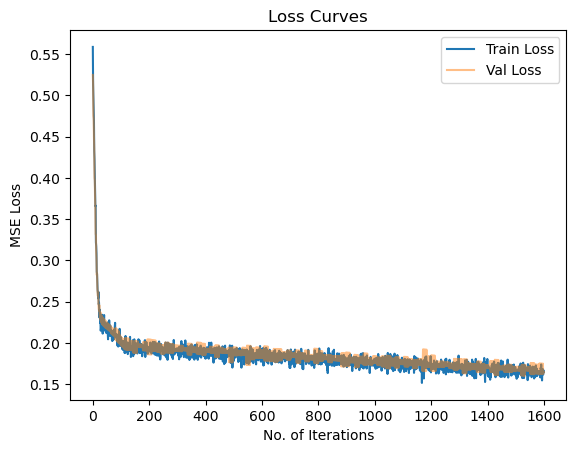

In [ ]:
num = 0


print (f"Number of epochs:{epochs}, \t Train and Validation batch_size = {batch_size},\t Test batch_size = {bs}")
print("Minimum Validation Loss: ",min_val_loss, "\nMinimum Train Loss: ", min_train_loss,  "\nTest Loss: ",Test_error)
print("========================================================")
print("Learning rate: ", lr)
print(f"Time taken for Training = {round(tok-tik, 3)}s")
plt.plot(train_loss_arr[num:], label = "Train Loss", alpha = 1)
plt.plot(val_loss_arr[num:], label = "Val Loss", alpha = 0.5)
plt.legend()
plt.title("Loss Curves")
plt.xlabel("No. of Iterations")
plt.ylabel("MSE Loss")
plt.show()

# **Predicring the similarities**

In [ ]:
# Predicring the similarities for the whole dataset one more time after the model is trained:
# These similarities will be used is input for the next step (clustering)

Total_error, predicted_sim_total = evaluate(Dataset_loader , model, loss_criterion)
print(Total_error)
print(len(predicted_sim_total[0]))
predicted_similarities = [j for sub in predicted_sim_total for j in sub]
print(len(predicted_similarities))

Matrix_predicted_similarities = np.reshape(predicted_similarities, (60, 60))
print(Matrix_predicted_similarities)
similarity_matrix = Matrix_predicted_similarities

0.003411659664577908
1
3600
[[0.86347014 0.94032645 0.8999458  ... 0.99443901 0.87165755 0.89540273]
 [0.858693   0.87161154 0.93090671 ... 0.94170219 0.89160353 0.815804  ]
 [0.85711694 0.90358436 0.85520244 ... 0.83095682 0.92497319 0.82392299]
 ...
 [0.81397229 0.86498475 0.88120872 ... 0.94943881 0.896429   0.88148224]
 [0.91218615 0.90974325 0.79044598 ... 0.93522477 0.81895953 0.91467232]
 [0.83975422 0.96762174 0.93565279 ... 0.82754612 0.81414038 0.88143849]]


# Part 2: Clustering the users (Diversity method)

In [ ]:
# Clustering with Diversity

def calculate_diversity(similarity_matrix, X):
    """
    Calculate the diversity of each user not in the cluster X
    based on the similarity kernel matrix.

    Parameters:
    - X: Current cluster

    Returns:
    - diversity: Array containing the diversity values for each user not in X
    """
    num_users = len(similarity_matrix)
    L_X = similarity_matrix[X][:, X]
    L_X_inv = np.linalg.inv(L_X)
    diversity = np.zeros(num_users)
    for i in range(num_users):
        if i not in X:
            L_i_X = similarity_matrix[i][X]
            L_i_i = similarity_matrix[i][i]
            diversity[i] = np.log(L_i_i - np.dot(L_i_X, np.dot(L_X_inv, L_i_X)))
    return diversity

In [ ]:
def cluster_users(similarity_matrix, threshold=0, max_users=None):
    """
    Cluster users based on the inverse of diversity in a Determinantal Point Process (DPP) kernel matrix.

    Parameters:
    - threshold: Diversity threshold to stop clustering (default: 0)
    - max_users: Maximum number of users in a cluster (default: None)

    Returns:
    - clusters: List of clusters, where each cluster is represented as a list of user indices
    """
    num_users = len(similarity_matrix)
    clusters = []
    remaining_users = list(range(num_users))
    print(max_users)
    while remaining_users:
        current_cluster = []
        # Calculate diversity for each user not in any cluster
        diversity = calculate_diversity(similarity_matrix, [])
        # Find the user with the least diversity scorev and add it to a new cluster
        next_user_idx = np.argmin(diversity[remaining_users])
        next_user = remaining_users[next_user_idx]
        current_cluster.append(next_user)
        remaining_users.pop(next_user_idx)

        while True:
            # Calculate diversity for each user not in the current cluster
            diversity = calculate_diversity(similarity_matrix, current_cluster)
            # Check if remaining_users is empty before finding next_user
            if remaining_users:
                next_user_idx = np.argmin(diversity[remaining_users])
                next_user = remaining_users[next_user_idx]
                remaining_users.pop(next_user_idx)
            else:
                break
            # Add the next_user to the current cluster
            current_cluster.append(next_user)
            # Check stopping conditions
            print(diversity[next_user])
            if (diversity[next_user] >= threshold) or (max_users is not None and len(current_cluster) >= max_users):
                clusters.append(current_cluster)
                break
    return clusters


clusters = cluster_users(similarity_matrix, threshold=1.0, max_users=3)
print("Clusters:", clusters)

3
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-3.5878442800266255
-4.197698841708161
nan
-1.6573546445453031
Clusters: [[48, 0, 4], [44, 1, 2], [58, 3, 8], [10, 5, 6], [11, 7, 18], [51, 9, 19], [55, 12, 14], [23, 15, 39], [40, 13, 17], [56, 21, 22], [38, 26, 33], [50, 25, 35], [34, 16, 52], [36, 27, 24], [42, 28, 43], [47, 30, 49], [46, 20, 59], [53, 45, 29], [54, 32, 37], [41, 57, 31]]


/var/folders/3n/n3f4n2gn3hg1xvkglkjfg8wh0000gq/T/ipykernel_57051/1567975827.py:22: RuntimeWarning: invalid value encountered in log
  diversity[i] = np.log(L_i_i - np.dot(L_i_X, np.dot(L_X_inv, L_i_X)))


In [ ]:
# Saving the groups ids as a csv file:
import csv
file_path = "3.SimGNN_groupMambersIDs_CarData_DiversityClustering.csv"

# Saving the groups ids as a csv file:
# Write the 2D list to the CSV file
with open(file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    for row in clusters:
        csv_writer.writerow(row)

print("CSV file saved successfully.")

CSV file saved successfully.
